In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.8.0+cu126
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 90.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# define  dataset tho

In [2]:
import json
import os
import os.path as osp
from typing import Callable, List, Optional, Union

import torch

from torch_geometric.data import (
    Data,
    InMemoryDataset,
    download_url,
    extract_zip,
)
from torch_geometric.io import fs, read_txt_array


class BreakBad(InMemoryDataset):
    r"""The ShapeNet part level segmentation dataset from the `"A Scalable
    Active Framework for Region Annotation in 3D Shape Collections"
    <http://web.stanford.edu/~ericyi/papers/part_annotation_16_small.pdf>`_
    paper, containing about 17,000 3D shape point clouds from 16 shape
    categories.
    Each category is annotated with 2 to 6 parts.

    Args:
        root (str): Root directory where the dataset should be saved.
        categories (str or [str], optional): The category of the CAD models
            (one or a combination of :obj:`"Airplane"`, :obj:`"Bag"`,
            :obj:`"Cap"`, :obj:`"Car"`, :obj:`"Chair"`, :obj:`"Earphone"`,
            :obj:`"Guitar"`, :obj:`"Knife"`, :obj:`"Lamp"`, :obj:`"Laptop"`,
            :obj:`"Motorbike"`, :obj:`"Mug"`, :obj:`"Pistol"`, :obj:`"Rocket"`,
            :obj:`"Skateboard"`, :obj:`"Table"`).
            Can be explicitly set to :obj:`None` to load all categories.
            (default: :obj:`None`)
        include_normals (bool, optional): If set to :obj:`False`, will not
            include normal vectors as input features to :obj:`data.x`.
            As a result, :obj:`data.x` will be :obj:`None`.
            (default: :obj:`True`)
        split (str, optional): If :obj:`"train"`, loads the training dataset.
            If :obj:`"val"`, loads the validation dataset.
            If :obj:`"trainval"`, loads the training and validation dataset.
            If :obj:`"test"`, loads the test dataset.
            (default: :obj:`"trainval"`)
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
        pre_filter (callable, optional): A function that takes in an
            :obj:`torch_geometric.data.Data` object and returns a boolean
            value, indicating whether the data object should be included in the
            final dataset. (default: :obj:`None`)
        force_reload (bool, optional): Whether to re-process the dataset.
            (default: :obj:`False`)

    **STATS:**

    .. list-table::
        :widths: 10 10 10 10 10
        :header-rows: 1

        * - #graphs
          - #nodes
          - #edges
          - #features
          - #classes
        * - 16,881
          - ~2,616.2
          - 0
          - 3
          - 50
    """

    url = ('https://shapenet.cs.stanford.edu/media/'
           'shapenetcore_partanno_segmentation_benchmark_v0_normal.zip')

    # In case `shapenet.cs.stanford.edu` is offline, try to download the data
    # from Kaggle instead (requires login):
    # https://www.kaggle.com/datasets/mitkir/shapenet/download?datasetVersionNumber=1

    category_ids = {
        'Statue_0': '101902_sf',
        'Statue_1': '102068_sf',
        'Statue_2': '103538_sf',
        'Statue_3': '103737_sf',
        'Statue_4': '104442_sf',
        'Statue_5': '108010_sf',
        'Statue_6': '120477_sf',
        'Statue_7': '120628_sf',

    }



    seg_classes = {
        'Statue_0': [0,1],
        'Statue_1': [2,3],
        'Statue_2': [4,5],
        'Statue_3': [6,7],
        'Statue_4': [8,9],
        'Statue_5': [10,11],
        'Statue_6': [12,13],
        'Statue_7': [14,15],
    }

    def __init__(
        self,
        root: str,
        categories: Optional[Union[str, List[str]]] = None,
        include_normals: bool = True,
        split: str = 'trainval',
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        pre_filter: Optional[Callable] = None,
        force_reload: bool = False,
    ) -> None:
        if categories is None:
            categories = list(self.category_ids.keys())
        if isinstance(categories, str):
            categories = [categories]
        print(categories)
        assert all(category in self.category_ids for category in categories)
        self.categories = categories
        super().__init__(root, transform, pre_transform, pre_filter,
                         force_reload=force_reload)

        if split == 'train':
            path = self.processed_paths[0]
        elif split == 'val':
            path = self.processed_paths[1]
        elif split == 'test':
            path = self.processed_paths[2]
        elif split == 'trainval':
            path = self.processed_paths[3]
        else:
            raise ValueError(f'Split {split} found, but expected either '
                             'train, val, trainval or test')

        self.load(path)

        assert isinstance(self._data, Data)
        self._data.x = self._data.x if include_normals else None

        self.y_mask = torch.zeros((len(self.seg_classes.keys()),len(self.seg_classes.keys())*2),
                                  dtype=torch.bool)
        for i, labels in enumerate(self.seg_classes.values()):
            self.y_mask[i, labels] = 1

    @property
    def num_classes(self) -> int:
        return self.y_mask.size(-1)

    @property
    def raw_file_names(self) -> List[str]:
        return list(self.category_ids.values()) + ['train_test_split']

    @property
    def processed_file_names(self) -> List[str]:
        cats = '_'.join([cat[:3].lower() for cat in self.categories])
        return [
            osp.join(f'{cats}_{split}.pt')
            for split in ['train', 'val', 'test', 'trainval']
        ]

    def download(self) -> None:
        pass

    def process_filenames(self, filenames: List[str]) -> List[Data]:
        rank_ids = {
        '101902_sf' : 0,
        '102068_sf' : 1,
        '103538_sf' : 2,
        '103737_sf' : 3,
        '104442_sf' : 4,
        '108010_sf' : 5,
        '120477_sf' : 6,
        '120628_sf' : 7,

        }
        data_list = []
        categories_ids = [self.category_ids[cat] for cat in self.categories]
        cat_idx = {categories_ids[i]: i for i in range(len(categories_ids))}

        for name in filenames:
            cat = name.split(osp.sep)[0]
            if cat not in categories_ids:
                continue
            my_custom_idx = rank_ids[cat]
            tensor = read_txt_array(osp.join(self.raw_dir, name))
            pos = tensor[:, :3]
            x = tensor[:, 3:6]
            y = tensor[:, -1].type(torch.long)+2*my_custom_idx
            data = Data(pos=pos, x=x, y=y, category=cat_idx[cat])
            if self.pre_filter is not None and not self.pre_filter(data):
                continue
            if self.pre_transform is not None:
                data = self.pre_transform(data)
            data_list.append(data)

        return data_list

    def process(self) -> None:
        trainval = []
        for i, split in enumerate(['train', 'val', 'test']):
            path = osp.join(self.raw_dir, 'train_test_split',
                            f'shuffled_{split}_file_list.json')
            with open(path) as f:
                filenames = [
                    osp.sep.join(name.split('/')[1:]) + '.txt'
                    for name in json.load(f)
                ]  # Removing first directory.
            data_list = self.process_filenames(filenames)
            if split == 'train' or split == 'val':
                trainval += data_list
            self.save(data_list, self.processed_paths[i])
        self.save(trainval, self.processed_paths[3])

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({len(self)}, '
                f'categories={self.categories})')


In [3]:
import torch.nn.functional as F
from torch_geometric.nn import MLP, DynamicEdgeConv


import torch_geometric.transforms as T
from torch_geometric.datasets import ShapeNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, knn_interpolate
from torch_geometric.typing import WITH_TORCH_CLUSTER
from torch_geometric.utils import scatter


In [4]:
!unzip /content/shapenet_withnormal_filtered.zip -d /content/temp_extract
!mkdir /content/data
!mkdir /content/data/raw
!mv /content/temp_extract/shapenet_withnormal_filtered/* /content/data/raw
!rm -r /content/temp_extract

Archive:  /content/shapenet_withnormal_filtered.zip
   creating: /content/temp_extract/shapenet_withnormal_filtered/
   creating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_20.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_22.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_40.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_41.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_46.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_59.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_70.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_72.txt  


In [5]:
category = None  # Pass in `None` to train on all categories.
path = "/content/data"
transform = T.Compose([
    T.RandomJitter(0.01),
    T.RandomRotate(15, axis=0),
    T.RandomRotate(15, axis=1),
    T.RandomRotate(15, axis=2)
])
pre_transform = T.NormalizeScale()
train_dataset = BreakBad(path, category, split='trainval', transform=transform,
                         pre_transform=pre_transform)
test_dataset = BreakBad(path, category, split='test',
                        pre_transform=pre_transform)
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True,
                          num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=False,
                         num_workers=2)

['Statue_0', 'Statue_1', 'Statue_2', 'Statue_3', 'Statue_4', 'Statue_5', 'Statue_6', 'Statue_7']


Processing...


['Statue_0', 'Statue_1', 'Statue_2', 'Statue_3', 'Statue_4', 'Statue_5', 'Statue_6', 'Statue_7']


Done!


In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
import torch
import random
import numpy as np

gt_cmap = np.array([
    [0.121, 0.466, 0.705],  # Blue for class 0
    [1.000, 0.498, 0.054],  # Orange for class 1
])

@torch.no_grad()
def visualize_ground_truth_3d(loader, num_samples=4):
    # Load all data samples into a list for random access
    all_data = list(loader)

    sampled_data = random.sample(all_data, min(num_samples, len(all_data)))
    sample_id = 1

    for data in sampled_data:
        data = data.to(device)

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        xs = data.pos.split(sizes)
        ys = data.y.split(sizes)

        for x, y in zip(xs, ys):
            x_np = x.cpu().numpy()
            y_np = y.cpu().numpy()

            # Convert y labels to RGB colors using gt_cmap
            colors = gt_cmap[y_np%2]
            print(f"Unique classes {np.unique(y_np)}")
            fig = plt.figure(figsize=(6, 5))
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(x_np[:, 0], x_np[:, 1], x_np[:, 2], c=colors, s=5)
            ax.set_title(f'Ground Truth - Sample {sample_id}')
            ax.set_axis_off()
            plt.tight_layout()
            plt.show()

            sample_id += 1
            if sample_id > num_samples:
                return


Unique classes [6 7]


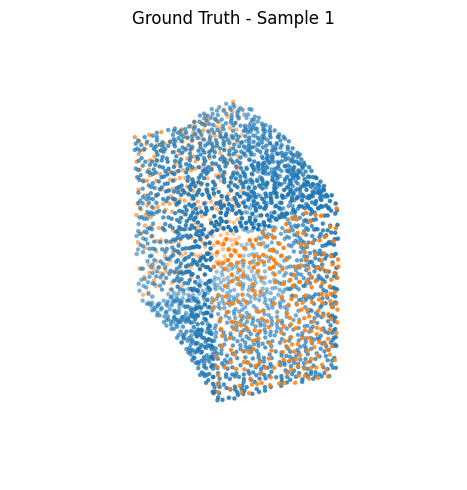

Unique classes [6 7]


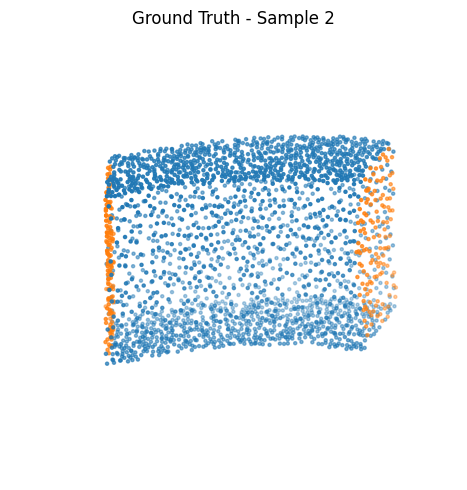

Unique classes [8 9]


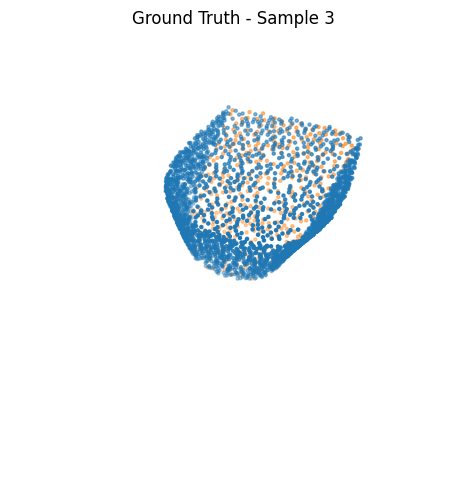

Unique classes [0 1]


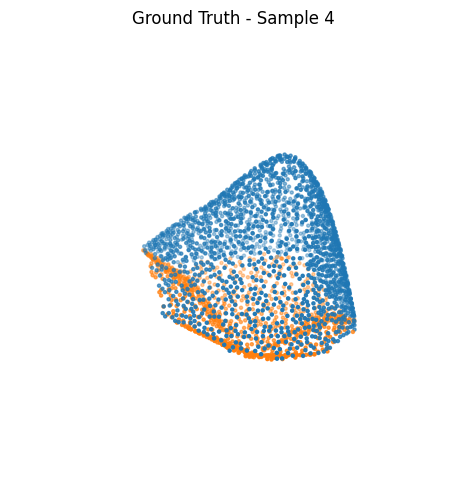

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
visualize_ground_truth_3d(test_loader, num_samples=4)

# Pointnet++


In [12]:
from torch_geometric.nn import MLP, PointNetConv, fps, global_max_pool, radius
class FPModule(torch.nn.Module):
    def __init__(self, k, nn):
        super().__init__()
        self.k = k
        self.nn = nn

    def forward(self, x, pos, batch, x_skip, pos_skip, batch_skip):
        x = knn_interpolate(x, pos, pos_skip, batch, batch_skip, k=self.k)
        if x_skip is not None:
            x = torch.cat([x, x_skip], dim=1)
        x = self.nn(x)
        return x, pos_skip, batch_skip

class SAModule(torch.nn.Module):
    def __init__(self, ratio, r, nn):
        super().__init__()
        self.ratio = ratio
        self.r = r
        self.conv = PointNetConv(nn, add_self_loops=False)

    def forward(self, x, pos, batch):
        idx = fps(pos, batch, ratio=self.ratio)
        row, col = radius(pos, pos[idx], self.r, batch, batch[idx],
                          max_num_neighbors=64)
        edge_index = torch.stack([col, row], dim=0)
        x_dst = None if x is None else x[idx]
        x = self.conv((x, x_dst), (pos, pos[idx]), edge_index)
        pos, batch = pos[idx], batch[idx]
        return x, pos, batch


class GlobalSAModule(torch.nn.Module):
    def __init__(self, nn):
        super().__init__()
        self.nn = nn

    def forward(self, x, pos, batch):
        x = self.nn(torch.cat([x, pos], dim=1))
        x = global_max_pool(x, batch)
        pos = pos.new_zeros((x.size(0), 3))
        batch = torch.arange(x.size(0), device=batch.device)
        return x, pos, batch


In [13]:

class Net(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Input channels account for both `pos` and node features.
        self.sa1_module = SAModule(0.2, 0.2, MLP([3 + 3, 64, 64, 128]))
        self.sa2_module = SAModule(0.25, 0.4, MLP([128 + 3, 128, 128, 256]))
        self.sa3_module = GlobalSAModule(MLP([256 + 3, 256, 512, 1024]))

        self.fp3_module = FPModule(1, MLP([1024 + 256, 256, 256]))
        self.fp2_module = FPModule(3, MLP([256 + 128, 256, 128]))
        self.fp1_module = FPModule(3, MLP([128 + 3, 128, 128, 128]))

        self.mlp = MLP([128, 128, 128, num_classes], dropout=0.5, norm=None)

        self.lin1 = torch.nn.Linear(128, 128)
        self.lin2 = torch.nn.Linear(128, 128)
        self.lin3 = torch.nn.Linear(128, num_classes)

    def forward(self, data):
        sa0_out = (data.x, data.pos, data.batch)
        sa1_out = self.sa1_module(*sa0_out)
        sa2_out = self.sa2_module(*sa1_out)
        sa3_out = self.sa3_module(*sa2_out)

        fp3_out = self.fp3_module(*sa3_out, *sa2_out)
        fp2_out = self.fp2_module(*fp3_out, *sa1_out)
        x, _, _ = self.fp1_module(*fp2_out, *sa0_out)

        return self.mlp(x).log_softmax(dim=-1)


In [14]:
def jaccard_index(pred: torch.Tensor, target: torch.Tensor, num_classes: int, absent_score: float = 1.0) -> float:
    """
    Compute mean Intersection over Union (IoU) between predicted and target labels.

    Args:
        pred (Tensor): Predicted labels (1D tensor of shape [N]).
        target (Tensor): Ground truth labels (1D tensor of shape [N]).
        num_classes (int): Number of classes to consider (usually the number of part labels for a category).
        absent_score (float): Score to assign if a class is absent in both pred and target.

    Returns:
        float: Mean IoU over classes.
    """
    device = pred.device
    ious = []

    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)

        intersection = (pred_inds & target_inds).sum()
        union = (pred_inds | target_inds).sum()

        if union == 0:
            iou = torch.tensor(absent_score, device=device)
        else:
            iou = intersection.float() / union.float()
        ious.append(iou)

    # Stack and compute mean
    return torch.stack(ious).mean().item()

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(train_dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.006)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)


[10/183] Loss: 2.6469 Train Acc: 0.1966
[20/183] Loss: 2.3804 Train Acc: 0.3495
[30/183] Loss: 2.2263 Train Acc: 0.3443
[40/183] Loss: 2.3631 Train Acc: 0.3471
[50/183] Loss: 2.2562 Train Acc: 0.3614
[60/183] Loss: 2.2918 Train Acc: 0.3304
[70/183] Loss: 2.4449 Train Acc: 0.2495
[80/183] Loss: 2.2918 Train Acc: 0.2764
[90/183] Loss: 2.1878 Train Acc: 0.3349
[100/183] Loss: 2.3882 Train Acc: 0.3101
[110/183] Loss: 2.2041 Train Acc: 0.3610
[120/183] Loss: 2.4137 Train Acc: 0.3109
[130/183] Loss: 2.2752 Train Acc: 0.3557
[140/183] Loss: 2.2493 Train Acc: 0.2859
[150/183] Loss: 2.0985 Train Acc: 0.3906
[160/183] Loss: 2.0905 Train Acc: 0.3578
[170/183] Loss: 1.9413 Train Acc: 0.4303
[180/183] Loss: 2.1017 Train Acc: 0.4029
Epoch: 01, Test IoU: 0.3523


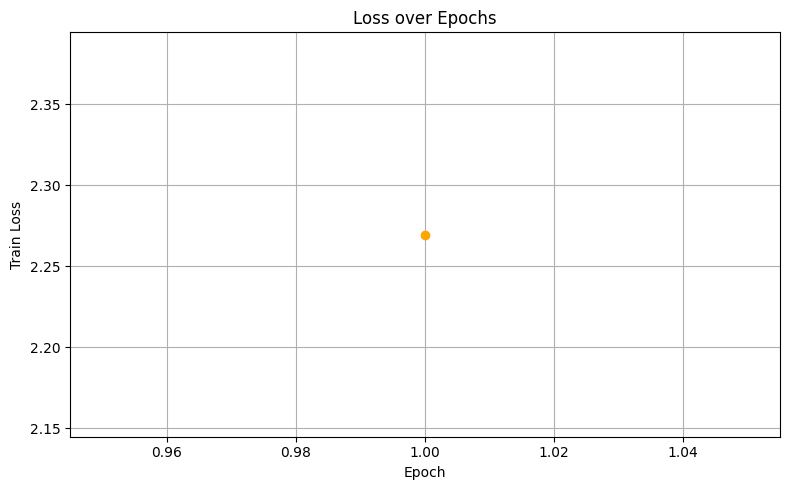

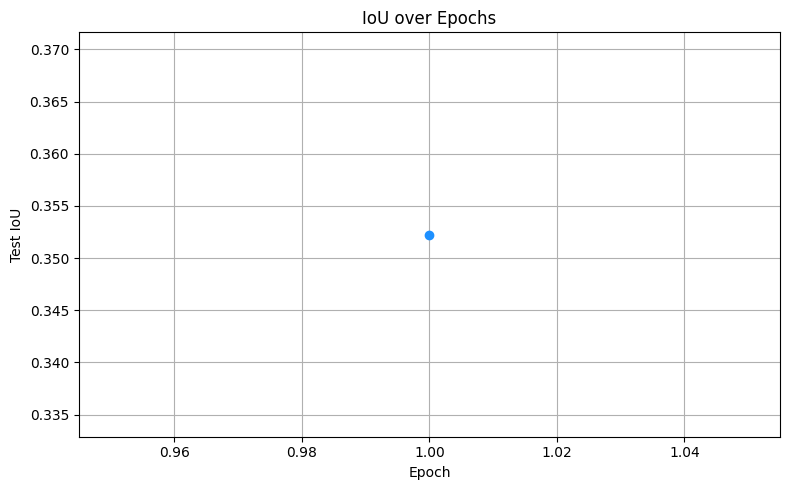

  >> Best model saved at epoch 1 with IoU: 0.3523
[10/183] Loss: 2.1009 Train Acc: 0.3340
[20/183] Loss: 2.0662 Train Acc: 0.3654
[30/183] Loss: 2.1110 Train Acc: 0.3589
[40/183] Loss: 2.5312 Train Acc: 0.2905
[50/183] Loss: 2.3885 Train Acc: 0.2751
[60/183] Loss: 2.1164 Train Acc: 0.3591
[70/183] Loss: 2.2087 Train Acc: 0.3536
[80/183] Loss: 2.2903 Train Acc: 0.3330
[90/183] Loss: 2.3276 Train Acc: 0.3282
[100/183] Loss: 2.0500 Train Acc: 0.3909
[110/183] Loss: 2.1273 Train Acc: 0.3270
[120/183] Loss: 2.0651 Train Acc: 0.3486
[130/183] Loss: 2.1241 Train Acc: 0.3479
[140/183] Loss: 1.9289 Train Acc: 0.4105
[150/183] Loss: 2.0063 Train Acc: 0.3743
[160/183] Loss: 2.0723 Train Acc: 0.3668
[170/183] Loss: 2.1422 Train Acc: 0.2877
[180/183] Loss: 2.0779 Train Acc: 0.3594
Epoch: 02, Test IoU: 0.3527


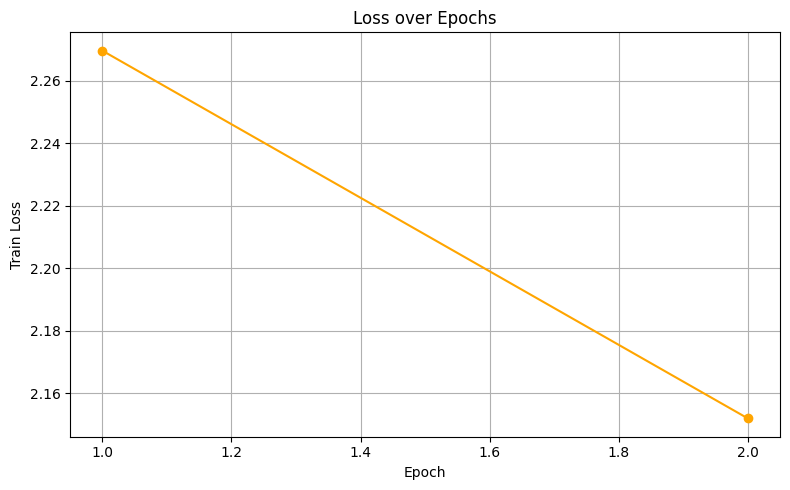

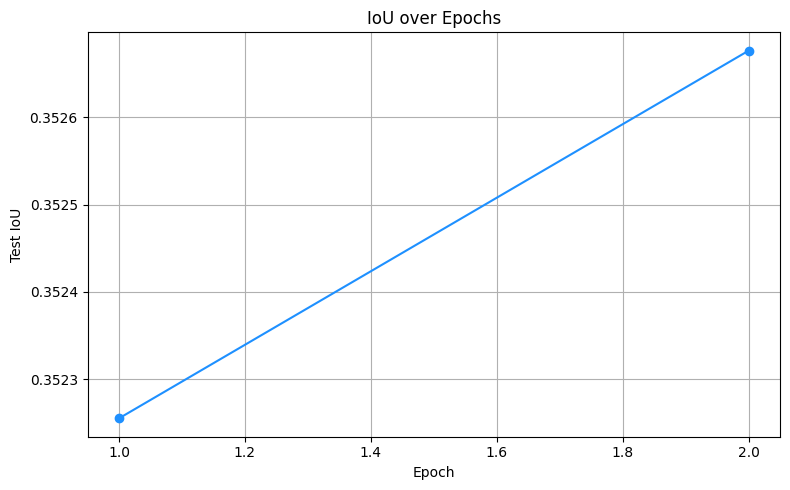

  >> Best model saved at epoch 2 with IoU: 0.3527
[10/183] Loss: 2.2925 Train Acc: 0.3436
[20/183] Loss: 2.2067 Train Acc: 0.3211
[30/183] Loss: 2.0949 Train Acc: 0.3182
[40/183] Loss: 1.9220 Train Acc: 0.3964
[50/183] Loss: 2.2005 Train Acc: 0.3448
[60/183] Loss: 2.2393 Train Acc: 0.2924
[70/183] Loss: 1.8812 Train Acc: 0.4184
[80/183] Loss: 2.1711 Train Acc: 0.4095
[90/183] Loss: 2.0724 Train Acc: 0.3570
[100/183] Loss: 2.0865 Train Acc: 0.3855
[110/183] Loss: 2.3067 Train Acc: 0.3383
[120/183] Loss: 2.1195 Train Acc: 0.3733
[130/183] Loss: 2.2828 Train Acc: 0.2937
[140/183] Loss: 2.1362 Train Acc: 0.3375
[150/183] Loss: 2.1103 Train Acc: 0.3456
[160/183] Loss: 2.1117 Train Acc: 0.3587
[170/183] Loss: 2.0249 Train Acc: 0.3828
[180/183] Loss: 2.1985 Train Acc: 0.3844
Epoch: 03, Test IoU: 0.3628


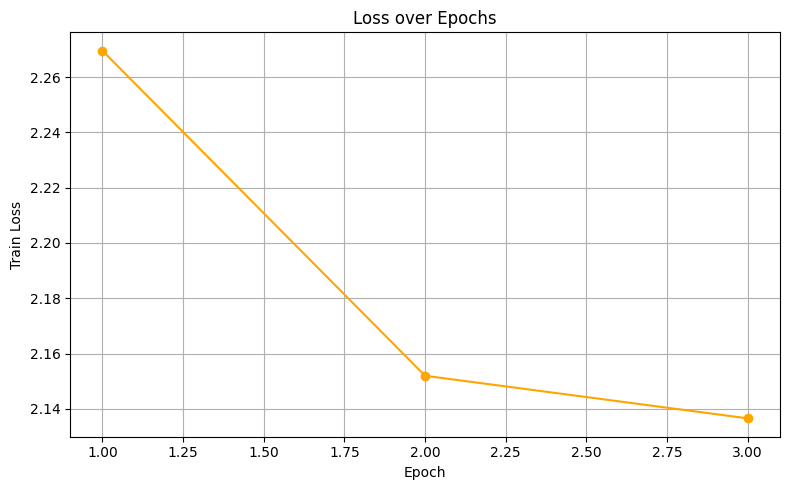

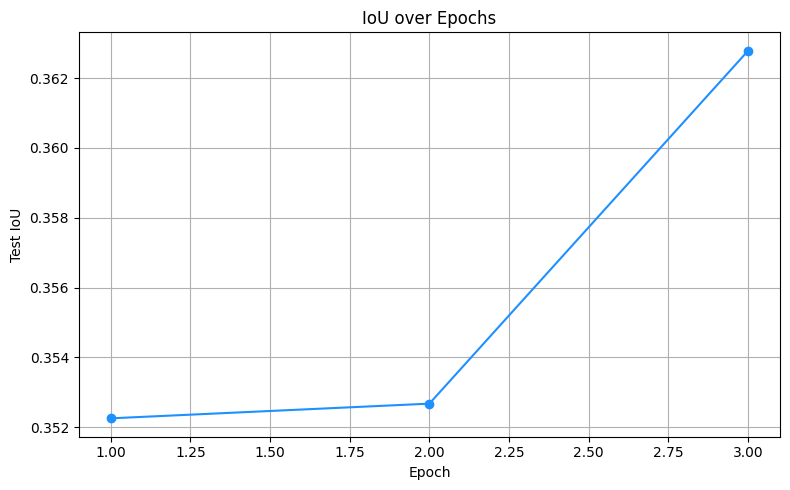

  >> Best model saved at epoch 3 with IoU: 0.3628
[10/183] Loss: 2.0595 Train Acc: 0.3533
[20/183] Loss: 2.0317 Train Acc: 0.3627
[30/183] Loss: 1.9885 Train Acc: 0.3626
[40/183] Loss: 2.0268 Train Acc: 0.3662
[50/183] Loss: 1.9947 Train Acc: 0.3480
[60/183] Loss: 1.9167 Train Acc: 0.3822
[70/183] Loss: 1.8592 Train Acc: 0.4037
[80/183] Loss: 1.9650 Train Acc: 0.3794
[90/183] Loss: 2.1385 Train Acc: 0.3335
[100/183] Loss: 1.9485 Train Acc: 0.3992
[110/183] Loss: 2.2263 Train Acc: 0.3530
[120/183] Loss: 2.1515 Train Acc: 0.3387
[130/183] Loss: 2.0496 Train Acc: 0.3356
[140/183] Loss: 1.9756 Train Acc: 0.4143
[150/183] Loss: 2.0240 Train Acc: 0.3201
[160/183] Loss: 1.9532 Train Acc: 0.3774
[170/183] Loss: 1.7796 Train Acc: 0.4289
[180/183] Loss: 1.9017 Train Acc: 0.3695
Epoch: 04, Test IoU: 0.3563


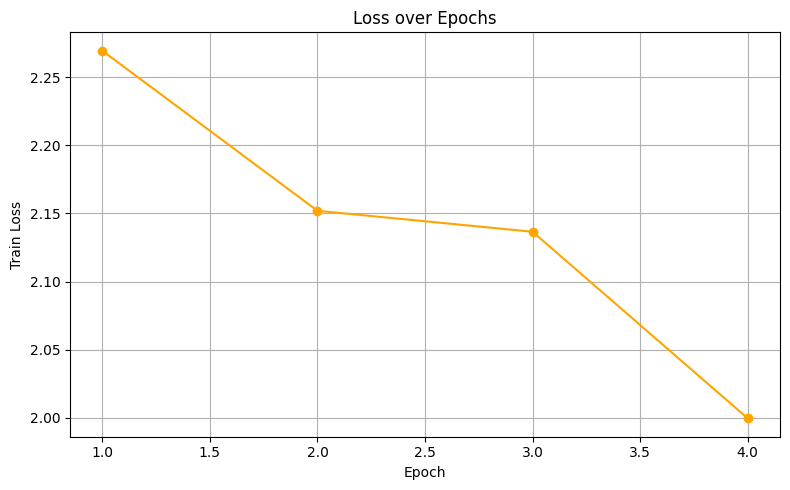

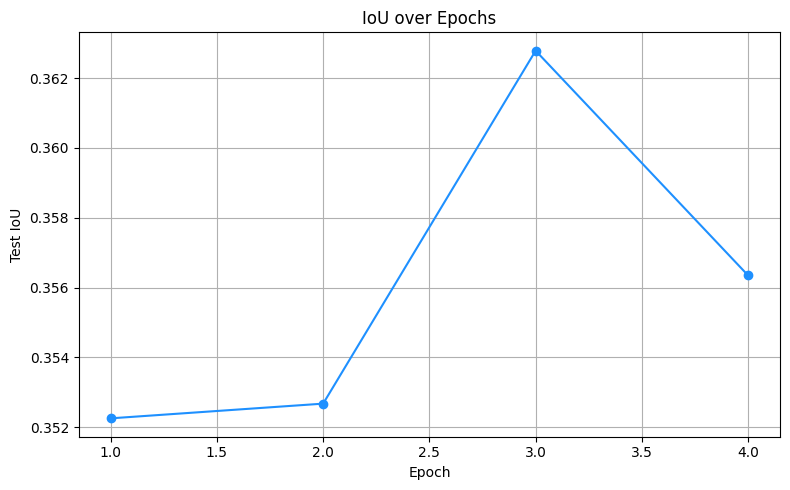

[10/183] Loss: 1.8722 Train Acc: 0.3902
[20/183] Loss: 2.0961 Train Acc: 0.3347
[30/183] Loss: 1.9135 Train Acc: 0.3953
[40/183] Loss: 1.8877 Train Acc: 0.4224
[50/183] Loss: 2.0398 Train Acc: 0.3818
[60/183] Loss: 1.9051 Train Acc: 0.4181
[70/183] Loss: 1.9381 Train Acc: 0.4132
[80/183] Loss: 2.0100 Train Acc: 0.3578
[90/183] Loss: 1.9074 Train Acc: 0.4016
[100/183] Loss: 1.9242 Train Acc: 0.3933
[110/183] Loss: 1.8050 Train Acc: 0.4569
[120/183] Loss: 2.0335 Train Acc: 0.3457
[130/183] Loss: 2.1664 Train Acc: 0.2989
[140/183] Loss: 1.9661 Train Acc: 0.3805
[150/183] Loss: 1.9973 Train Acc: 0.3863
[160/183] Loss: 2.0626 Train Acc: 0.3835
[170/183] Loss: 1.9296 Train Acc: 0.4371
[180/183] Loss: 2.1331 Train Acc: 0.3514
Epoch: 05, Test IoU: 0.3534


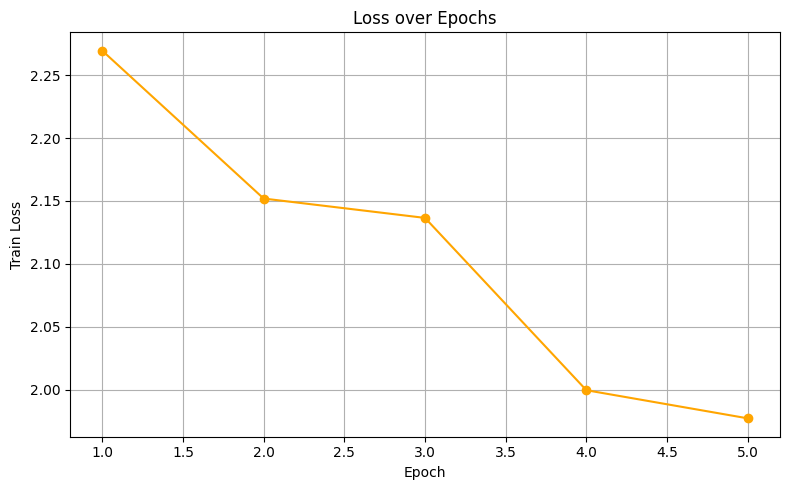

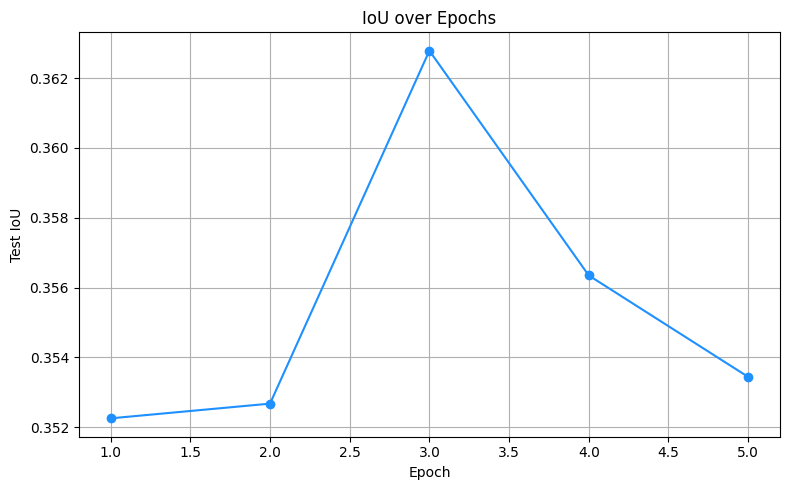

[10/183] Loss: 1.9061 Train Acc: 0.4387
[20/183] Loss: 1.9137 Train Acc: 0.3778
[30/183] Loss: 2.1429 Train Acc: 0.3552
[40/183] Loss: 1.7373 Train Acc: 0.4407
[50/183] Loss: 2.0775 Train Acc: 0.3997
[60/183] Loss: 1.9939 Train Acc: 0.3639
[70/183] Loss: 1.9998 Train Acc: 0.3751
[80/183] Loss: 1.8808 Train Acc: 0.4454
[90/183] Loss: 2.1882 Train Acc: 0.3287
[100/183] Loss: 2.0765 Train Acc: 0.3487
[110/183] Loss: 2.1738 Train Acc: 0.3010
[120/183] Loss: 2.1419 Train Acc: 0.3592
[130/183] Loss: 2.1242 Train Acc: 0.3301
[140/183] Loss: 2.0254 Train Acc: 0.3432
[150/183] Loss: 2.2494 Train Acc: 0.3494
[160/183] Loss: 1.9541 Train Acc: 0.3777
[170/183] Loss: 1.9076 Train Acc: 0.3936
[180/183] Loss: 1.8703 Train Acc: 0.3944
Epoch: 06, Test IoU: 0.3526


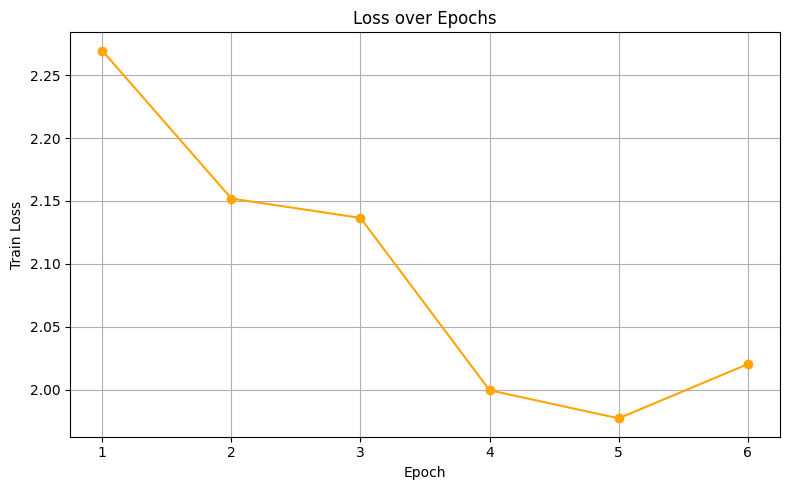

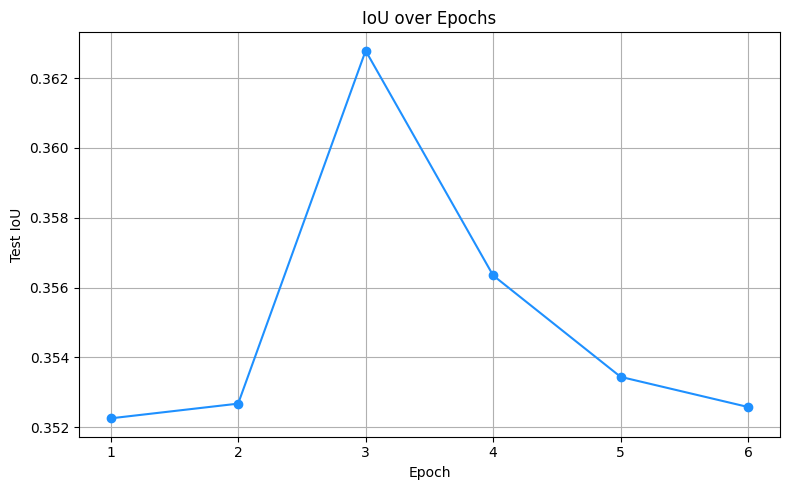

[10/183] Loss: 2.2198 Train Acc: 0.3278
[20/183] Loss: 2.0041 Train Acc: 0.3461
[30/183] Loss: 2.2282 Train Acc: 0.3057
[40/183] Loss: 1.9631 Train Acc: 0.3968
[50/183] Loss: 1.9227 Train Acc: 0.3129
[60/183] Loss: 1.7278 Train Acc: 0.4360
[70/183] Loss: 2.0003 Train Acc: 0.3607
[80/183] Loss: 2.1334 Train Acc: 0.3763
[90/183] Loss: 2.0778 Train Acc: 0.3660
[100/183] Loss: 1.8005 Train Acc: 0.4286
[110/183] Loss: 1.9214 Train Acc: 0.3845
[120/183] Loss: 1.6930 Train Acc: 0.4488
[130/183] Loss: 1.7595 Train Acc: 0.4460
[140/183] Loss: 1.9228 Train Acc: 0.3969
[150/183] Loss: 2.0461 Train Acc: 0.3757
[160/183] Loss: 2.0241 Train Acc: 0.3717
[170/183] Loss: 1.9529 Train Acc: 0.3578
[180/183] Loss: 1.7729 Train Acc: 0.4251
Epoch: 07, Test IoU: 0.3468


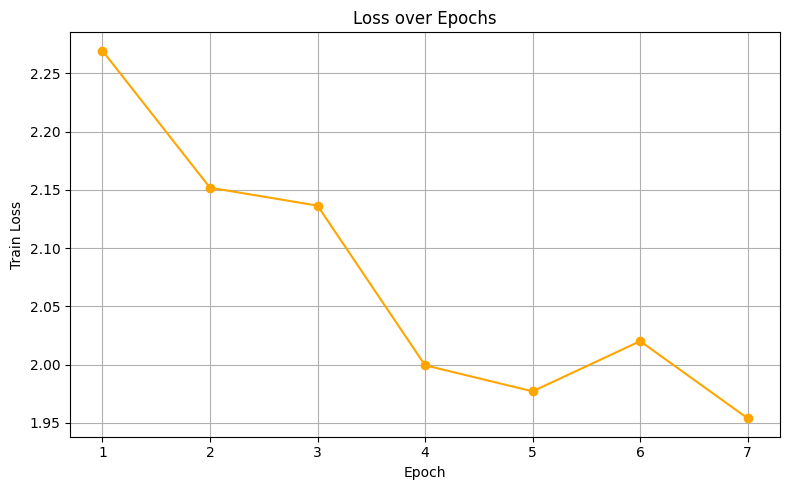

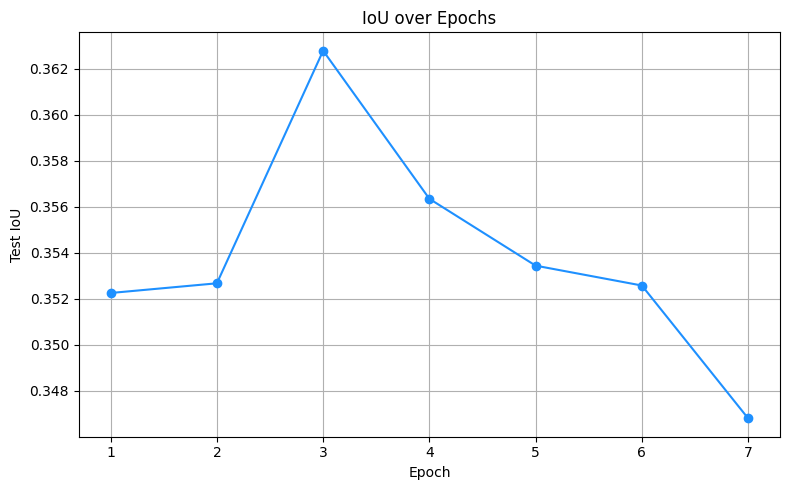

[10/183] Loss: 1.7184 Train Acc: 0.4482
[20/183] Loss: 1.9724 Train Acc: 0.3827
[30/183] Loss: 1.9746 Train Acc: 0.3664
[40/183] Loss: 1.6877 Train Acc: 0.4438
[50/183] Loss: 1.9066 Train Acc: 0.3755
[60/183] Loss: 1.6954 Train Acc: 0.4399
[70/183] Loss: 1.8555 Train Acc: 0.3917
[80/183] Loss: 2.0192 Train Acc: 0.3445
[90/183] Loss: 1.9366 Train Acc: 0.3603
[100/183] Loss: 1.8353 Train Acc: 0.4033
[110/183] Loss: 1.8505 Train Acc: 0.3925
[120/183] Loss: 1.8934 Train Acc: 0.3701
[130/183] Loss: 2.0685 Train Acc: 0.3703
[140/183] Loss: 2.0015 Train Acc: 0.3830
[150/183] Loss: 1.9759 Train Acc: 0.3843
[160/183] Loss: 1.9307 Train Acc: 0.3887
[170/183] Loss: 2.0463 Train Acc: 0.3383
[180/183] Loss: 1.7500 Train Acc: 0.4366
Epoch: 08, Test IoU: 0.3480


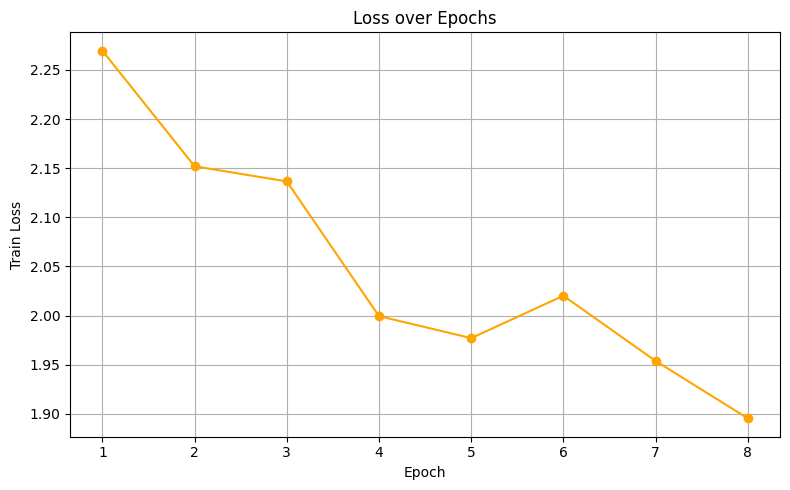

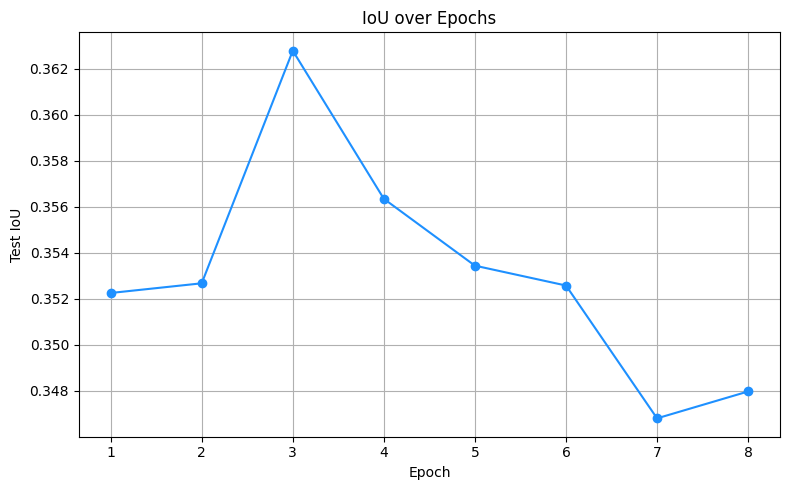

[10/183] Loss: 1.8561 Train Acc: 0.4051
[20/183] Loss: 1.9296 Train Acc: 0.3959
[30/183] Loss: 2.1634 Train Acc: 0.4208
[40/183] Loss: 1.9134 Train Acc: 0.4083
[50/183] Loss: 1.6056 Train Acc: 0.4673
[60/183] Loss: 2.1776 Train Acc: 0.3859
[70/183] Loss: 1.9523 Train Acc: 0.3722
[80/183] Loss: 2.2342 Train Acc: 0.2882
[90/183] Loss: 1.9970 Train Acc: 0.3892
[100/183] Loss: 1.9140 Train Acc: 0.3948
[110/183] Loss: 1.8282 Train Acc: 0.4072
[120/183] Loss: 1.8719 Train Acc: 0.3542
[130/183] Loss: 1.7413 Train Acc: 0.4534
[140/183] Loss: 2.0259 Train Acc: 0.3681
[150/183] Loss: 1.8399 Train Acc: 0.4115
[160/183] Loss: 2.0152 Train Acc: 0.3940
[170/183] Loss: 2.0210 Train Acc: 0.2983
[180/183] Loss: 1.8284 Train Acc: 0.4044
Epoch: 09, Test IoU: 0.3402


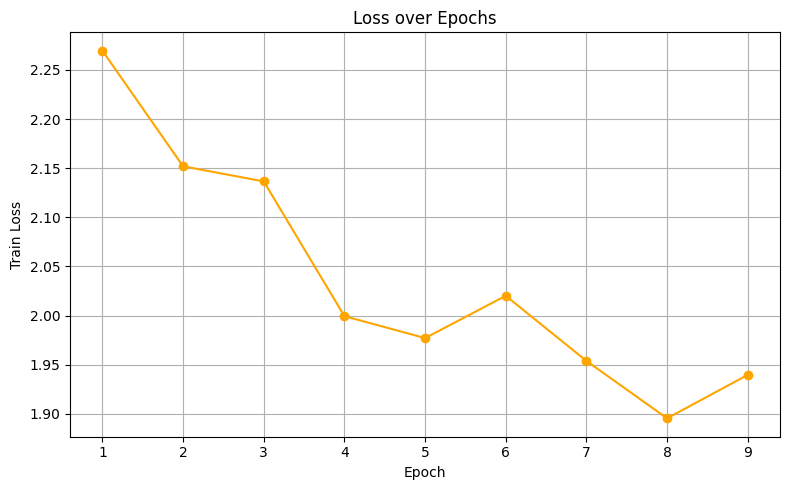

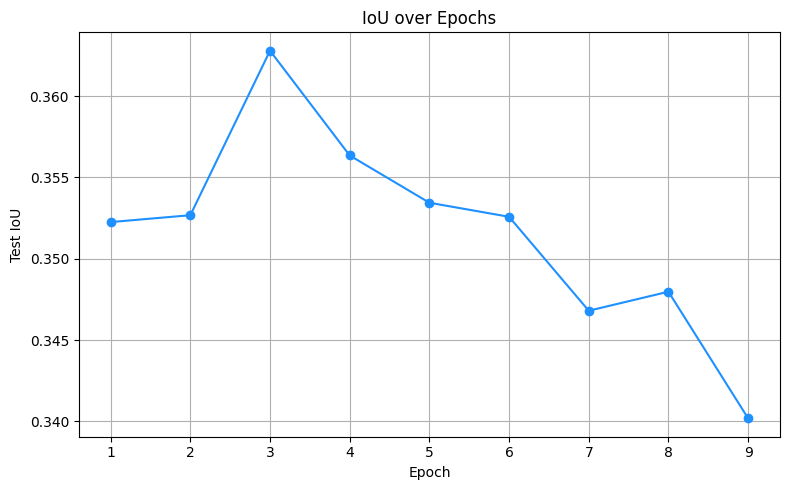

[10/183] Loss: 1.6302 Train Acc: 0.4816
[20/183] Loss: 2.0854 Train Acc: 0.3905
[30/183] Loss: 1.8646 Train Acc: 0.4129
[40/183] Loss: 1.8675 Train Acc: 0.4068
[50/183] Loss: 1.8677 Train Acc: 0.4219
[60/183] Loss: 2.1331 Train Acc: 0.3763
[70/183] Loss: 1.9376 Train Acc: 0.3921
[80/183] Loss: 2.1430 Train Acc: 0.3713
[90/183] Loss: 1.8699 Train Acc: 0.4187
[100/183] Loss: 1.9285 Train Acc: 0.3609
[110/183] Loss: 1.7344 Train Acc: 0.4563
[120/183] Loss: 2.1206 Train Acc: 0.3403
[130/183] Loss: 2.0661 Train Acc: 0.3214
[140/183] Loss: 1.9527 Train Acc: 0.3377
[150/183] Loss: 1.7618 Train Acc: 0.4211
[160/183] Loss: 2.0757 Train Acc: 0.3642
[170/183] Loss: 2.1400 Train Acc: 0.3533
[180/183] Loss: 2.1280 Train Acc: 0.3332
Epoch: 10, Test IoU: 0.3533


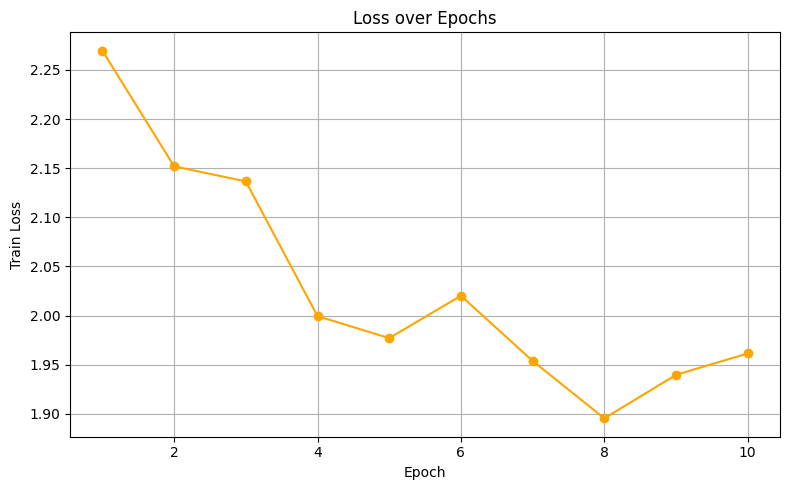

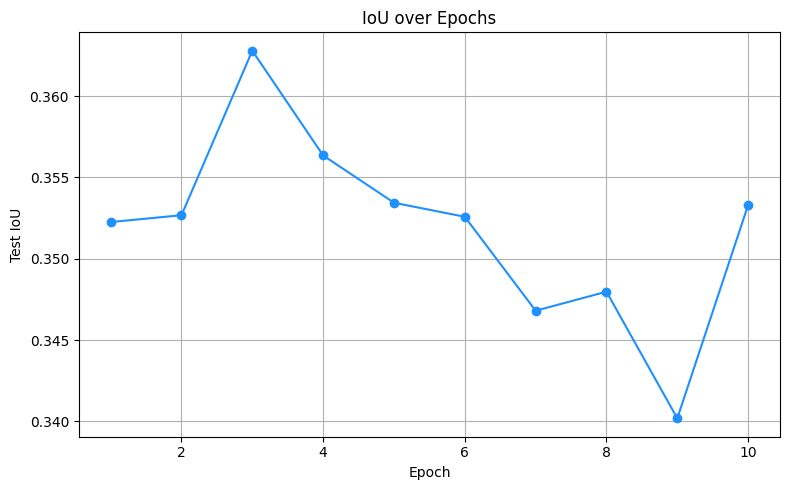

[10/183] Loss: 1.8932 Train Acc: 0.3956
[20/183] Loss: 2.1627 Train Acc: 0.4232
[30/183] Loss: 2.0424 Train Acc: 0.3725
[40/183] Loss: 2.0738 Train Acc: 0.3167
[50/183] Loss: 1.8246 Train Acc: 0.4468
[60/183] Loss: 1.7933 Train Acc: 0.4109
[70/183] Loss: 2.0849 Train Acc: 0.3006
[80/183] Loss: 1.8811 Train Acc: 0.3827
[90/183] Loss: 1.9152 Train Acc: 0.3844
[100/183] Loss: 1.8816 Train Acc: 0.4190
[110/183] Loss: 1.8894 Train Acc: 0.3765
[120/183] Loss: 1.6934 Train Acc: 0.4655
[130/183] Loss: 1.8480 Train Acc: 0.4035
[140/183] Loss: 1.8489 Train Acc: 0.4158
[150/183] Loss: 1.8920 Train Acc: 0.3988
[160/183] Loss: 1.9083 Train Acc: 0.4468
[170/183] Loss: 2.0780 Train Acc: 0.3431
[180/183] Loss: 1.9691 Train Acc: 0.3796
Epoch: 11, Test IoU: 0.3562


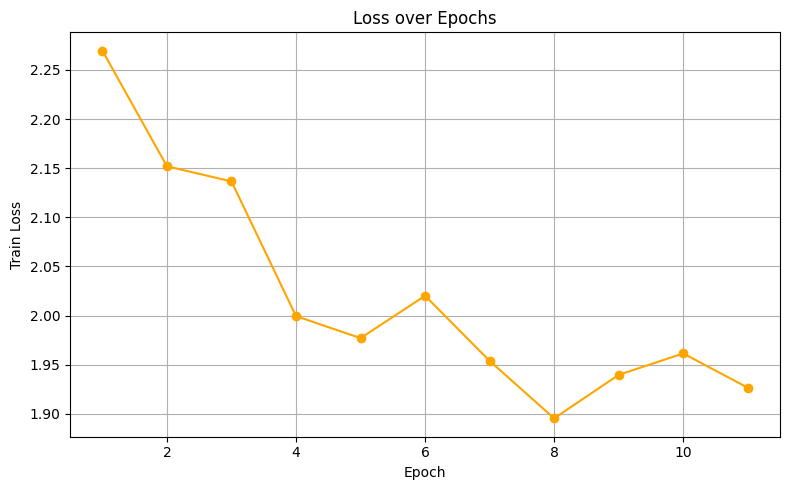

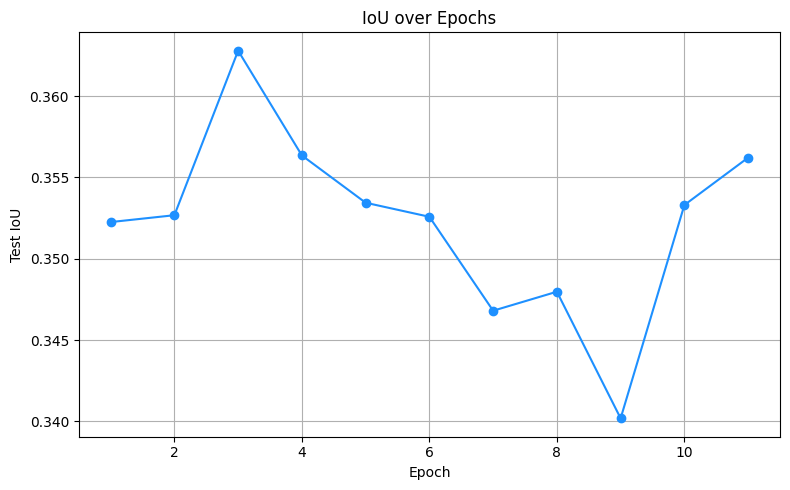

[10/183] Loss: 1.9095 Train Acc: 0.4567
[20/183] Loss: 2.0719 Train Acc: 0.3189
[30/183] Loss: 2.0702 Train Acc: 0.3386
[40/183] Loss: 1.9772 Train Acc: 0.4370
[50/183] Loss: 1.8999 Train Acc: 0.3990
[60/183] Loss: 1.8135 Train Acc: 0.4320
[70/183] Loss: 1.7601 Train Acc: 0.4309
[80/183] Loss: 1.8521 Train Acc: 0.3913
[90/183] Loss: 1.9767 Train Acc: 0.4060
[100/183] Loss: 1.8721 Train Acc: 0.4434
[110/183] Loss: 1.7875 Train Acc: 0.4391
[120/183] Loss: 1.8522 Train Acc: 0.4113
[130/183] Loss: 1.7294 Train Acc: 0.4081
[140/183] Loss: 1.8458 Train Acc: 0.3940
[150/183] Loss: 1.7316 Train Acc: 0.4223
[160/183] Loss: 1.8938 Train Acc: 0.4182
[170/183] Loss: 1.9324 Train Acc: 0.3545
[180/183] Loss: 1.8757 Train Acc: 0.3723
Epoch: 12, Test IoU: 0.3644


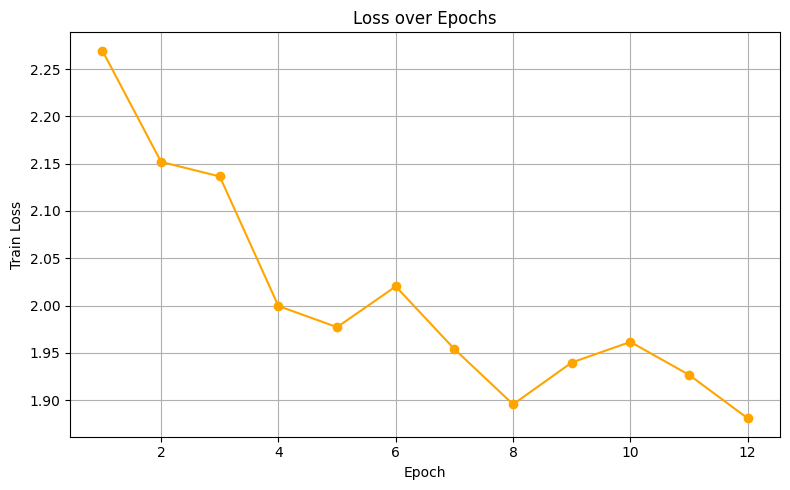

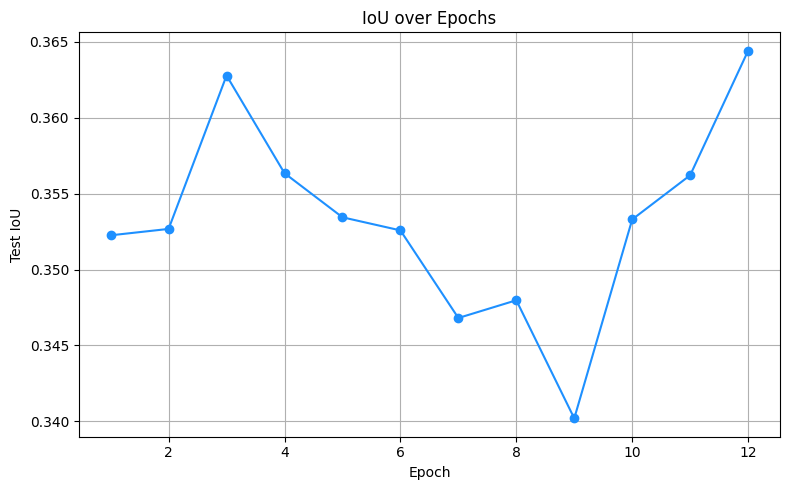

  >> Best model saved at epoch 12 with IoU: 0.3644
[10/183] Loss: 1.9228 Train Acc: 0.3734
[20/183] Loss: 1.7408 Train Acc: 0.4306
[30/183] Loss: 2.0602 Train Acc: 0.3817
[40/183] Loss: 1.8336 Train Acc: 0.4279
[50/183] Loss: 2.0630 Train Acc: 0.3524
[60/183] Loss: 1.7559 Train Acc: 0.4484
[70/183] Loss: 1.7586 Train Acc: 0.4237
[80/183] Loss: 1.7882 Train Acc: 0.4184
[90/183] Loss: 1.6963 Train Acc: 0.4533
[100/183] Loss: 2.0360 Train Acc: 0.3172
[110/183] Loss: 1.8222 Train Acc: 0.4050
[120/183] Loss: 1.7020 Train Acc: 0.4439
[130/183] Loss: 1.9386 Train Acc: 0.3916
[140/183] Loss: 1.9627 Train Acc: 0.3510
[150/183] Loss: 1.7691 Train Acc: 0.4338
[160/183] Loss: 1.7794 Train Acc: 0.4378
[170/183] Loss: 1.6729 Train Acc: 0.4337
[180/183] Loss: 1.9504 Train Acc: 0.4199
Epoch: 13, Test IoU: 0.3572


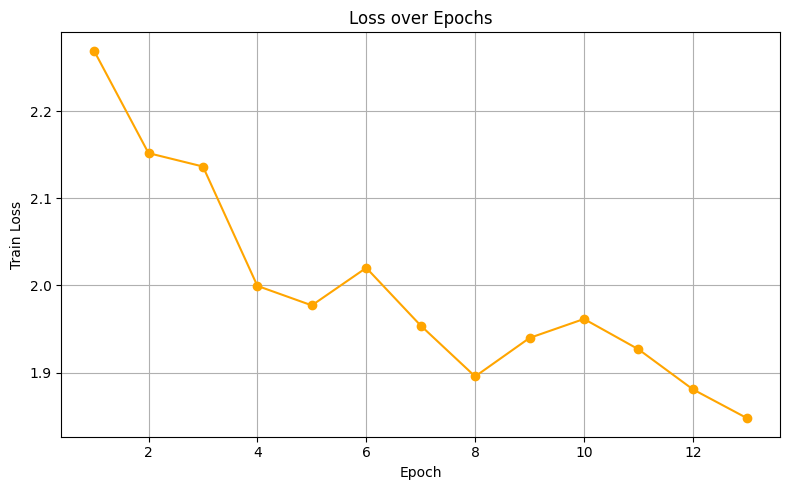

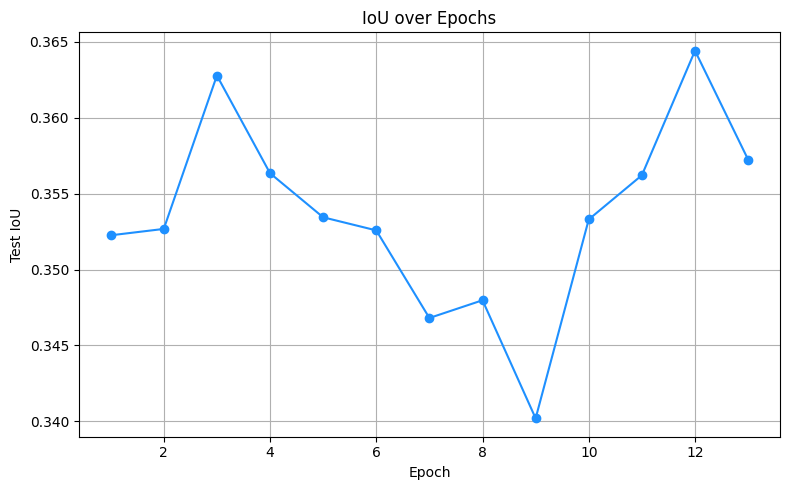

[10/183] Loss: 1.9736 Train Acc: 0.3856
[20/183] Loss: 1.7475 Train Acc: 0.4257
[30/183] Loss: 1.7677 Train Acc: 0.4440
[40/183] Loss: 1.6806 Train Acc: 0.4229
[50/183] Loss: 1.8036 Train Acc: 0.4276
[60/183] Loss: 1.7772 Train Acc: 0.4096
[70/183] Loss: 2.1294 Train Acc: 0.3278
[80/183] Loss: 2.0615 Train Acc: 0.3388
[90/183] Loss: 1.8712 Train Acc: 0.4189
[100/183] Loss: 1.9189 Train Acc: 0.3868
[110/183] Loss: 1.7921 Train Acc: 0.4166
[120/183] Loss: 1.8599 Train Acc: 0.4007
[130/183] Loss: 2.0583 Train Acc: 0.3315
[140/183] Loss: 1.6366 Train Acc: 0.4616
[150/183] Loss: 1.5553 Train Acc: 0.5081
[160/183] Loss: 1.9007 Train Acc: 0.4149
[170/183] Loss: 1.7138 Train Acc: 0.4485
[180/183] Loss: 1.8825 Train Acc: 0.4057
Epoch: 14, Test IoU: 0.3564


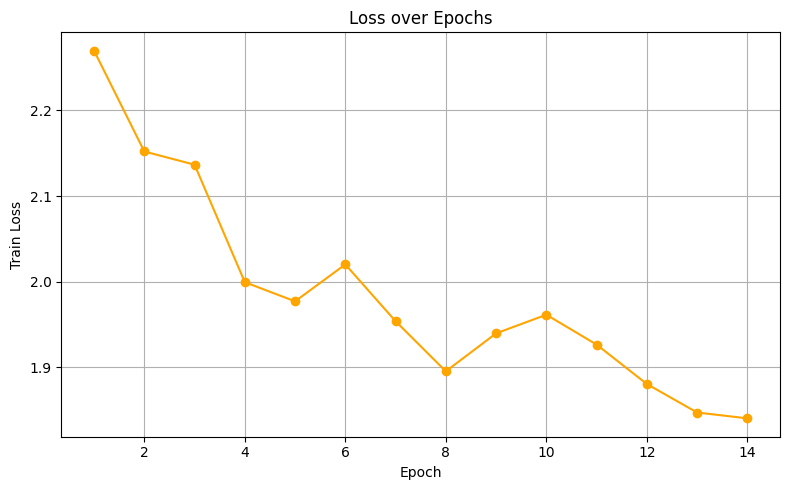

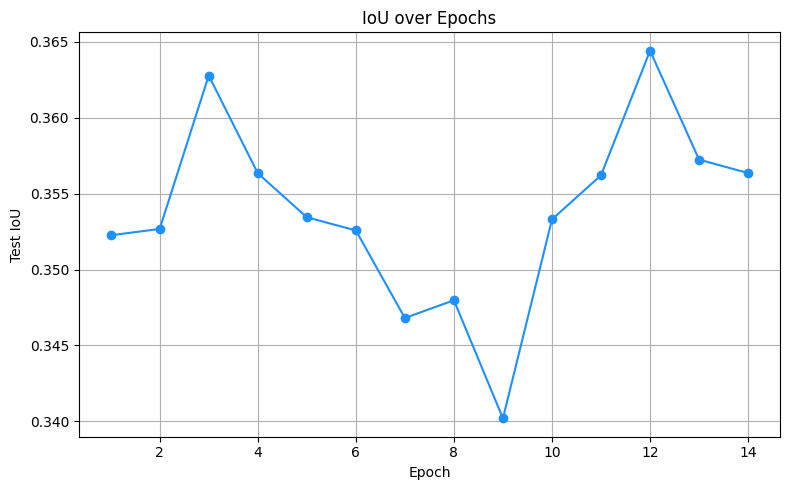

[10/183] Loss: 1.8801 Train Acc: 0.3859
[20/183] Loss: 1.8642 Train Acc: 0.3821
[30/183] Loss: 1.8295 Train Acc: 0.3871
[40/183] Loss: 1.9895 Train Acc: 0.3942
[50/183] Loss: 1.9850 Train Acc: 0.3844
[60/183] Loss: 1.9170 Train Acc: 0.4233
[70/183] Loss: 1.9074 Train Acc: 0.3827
[80/183] Loss: 1.7777 Train Acc: 0.4501
[90/183] Loss: 1.7695 Train Acc: 0.4057
[100/183] Loss: 1.9677 Train Acc: 0.4050
[110/183] Loss: 1.9080 Train Acc: 0.3931
[120/183] Loss: 1.7788 Train Acc: 0.4149
[130/183] Loss: 1.7848 Train Acc: 0.4130
[140/183] Loss: 1.7989 Train Acc: 0.4002
[150/183] Loss: 1.7699 Train Acc: 0.4335
[160/183] Loss: 1.7579 Train Acc: 0.4106
[170/183] Loss: 1.7417 Train Acc: 0.4125
[180/183] Loss: 1.6943 Train Acc: 0.4671
Epoch: 15, Test IoU: 0.3550


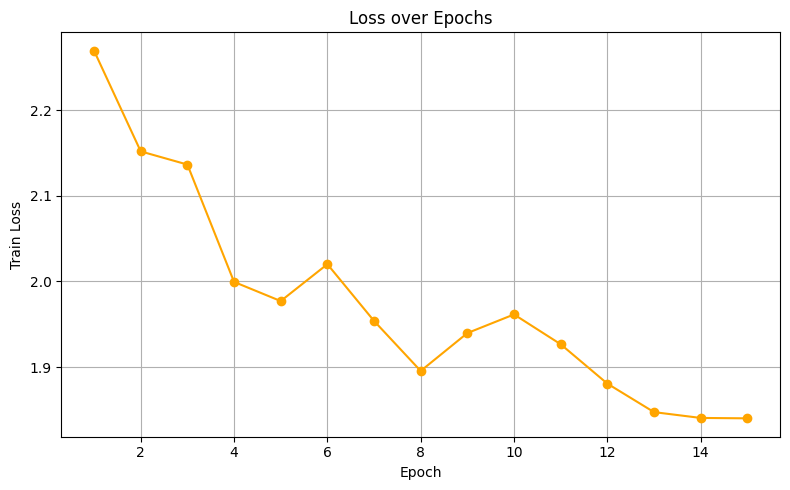

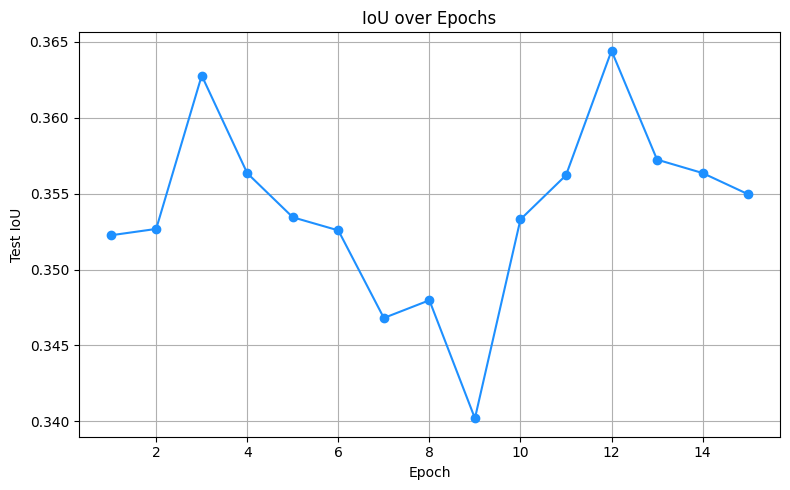

[10/183] Loss: 1.6230 Train Acc: 0.4794
[20/183] Loss: 1.9290 Train Acc: 0.4006
[30/183] Loss: 1.9310 Train Acc: 0.4022
[40/183] Loss: 1.9051 Train Acc: 0.3976
[50/183] Loss: 1.8622 Train Acc: 0.3752
[60/183] Loss: 1.7451 Train Acc: 0.4515
[70/183] Loss: 1.7130 Train Acc: 0.4400
[80/183] Loss: 1.7858 Train Acc: 0.4245
[90/183] Loss: 1.5528 Train Acc: 0.4731
[100/183] Loss: 2.0696 Train Acc: 0.3628
[110/183] Loss: 1.7495 Train Acc: 0.4599
[120/183] Loss: 1.8682 Train Acc: 0.4213
[130/183] Loss: 1.8108 Train Acc: 0.4058
[140/183] Loss: 1.9087 Train Acc: 0.3618
[150/183] Loss: 1.7944 Train Acc: 0.4065
[160/183] Loss: 1.8960 Train Acc: 0.3893
[170/183] Loss: 1.8367 Train Acc: 0.4007
[180/183] Loss: 2.0180 Train Acc: 0.3512
Epoch: 16, Test IoU: 0.3632


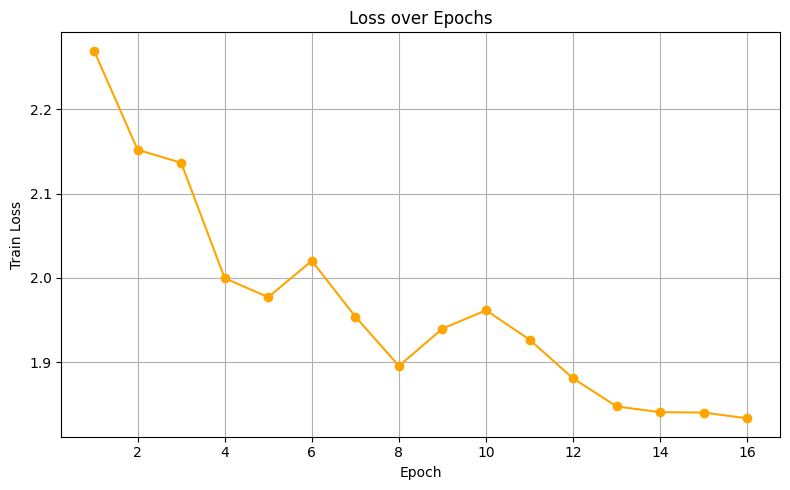

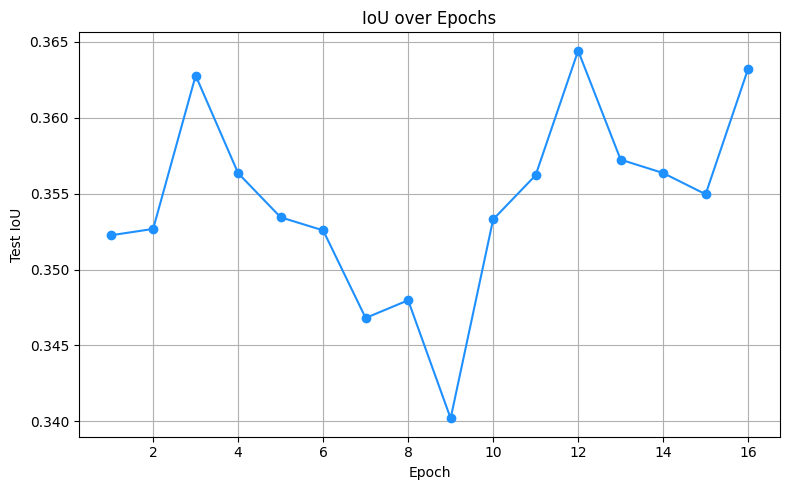

[10/183] Loss: 1.5485 Train Acc: 0.5367
[20/183] Loss: 1.6718 Train Acc: 0.4303
[30/183] Loss: 1.7462 Train Acc: 0.4317
[40/183] Loss: 1.7379 Train Acc: 0.4373
[50/183] Loss: 1.8607 Train Acc: 0.3623
[60/183] Loss: 1.8707 Train Acc: 0.3819
[70/183] Loss: 1.9919 Train Acc: 0.3453
[80/183] Loss: 1.8984 Train Acc: 0.3838
[90/183] Loss: 1.8562 Train Acc: 0.4101
[100/183] Loss: 1.9487 Train Acc: 0.3591
[110/183] Loss: 1.8302 Train Acc: 0.3979
[120/183] Loss: 1.8530 Train Acc: 0.3749
[130/183] Loss: 1.6017 Train Acc: 0.4503
[140/183] Loss: 2.1265 Train Acc: 0.3719
[150/183] Loss: 1.8082 Train Acc: 0.4250
[160/183] Loss: 1.9155 Train Acc: 0.3935
[170/183] Loss: 1.9856 Train Acc: 0.3750
[180/183] Loss: 1.8052 Train Acc: 0.4229
Epoch: 17, Test IoU: 0.3540


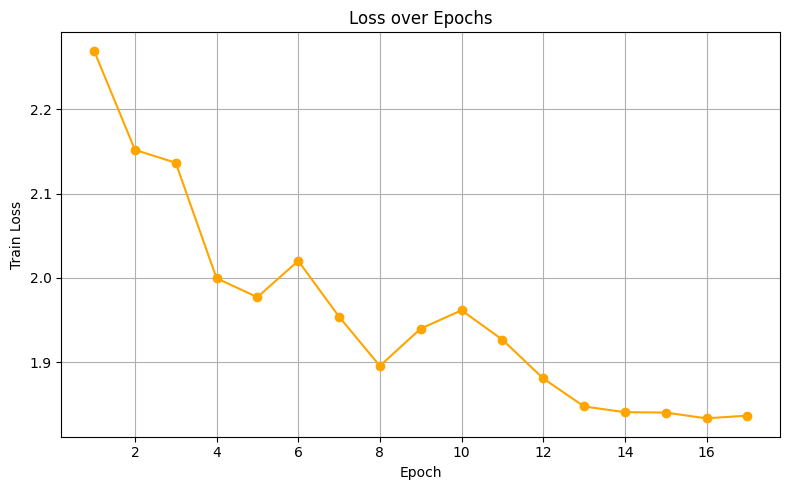

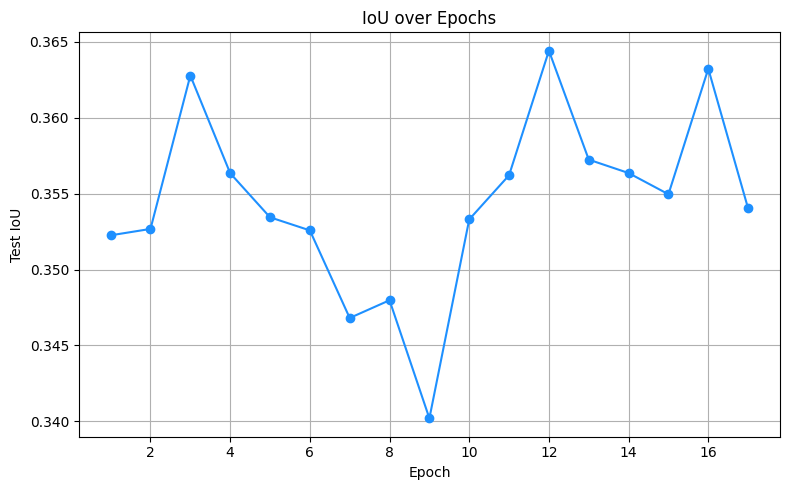

[10/183] Loss: 1.9041 Train Acc: 0.3977
[20/183] Loss: 1.8762 Train Acc: 0.4005
[30/183] Loss: 2.0770 Train Acc: 0.3931
[40/183] Loss: 1.9788 Train Acc: 0.3642
[50/183] Loss: 1.9744 Train Acc: 0.3934
[60/183] Loss: 1.9493 Train Acc: 0.4025
[70/183] Loss: 1.8652 Train Acc: 0.4222
[80/183] Loss: 2.0089 Train Acc: 0.3659
[90/183] Loss: 1.7291 Train Acc: 0.4259
[100/183] Loss: 1.7922 Train Acc: 0.4228
[110/183] Loss: 2.0485 Train Acc: 0.3726
[120/183] Loss: 1.9046 Train Acc: 0.3584
[130/183] Loss: 1.8846 Train Acc: 0.3668
[140/183] Loss: 1.8992 Train Acc: 0.3819
[150/183] Loss: 1.7767 Train Acc: 0.4421
[160/183] Loss: 1.6687 Train Acc: 0.4554
[170/183] Loss: 1.9309 Train Acc: 0.4065
[180/183] Loss: 1.6980 Train Acc: 0.4572
Epoch: 18, Test IoU: 0.3530


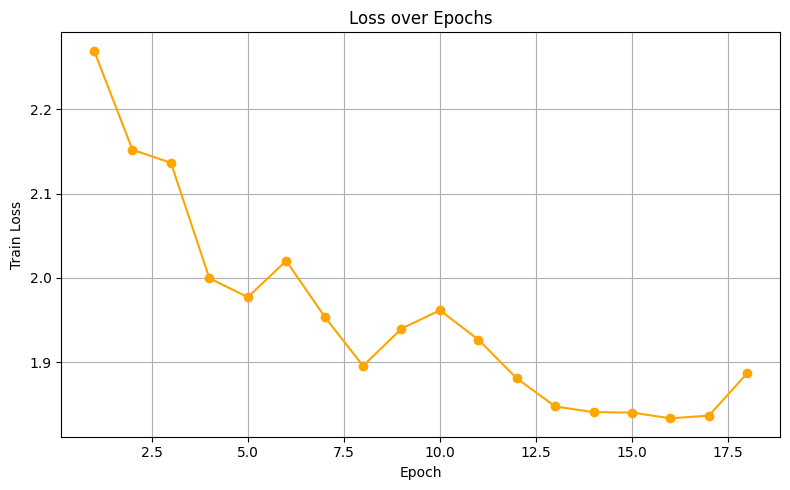

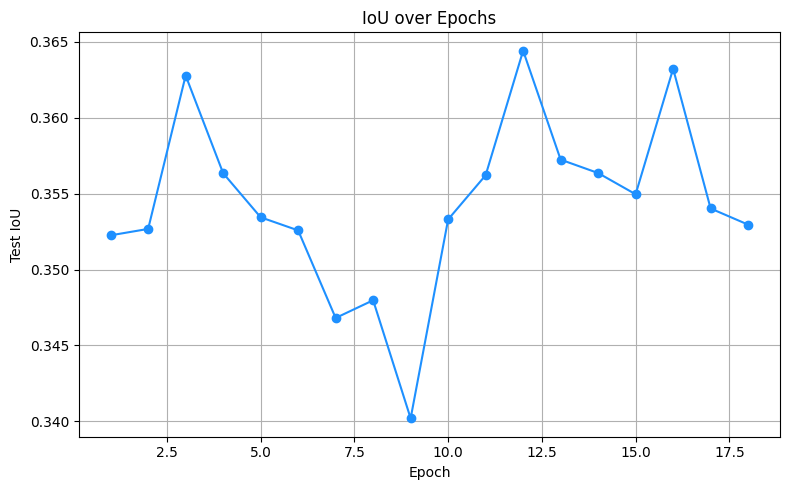

[10/183] Loss: 1.8742 Train Acc: 0.3939
[20/183] Loss: 1.7001 Train Acc: 0.4278
[30/183] Loss: 1.7769 Train Acc: 0.4317
[40/183] Loss: 1.9119 Train Acc: 0.3579
[50/183] Loss: 1.8500 Train Acc: 0.3964
[60/183] Loss: 1.6920 Train Acc: 0.4300
[70/183] Loss: 1.9054 Train Acc: 0.3727
[80/183] Loss: 1.8027 Train Acc: 0.4250
[90/183] Loss: 1.6609 Train Acc: 0.4155
[100/183] Loss: 1.6744 Train Acc: 0.4145
[110/183] Loss: 1.8144 Train Acc: 0.3883
[120/183] Loss: 2.0493 Train Acc: 0.3736
[130/183] Loss: 1.8057 Train Acc: 0.4062
[140/183] Loss: 1.7843 Train Acc: 0.4322
[150/183] Loss: 1.9597 Train Acc: 0.3843
[160/183] Loss: 1.8865 Train Acc: 0.4133
[170/183] Loss: 1.9833 Train Acc: 0.3759
[180/183] Loss: 1.9846 Train Acc: 0.3662
Epoch: 19, Test IoU: 0.3591


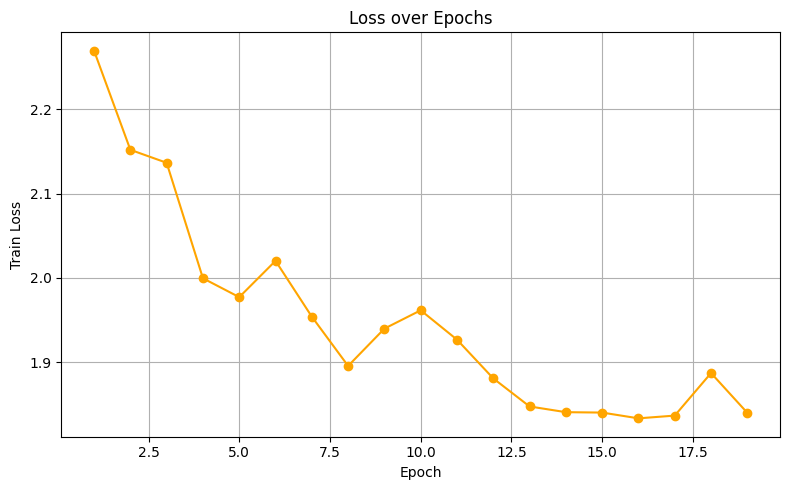

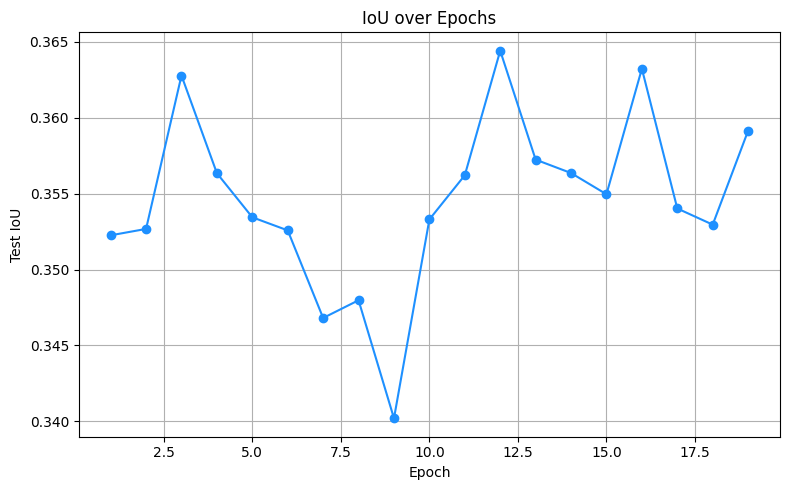

[10/183] Loss: 1.8390 Train Acc: 0.3808
[20/183] Loss: 1.8060 Train Acc: 0.4023
[30/183] Loss: 1.7123 Train Acc: 0.3966
[40/183] Loss: 1.7603 Train Acc: 0.4302
[50/183] Loss: 1.8388 Train Acc: 0.4048
[60/183] Loss: 1.7407 Train Acc: 0.4295
[70/183] Loss: 1.9974 Train Acc: 0.3443
[80/183] Loss: 1.7832 Train Acc: 0.4241
[90/183] Loss: 1.7385 Train Acc: 0.4153
[100/183] Loss: 1.9650 Train Acc: 0.3471
[110/183] Loss: 1.9800 Train Acc: 0.4368
[120/183] Loss: 1.7798 Train Acc: 0.4270
[130/183] Loss: 1.8799 Train Acc: 0.4880
[140/183] Loss: 1.9173 Train Acc: 0.3896
[150/183] Loss: 2.0822 Train Acc: 0.4461
[160/183] Loss: 1.9833 Train Acc: 0.3911
[170/183] Loss: 2.0701 Train Acc: 0.3587
[180/183] Loss: 1.7935 Train Acc: 0.4214
Epoch: 20, Test IoU: 0.3634


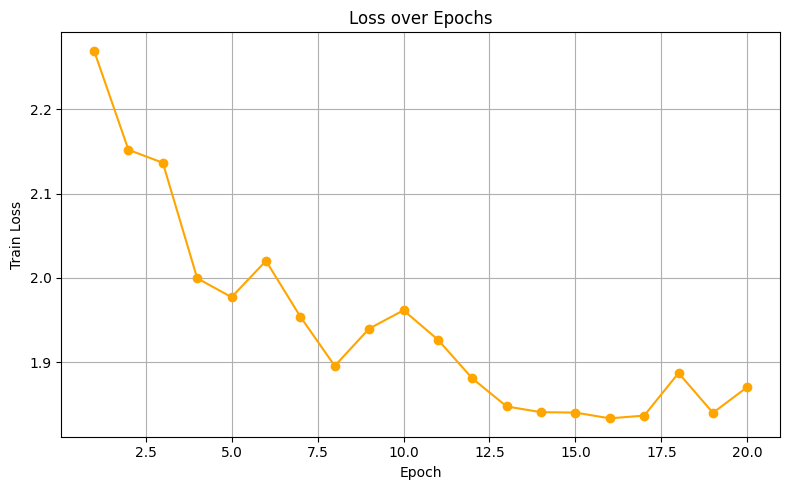

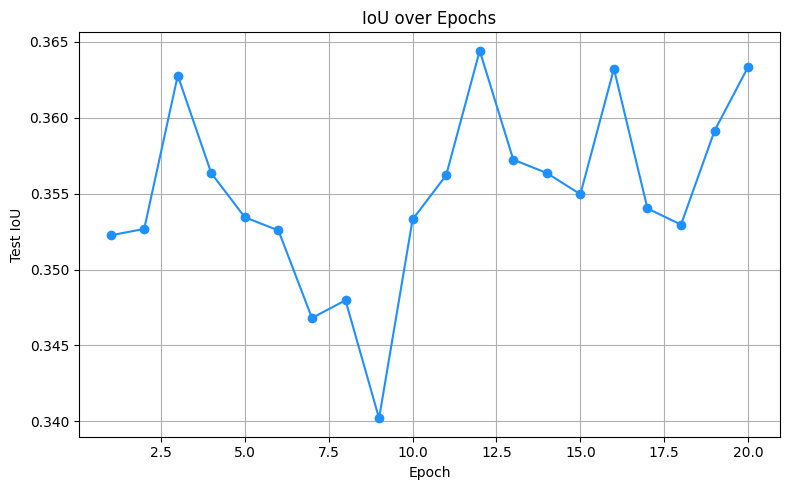

[10/183] Loss: 1.8965 Train Acc: 0.3934
[20/183] Loss: 1.7703 Train Acc: 0.4370
[30/183] Loss: 1.9807 Train Acc: 0.3798
[40/183] Loss: 2.0059 Train Acc: 0.3851
[50/183] Loss: 1.7627 Train Acc: 0.4349
[60/183] Loss: 1.7586 Train Acc: 0.4260
[70/183] Loss: 1.8804 Train Acc: 0.4045
[80/183] Loss: 1.9030 Train Acc: 0.3981
[90/183] Loss: 1.8235 Train Acc: 0.4038
[100/183] Loss: 1.7217 Train Acc: 0.4086
[110/183] Loss: 1.8133 Train Acc: 0.4115
[120/183] Loss: 2.0074 Train Acc: 0.3320
[130/183] Loss: 1.6014 Train Acc: 0.4888
[140/183] Loss: 1.8726 Train Acc: 0.4047
[150/183] Loss: 1.6448 Train Acc: 0.4443
[160/183] Loss: 1.6796 Train Acc: 0.4467
[170/183] Loss: 1.8369 Train Acc: 0.4200
[180/183] Loss: 1.8596 Train Acc: 0.3930
Epoch: 21, Test IoU: 0.3569


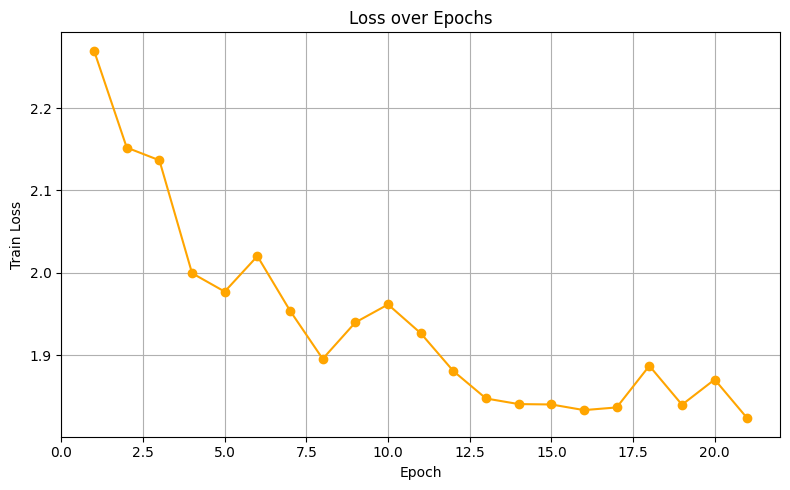

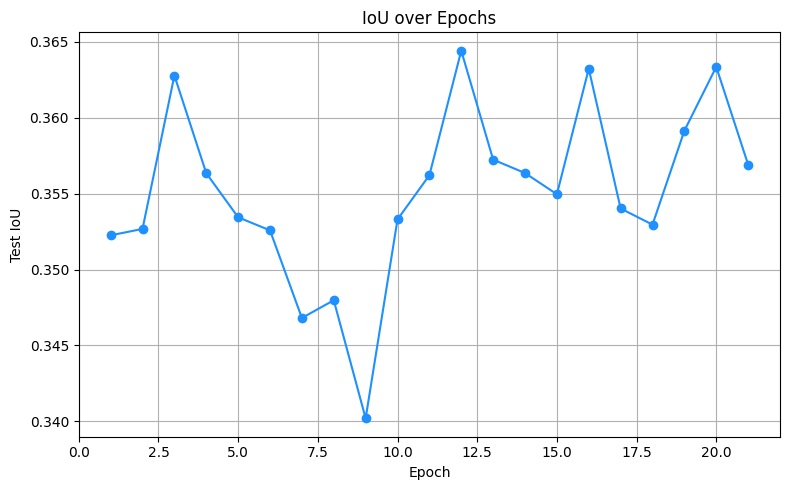

[10/183] Loss: 1.9901 Train Acc: 0.3834
[20/183] Loss: 1.8011 Train Acc: 0.4211
[30/183] Loss: 1.8346 Train Acc: 0.3907
[40/183] Loss: 1.7406 Train Acc: 0.4254
[50/183] Loss: 1.5990 Train Acc: 0.4546
[60/183] Loss: 1.6290 Train Acc: 0.4580
[70/183] Loss: 1.7997 Train Acc: 0.4522
[80/183] Loss: 1.7213 Train Acc: 0.4618
[90/183] Loss: 1.9514 Train Acc: 0.3700
[100/183] Loss: 1.6860 Train Acc: 0.4435
[110/183] Loss: 1.8632 Train Acc: 0.4098
[120/183] Loss: 1.8022 Train Acc: 0.4263
[130/183] Loss: 1.8400 Train Acc: 0.4018
[140/183] Loss: 1.8506 Train Acc: 0.3946
[150/183] Loss: 2.0004 Train Acc: 0.3524
[160/183] Loss: 1.8549 Train Acc: 0.4113
[170/183] Loss: 1.9076 Train Acc: 0.3798
[180/183] Loss: 1.8646 Train Acc: 0.3941
Epoch: 22, Test IoU: 0.3557


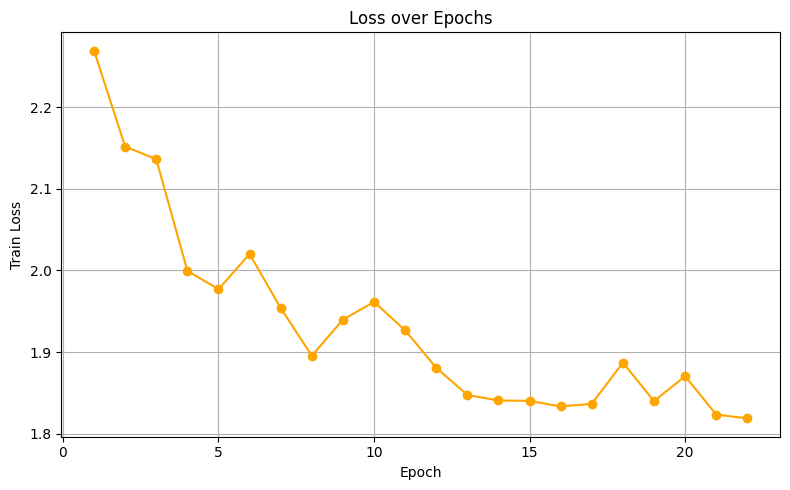

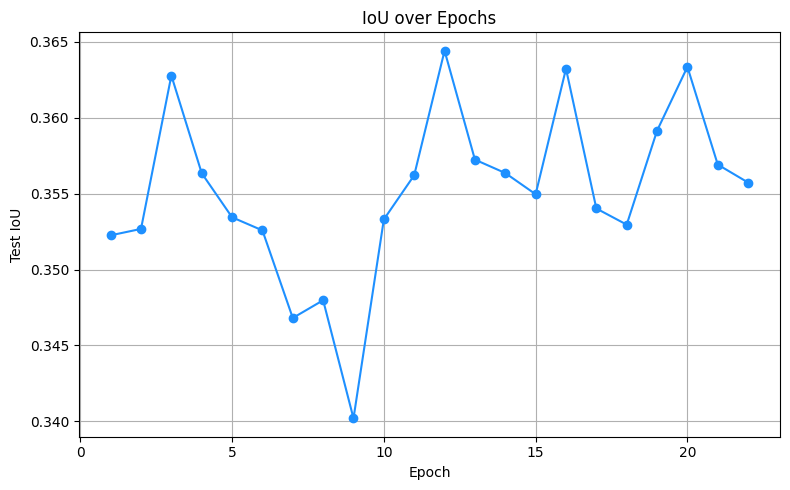

[10/183] Loss: 1.8838 Train Acc: 0.4060
[20/183] Loss: 1.8078 Train Acc: 0.4194
[30/183] Loss: 1.6093 Train Acc: 0.4680
[40/183] Loss: 1.8865 Train Acc: 0.3866
[50/183] Loss: 1.7790 Train Acc: 0.4484
[60/183] Loss: 2.0562 Train Acc: 0.3581
[70/183] Loss: 1.6410 Train Acc: 0.4843
[80/183] Loss: 1.8687 Train Acc: 0.3962
[90/183] Loss: 1.7177 Train Acc: 0.4591
[100/183] Loss: 2.0736 Train Acc: 0.4050
[110/183] Loss: 2.0698 Train Acc: 0.3502
[120/183] Loss: 1.7432 Train Acc: 0.4448
[130/183] Loss: 2.1437 Train Acc: 0.3463
[140/183] Loss: 1.8556 Train Acc: 0.4472
[150/183] Loss: 2.0031 Train Acc: 0.3826
[160/183] Loss: 2.0325 Train Acc: 0.3821
[170/183] Loss: 1.9237 Train Acc: 0.3736
[180/183] Loss: 1.8178 Train Acc: 0.3915
Epoch: 23, Test IoU: 0.3601


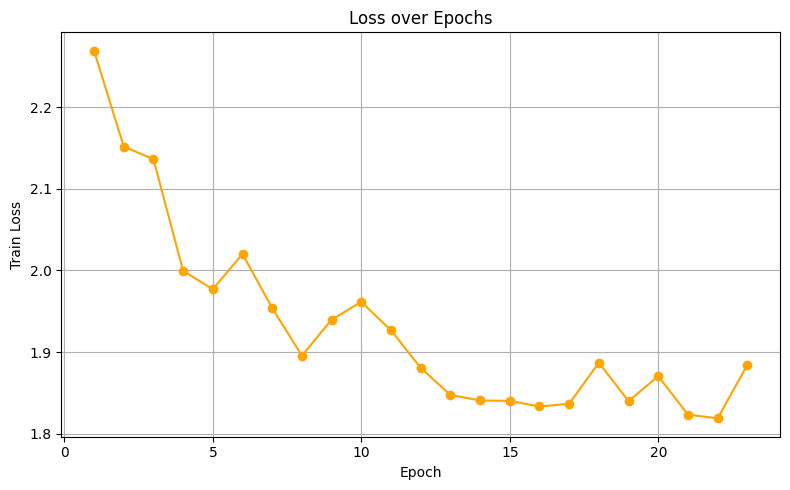

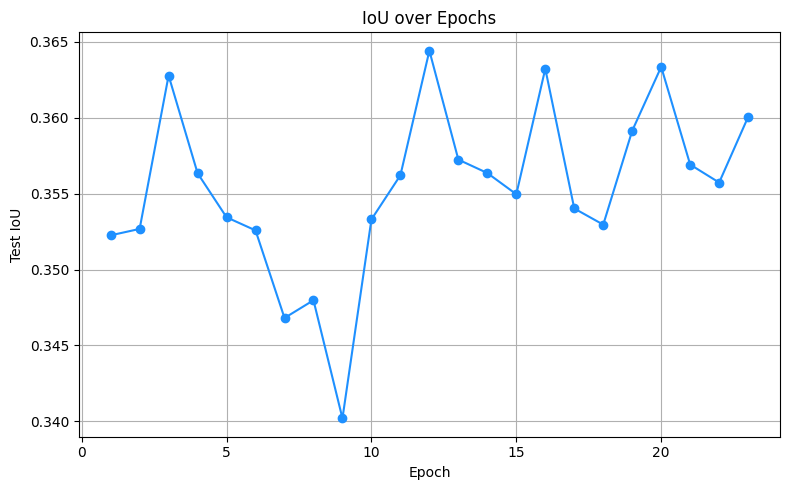

[10/183] Loss: 1.7377 Train Acc: 0.4476
[20/183] Loss: 1.7716 Train Acc: 0.4596
[30/183] Loss: 1.7543 Train Acc: 0.4435
[40/183] Loss: 1.7740 Train Acc: 0.4155
[50/183] Loss: 2.0393 Train Acc: 0.3685
[60/183] Loss: 1.8993 Train Acc: 0.3994
[70/183] Loss: 1.9164 Train Acc: 0.3923
[80/183] Loss: 1.7745 Train Acc: 0.4486
[90/183] Loss: 1.7404 Train Acc: 0.4555
[100/183] Loss: 1.7963 Train Acc: 0.4359
[110/183] Loss: 1.8357 Train Acc: 0.4225
[120/183] Loss: 1.7808 Train Acc: 0.4369
[130/183] Loss: 1.5357 Train Acc: 0.5031
[140/183] Loss: 1.8953 Train Acc: 0.3856
[150/183] Loss: 1.9048 Train Acc: 0.4161
[160/183] Loss: 1.8754 Train Acc: 0.3726
[170/183] Loss: 1.5947 Train Acc: 0.4767
[180/183] Loss: 1.8015 Train Acc: 0.4181
Epoch: 24, Test IoU: 0.3637


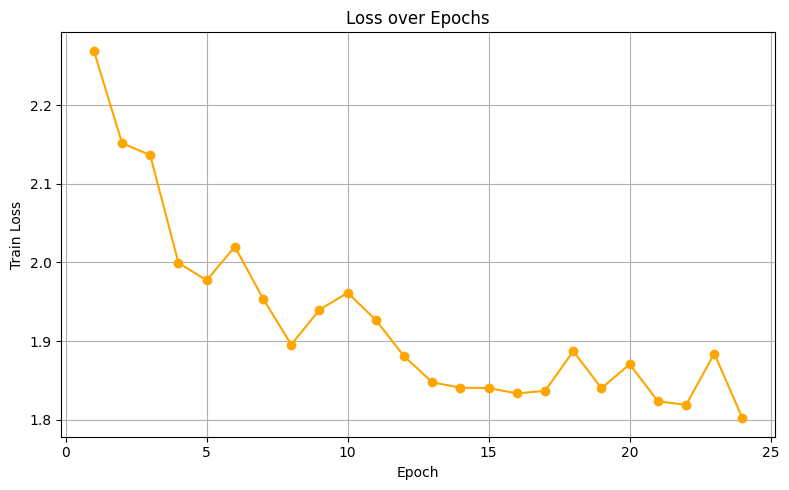

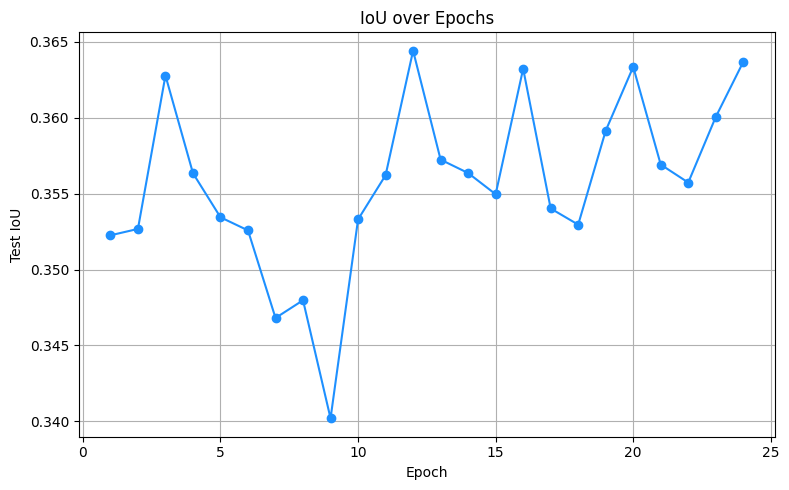

[10/183] Loss: 1.8853 Train Acc: 0.4181
[20/183] Loss: 2.2000 Train Acc: 0.3519
[30/183] Loss: 2.1266 Train Acc: 0.3804
[40/183] Loss: 1.8531 Train Acc: 0.4244
[50/183] Loss: 1.9951 Train Acc: 0.4007
[60/183] Loss: 1.8185 Train Acc: 0.4163
[70/183] Loss: 1.8817 Train Acc: 0.3956
[80/183] Loss: 1.8087 Train Acc: 0.4248
[90/183] Loss: 1.8611 Train Acc: 0.3710
[100/183] Loss: 1.7820 Train Acc: 0.4176
[110/183] Loss: 1.7726 Train Acc: 0.4435
[120/183] Loss: 1.8561 Train Acc: 0.4369
[130/183] Loss: 1.8558 Train Acc: 0.3788
[140/183] Loss: 1.5557 Train Acc: 0.4713
[150/183] Loss: 1.7921 Train Acc: 0.4168
[160/183] Loss: 1.7008 Train Acc: 0.4200
[170/183] Loss: 1.8012 Train Acc: 0.4027
[180/183] Loss: 1.7202 Train Acc: 0.4302
Epoch: 25, Test IoU: 0.3560


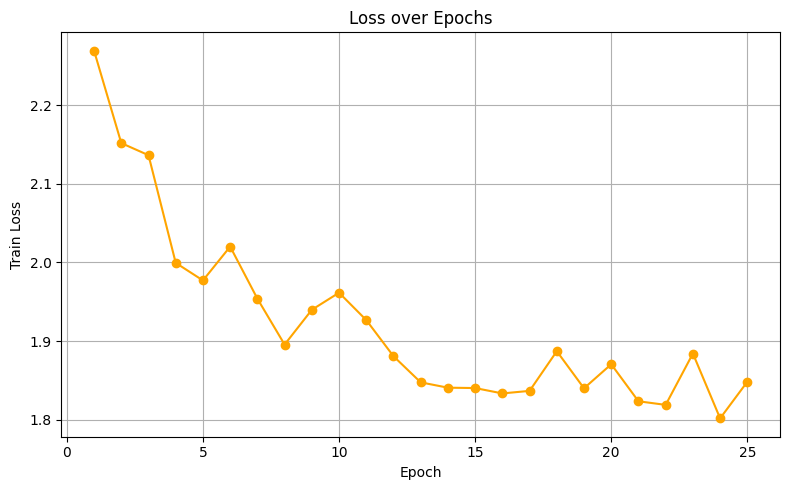

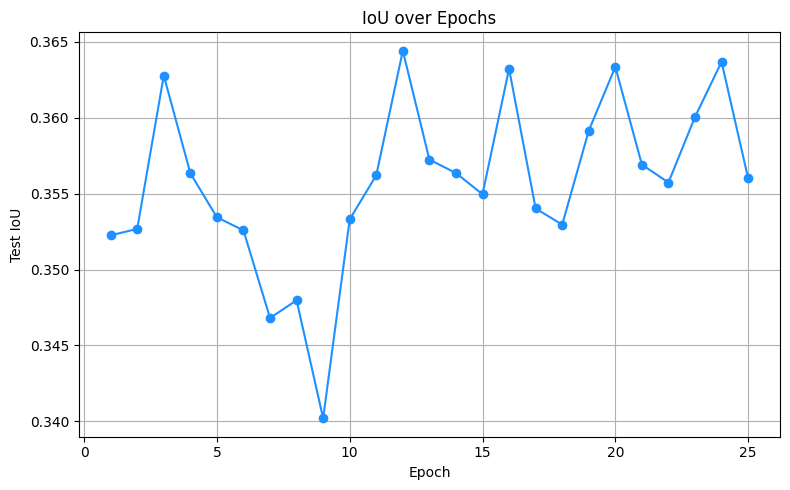

[10/183] Loss: 1.7782 Train Acc: 0.4160
[20/183] Loss: 1.5955 Train Acc: 0.4508
[30/183] Loss: 1.7629 Train Acc: 0.4405
[40/183] Loss: 1.7661 Train Acc: 0.4053
[50/183] Loss: 1.7524 Train Acc: 0.4017
[60/183] Loss: 1.6500 Train Acc: 0.4552
[70/183] Loss: 1.8232 Train Acc: 0.4170
[80/183] Loss: 1.6273 Train Acc: 0.4872
[90/183] Loss: 1.7642 Train Acc: 0.4347
[100/183] Loss: 1.8572 Train Acc: 0.3868
[110/183] Loss: 1.6155 Train Acc: 0.4515
[120/183] Loss: 1.7065 Train Acc: 0.4489
[130/183] Loss: 1.9295 Train Acc: 0.3703
[140/183] Loss: 1.8118 Train Acc: 0.4361
[150/183] Loss: 1.6655 Train Acc: 0.4866
[160/183] Loss: 1.8368 Train Acc: 0.4153
[170/183] Loss: 1.7469 Train Acc: 0.4481
[180/183] Loss: 2.0384 Train Acc: 0.3754
Epoch: 26, Test IoU: 0.3589


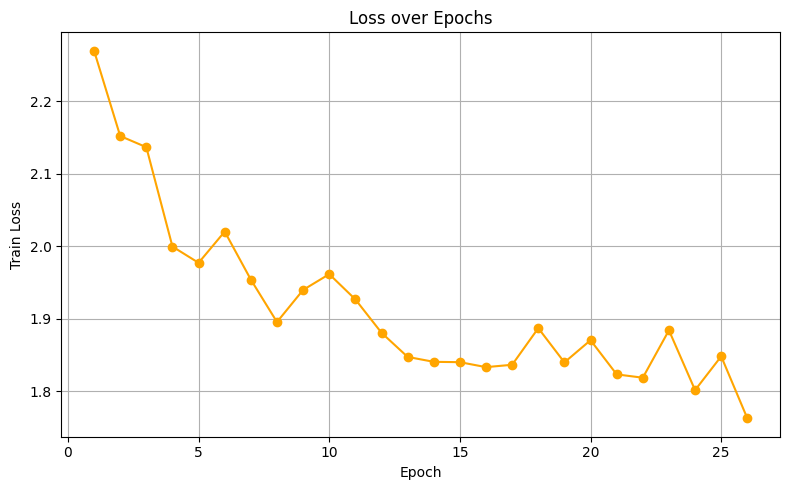

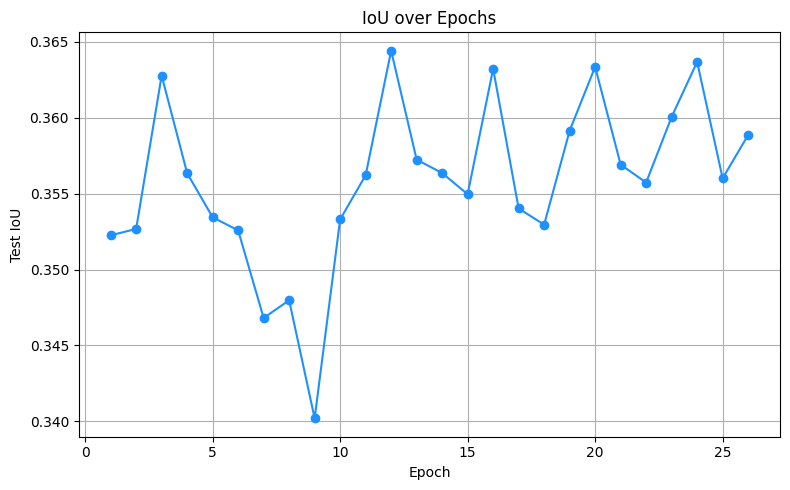

[10/183] Loss: 1.9901 Train Acc: 0.3562
[20/183] Loss: 1.8008 Train Acc: 0.4510
[30/183] Loss: 1.7956 Train Acc: 0.4231
[40/183] Loss: 1.8460 Train Acc: 0.3800
[50/183] Loss: 1.7650 Train Acc: 0.4274
[60/183] Loss: 1.7625 Train Acc: 0.4459
[70/183] Loss: 2.0352 Train Acc: 0.3445
[80/183] Loss: 1.6820 Train Acc: 0.4564
[90/183] Loss: 1.6749 Train Acc: 0.4680
[100/183] Loss: 1.6708 Train Acc: 0.4611
[110/183] Loss: 1.8727 Train Acc: 0.4505
[120/183] Loss: 2.1005 Train Acc: 0.3652
[130/183] Loss: 1.9285 Train Acc: 0.4069
[140/183] Loss: 1.6862 Train Acc: 0.4634
[150/183] Loss: 1.8229 Train Acc: 0.4033
[160/183] Loss: 1.9015 Train Acc: 0.3967
[170/183] Loss: 1.7091 Train Acc: 0.4525
[180/183] Loss: 1.7643 Train Acc: 0.4572
Epoch: 27, Test IoU: 0.3561


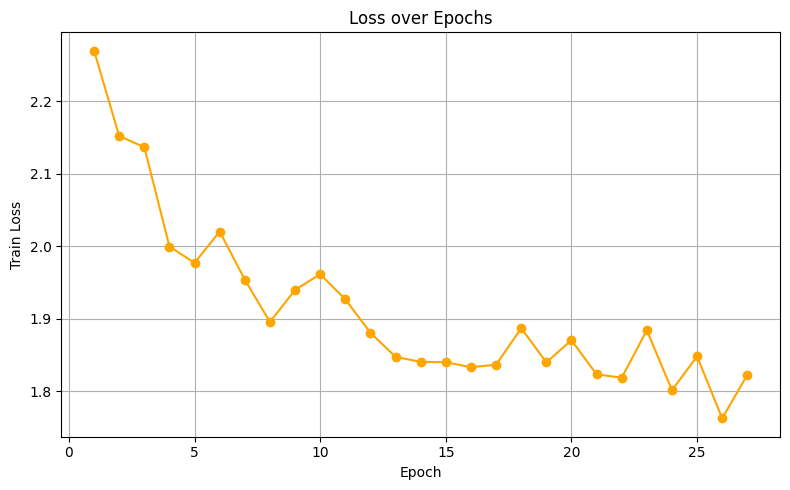

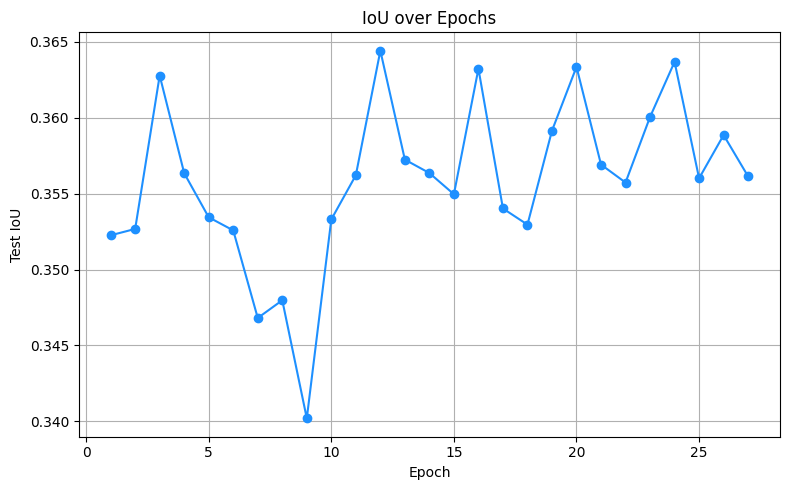

[10/183] Loss: 1.7314 Train Acc: 0.4148
[20/183] Loss: 1.6618 Train Acc: 0.4716
[30/183] Loss: 1.6761 Train Acc: 0.4611
[40/183] Loss: 1.8447 Train Acc: 0.4097
[50/183] Loss: 1.7786 Train Acc: 0.4005
[60/183] Loss: 1.7183 Train Acc: 0.4253
[70/183] Loss: 1.7649 Train Acc: 0.4453
[80/183] Loss: 1.7738 Train Acc: 0.4175
[90/183] Loss: 1.7081 Train Acc: 0.4353
[100/183] Loss: 1.6431 Train Acc: 0.4207
[110/183] Loss: 1.8195 Train Acc: 0.3793
[120/183] Loss: 1.6118 Train Acc: 0.4760
[130/183] Loss: 1.8892 Train Acc: 0.4316
[140/183] Loss: 1.7561 Train Acc: 0.4532
[150/183] Loss: 1.6128 Train Acc: 0.4887
[160/183] Loss: 1.7265 Train Acc: 0.4393
[170/183] Loss: 1.8207 Train Acc: 0.4298
[180/183] Loss: 1.8364 Train Acc: 0.4305
Epoch: 28, Test IoU: 0.3569


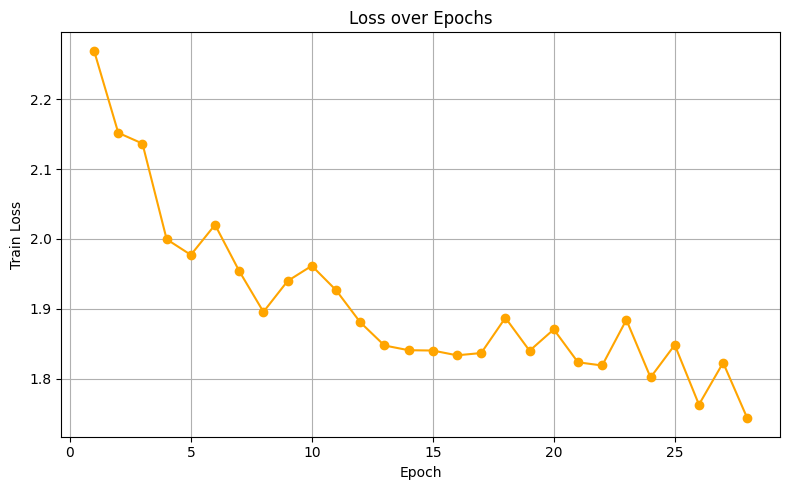

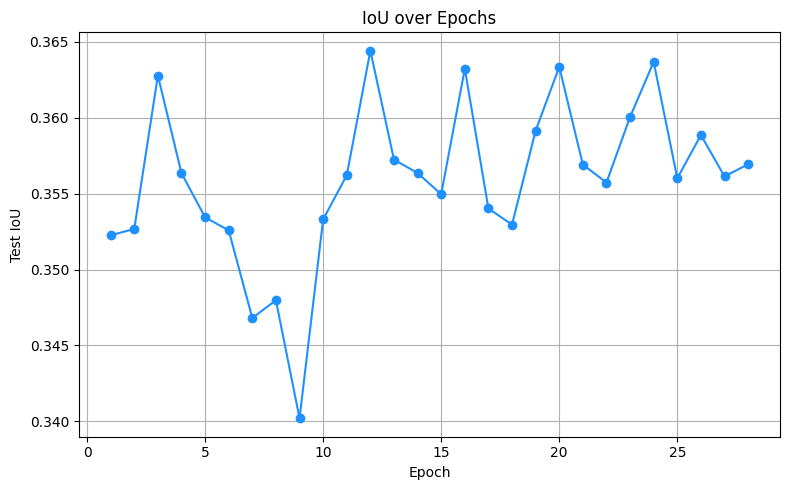

[10/183] Loss: 1.8409 Train Acc: 0.3973
[20/183] Loss: 1.6543 Train Acc: 0.4732
[30/183] Loss: 1.6458 Train Acc: 0.4986
[40/183] Loss: 1.5765 Train Acc: 0.4727
[50/183] Loss: 1.5722 Train Acc: 0.4988
[60/183] Loss: 1.6803 Train Acc: 0.4519
[70/183] Loss: 1.7368 Train Acc: 0.4202
[80/183] Loss: 1.5497 Train Acc: 0.4885
[90/183] Loss: 1.7508 Train Acc: 0.3957
[100/183] Loss: 1.9128 Train Acc: 0.4318
[110/183] Loss: 1.9463 Train Acc: 0.4155
[120/183] Loss: 1.8974 Train Acc: 0.3825
[130/183] Loss: 1.7005 Train Acc: 0.4733
[140/183] Loss: 1.8924 Train Acc: 0.3966
[150/183] Loss: 1.8692 Train Acc: 0.4002
[160/183] Loss: 1.8913 Train Acc: 0.3754
[170/183] Loss: 1.9037 Train Acc: 0.4037
[180/183] Loss: 1.7007 Train Acc: 0.4470
Epoch: 29, Test IoU: 0.3568


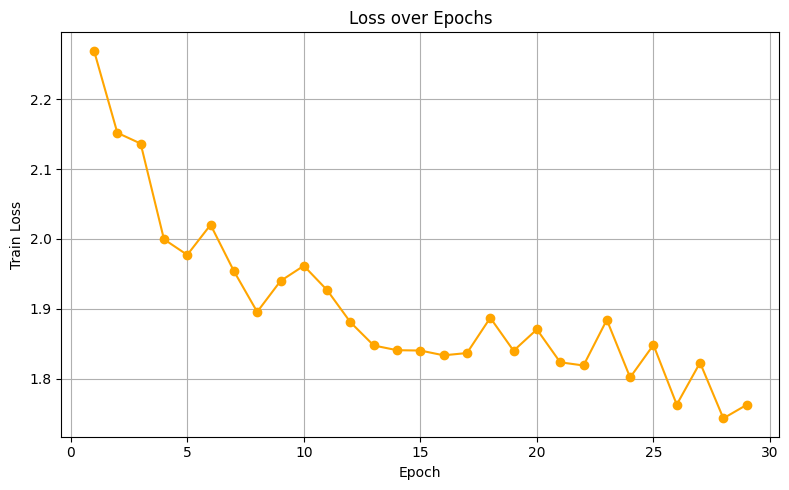

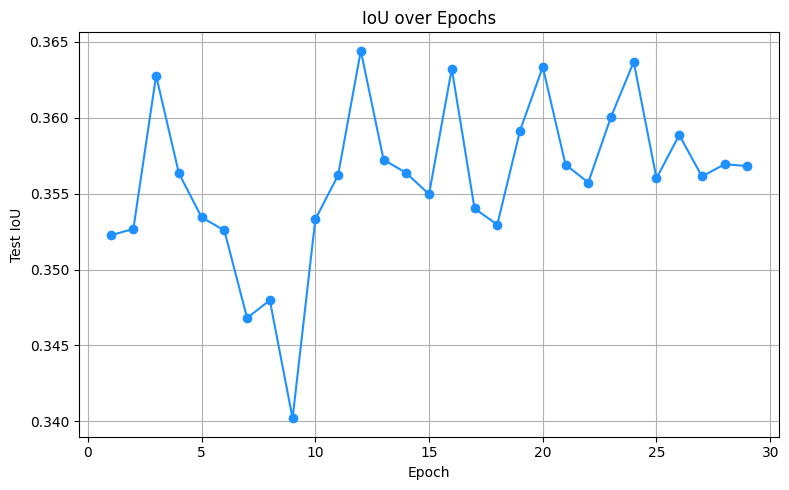

[10/183] Loss: 1.7474 Train Acc: 0.4019
[20/183] Loss: 1.8806 Train Acc: 0.3788
[30/183] Loss: 1.5836 Train Acc: 0.4553
[40/183] Loss: 1.7931 Train Acc: 0.4372
[50/183] Loss: 1.7184 Train Acc: 0.4473
[60/183] Loss: 1.7087 Train Acc: 0.4283
[70/183] Loss: 1.7656 Train Acc: 0.4592
[80/183] Loss: 1.6673 Train Acc: 0.4512
[90/183] Loss: 1.7371 Train Acc: 0.4518
[100/183] Loss: 1.6586 Train Acc: 0.4647
[110/183] Loss: 1.7439 Train Acc: 0.4535
[120/183] Loss: 1.8210 Train Acc: 0.4265
[130/183] Loss: 1.6522 Train Acc: 0.4512
[140/183] Loss: 1.7228 Train Acc: 0.4420
[150/183] Loss: 1.7574 Train Acc: 0.4543
[160/183] Loss: 1.7305 Train Acc: 0.4346
[170/183] Loss: 1.9452 Train Acc: 0.3615
[180/183] Loss: 1.6695 Train Acc: 0.4293
Epoch: 30, Test IoU: 0.3574


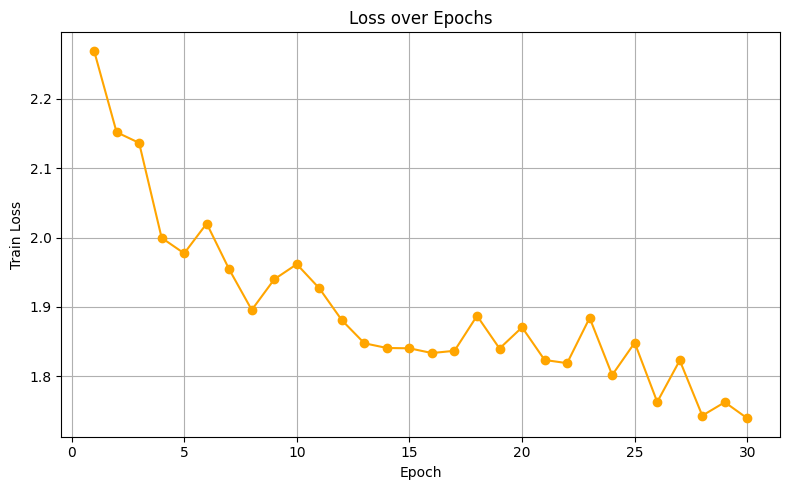

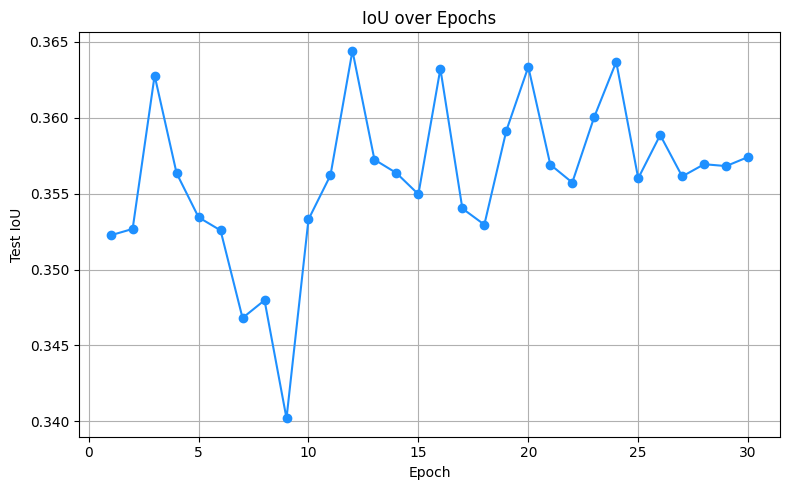

[10/183] Loss: 1.5765 Train Acc: 0.4865
[20/183] Loss: 1.6061 Train Acc: 0.4566
[30/183] Loss: 1.8140 Train Acc: 0.3843
[40/183] Loss: 1.6812 Train Acc: 0.4559
[50/183] Loss: 1.6431 Train Acc: 0.4585
[60/183] Loss: 1.7479 Train Acc: 0.4473
[70/183] Loss: 1.6734 Train Acc: 0.4659
[80/183] Loss: 1.6004 Train Acc: 0.4745
[90/183] Loss: 1.7734 Train Acc: 0.4248
[100/183] Loss: 1.8683 Train Acc: 0.4012
[110/183] Loss: 1.5426 Train Acc: 0.5042
[120/183] Loss: 1.6362 Train Acc: 0.4503
[130/183] Loss: 1.6696 Train Acc: 0.4359
[140/183] Loss: 1.7543 Train Acc: 0.4151
[150/183] Loss: 1.8742 Train Acc: 0.4029
[160/183] Loss: 1.8755 Train Acc: 0.3700
[170/183] Loss: 1.8112 Train Acc: 0.4281
[180/183] Loss: 1.5966 Train Acc: 0.4999
Epoch: 31, Test IoU: 0.3629


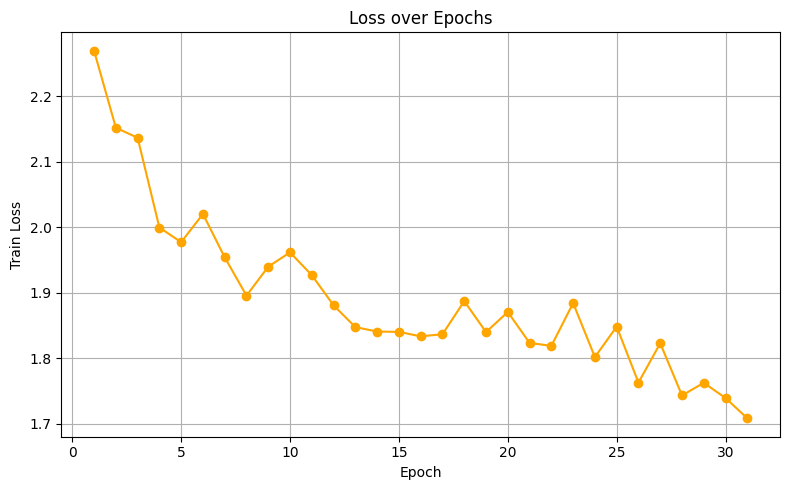

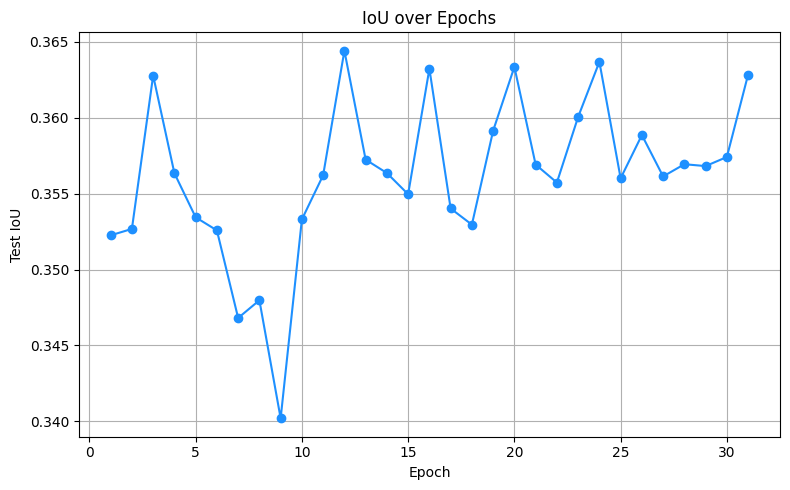

[10/183] Loss: 1.6158 Train Acc: 0.4911
[20/183] Loss: 1.8261 Train Acc: 0.4178
[30/183] Loss: 1.8151 Train Acc: 0.4086
[40/183] Loss: 1.8092 Train Acc: 0.4131
[50/183] Loss: 1.6352 Train Acc: 0.4545
[60/183] Loss: 1.5865 Train Acc: 0.4160
[70/183] Loss: 1.7613 Train Acc: 0.4382
[80/183] Loss: 1.6352 Train Acc: 0.4554
[90/183] Loss: 1.8850 Train Acc: 0.4019
[100/183] Loss: 1.9768 Train Acc: 0.3941
[110/183] Loss: 1.6541 Train Acc: 0.4701
[120/183] Loss: 1.7487 Train Acc: 0.4363
[130/183] Loss: 1.7361 Train Acc: 0.4434
[140/183] Loss: 1.6367 Train Acc: 0.4764
[150/183] Loss: 1.6335 Train Acc: 0.4498
[160/183] Loss: 1.5808 Train Acc: 0.5006
[170/183] Loss: 1.6976 Train Acc: 0.4469
[180/183] Loss: 1.5948 Train Acc: 0.5031
Epoch: 32, Test IoU: 0.3700


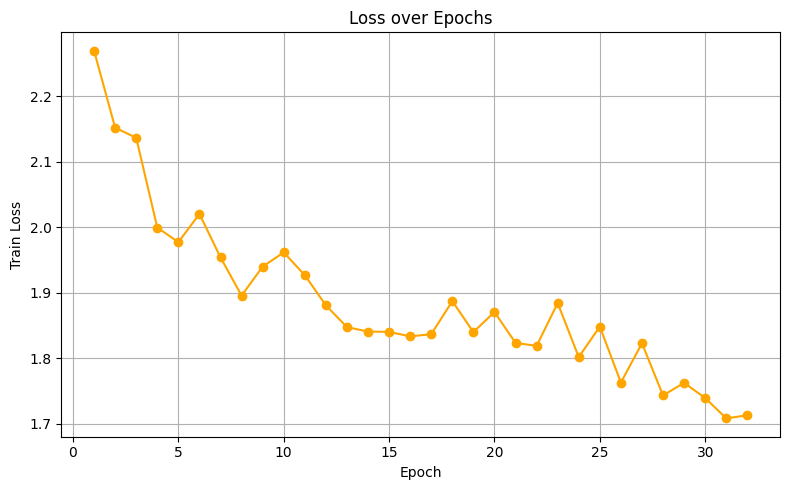

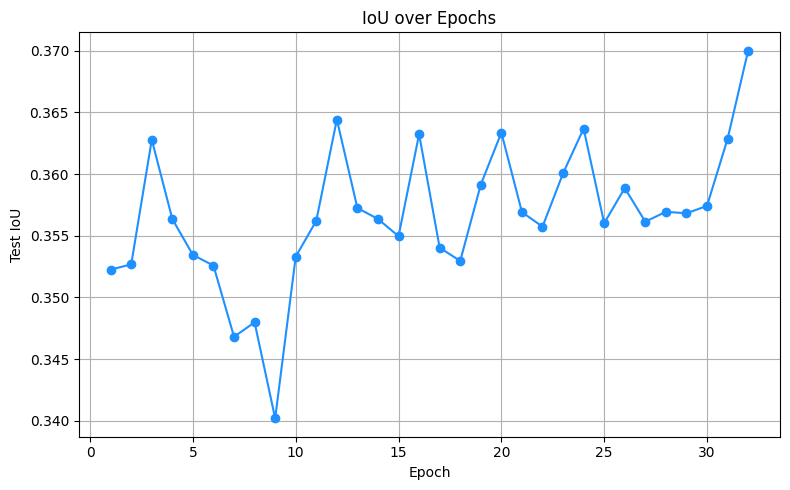

  >> Best model saved at epoch 32 with IoU: 0.3700
[10/183] Loss: 1.6239 Train Acc: 0.4530
[20/183] Loss: 1.6470 Train Acc: 0.4436
[30/183] Loss: 1.8465 Train Acc: 0.4097
[40/183] Loss: 1.8538 Train Acc: 0.4070
[50/183] Loss: 1.6302 Train Acc: 0.4714
[60/183] Loss: 1.9409 Train Acc: 0.4287
[70/183] Loss: 1.7123 Train Acc: 0.4224
[80/183] Loss: 1.7159 Train Acc: 0.4163
[90/183] Loss: 1.5305 Train Acc: 0.5094
[100/183] Loss: 1.9976 Train Acc: 0.4022
[110/183] Loss: 1.8409 Train Acc: 0.4254
[120/183] Loss: 1.7628 Train Acc: 0.4655
[130/183] Loss: 1.7185 Train Acc: 0.4204
[140/183] Loss: 1.8943 Train Acc: 0.4000
[150/183] Loss: 1.5899 Train Acc: 0.4918
[160/183] Loss: 1.7861 Train Acc: 0.4345
[170/183] Loss: 1.6964 Train Acc: 0.4536
[180/183] Loss: 1.4937 Train Acc: 0.5165
Epoch: 33, Test IoU: 0.3620


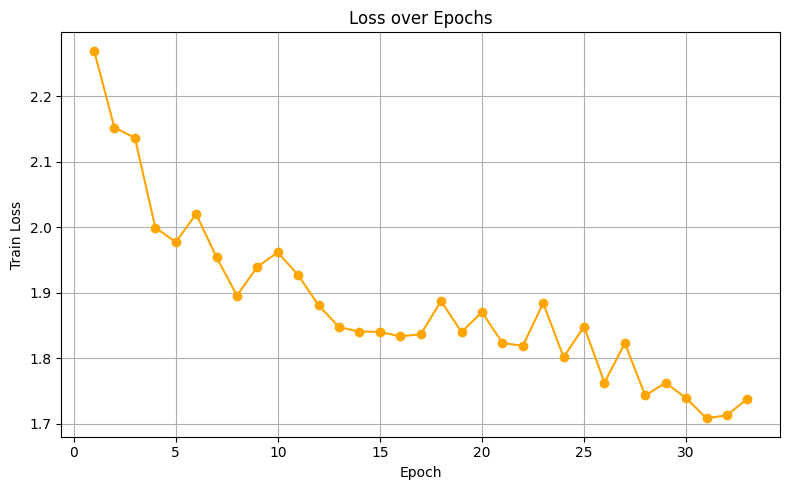

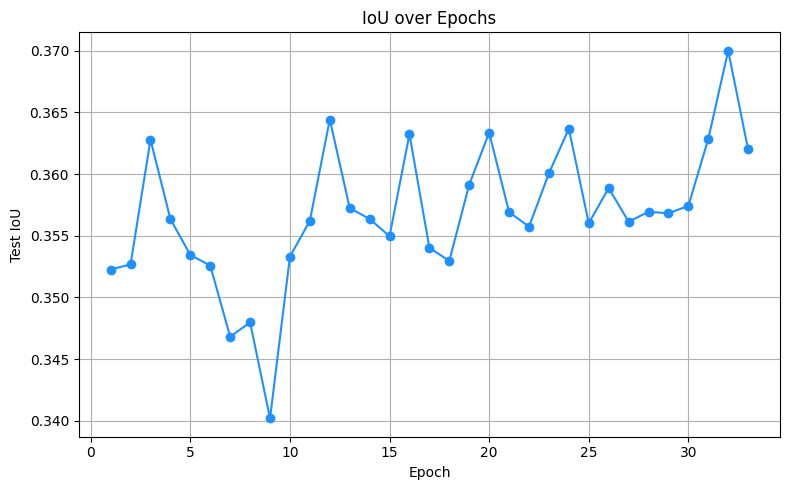

[10/183] Loss: 1.6550 Train Acc: 0.4515
[20/183] Loss: 1.7280 Train Acc: 0.4428
[30/183] Loss: 1.8426 Train Acc: 0.4131
[40/183] Loss: 1.5841 Train Acc: 0.4987
[50/183] Loss: 1.7086 Train Acc: 0.4683
[60/183] Loss: 1.7624 Train Acc: 0.4336
[70/183] Loss: 1.6764 Train Acc: 0.4202
[80/183] Loss: 1.6783 Train Acc: 0.4425
[90/183] Loss: 1.5630 Train Acc: 0.4898
[100/183] Loss: 1.8172 Train Acc: 0.3970
[110/183] Loss: 1.4540 Train Acc: 0.4865
[120/183] Loss: 1.5952 Train Acc: 0.4494
[130/183] Loss: 1.8639 Train Acc: 0.4313
[140/183] Loss: 1.4986 Train Acc: 0.4861
[150/183] Loss: 1.6925 Train Acc: 0.4273
[160/183] Loss: 1.6505 Train Acc: 0.4607
[170/183] Loss: 1.7915 Train Acc: 0.4126
[180/183] Loss: 1.6054 Train Acc: 0.4750
Epoch: 34, Test IoU: 0.3620


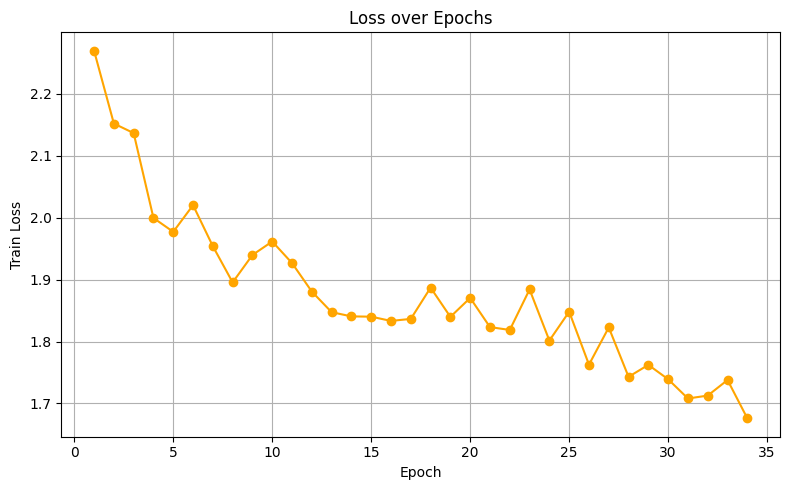

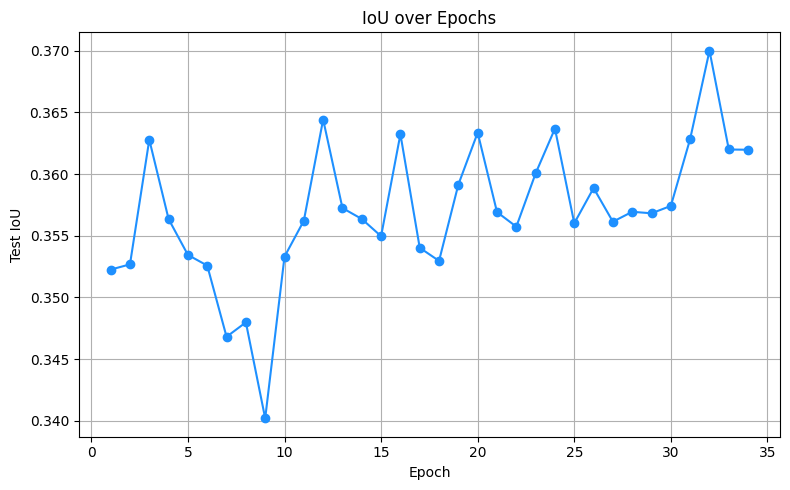

[10/183] Loss: 1.6605 Train Acc: 0.4536
[20/183] Loss: 1.5136 Train Acc: 0.4946
[30/183] Loss: 1.6268 Train Acc: 0.4955
[40/183] Loss: 1.8622 Train Acc: 0.3855
[50/183] Loss: 1.7032 Train Acc: 0.4235
[60/183] Loss: 1.7187 Train Acc: 0.4515
[70/183] Loss: 1.6982 Train Acc: 0.4480
[80/183] Loss: 1.4831 Train Acc: 0.4718
[90/183] Loss: 1.6390 Train Acc: 0.4902
[100/183] Loss: 1.8436 Train Acc: 0.4261
[110/183] Loss: 1.6057 Train Acc: 0.4772
[120/183] Loss: 1.5411 Train Acc: 0.4626
[130/183] Loss: 1.9518 Train Acc: 0.4062
[140/183] Loss: 1.6755 Train Acc: 0.4852
[150/183] Loss: 1.6268 Train Acc: 0.4905
[160/183] Loss: 1.8130 Train Acc: 0.4260
[170/183] Loss: 1.8307 Train Acc: 0.4433
[180/183] Loss: 1.9277 Train Acc: 0.3777
Epoch: 35, Test IoU: 0.3626


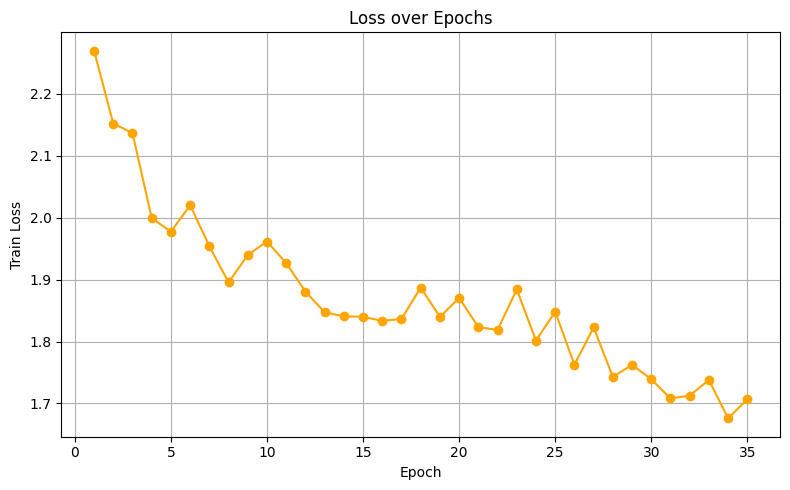

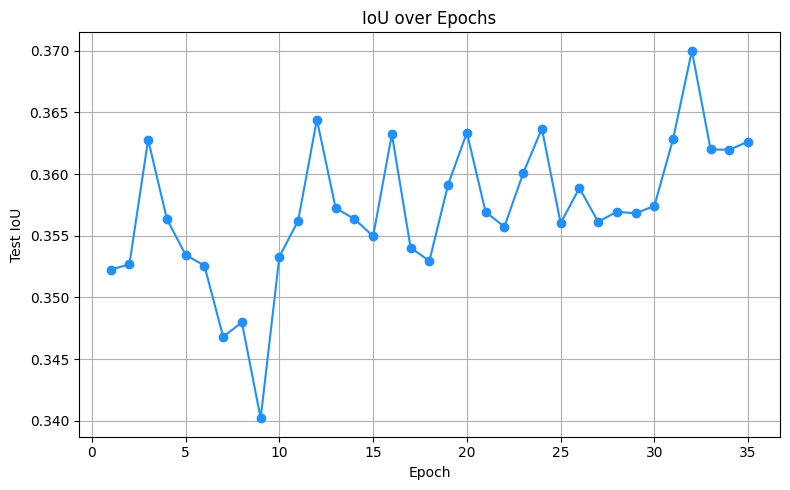

[10/183] Loss: 1.5969 Train Acc: 0.4825
[20/183] Loss: 1.6332 Train Acc: 0.4353
[30/183] Loss: 1.6393 Train Acc: 0.4668
[40/183] Loss: 1.6430 Train Acc: 0.4492
[50/183] Loss: 1.7180 Train Acc: 0.4668
[60/183] Loss: 1.4866 Train Acc: 0.5192
[70/183] Loss: 1.4404 Train Acc: 0.5177
[80/183] Loss: 1.8698 Train Acc: 0.3789
[90/183] Loss: 1.6810 Train Acc: 0.4324
[100/183] Loss: 1.6436 Train Acc: 0.4128
[110/183] Loss: 1.4944 Train Acc: 0.4966
[120/183] Loss: 1.5837 Train Acc: 0.4593
[130/183] Loss: 1.5434 Train Acc: 0.4535
[140/183] Loss: 1.9210 Train Acc: 0.3783
[150/183] Loss: 1.5096 Train Acc: 0.5028
[160/183] Loss: 1.6031 Train Acc: 0.4660
[170/183] Loss: 1.5301 Train Acc: 0.4829
[180/183] Loss: 1.9340 Train Acc: 0.3823
Epoch: 36, Test IoU: 0.3595


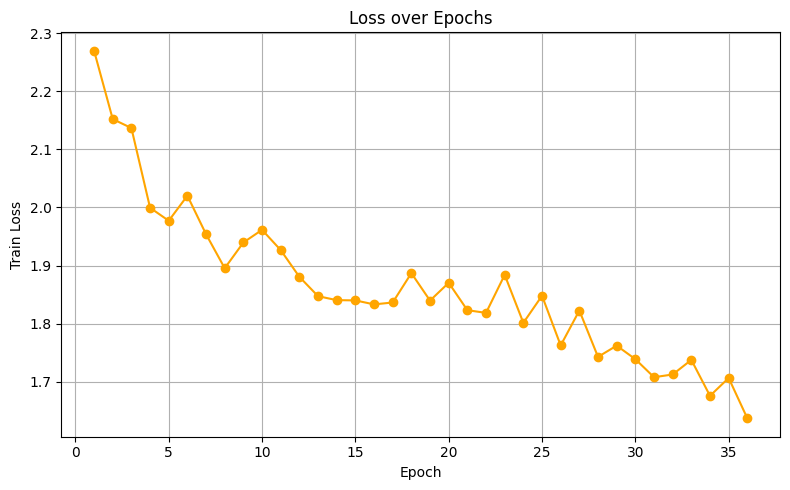

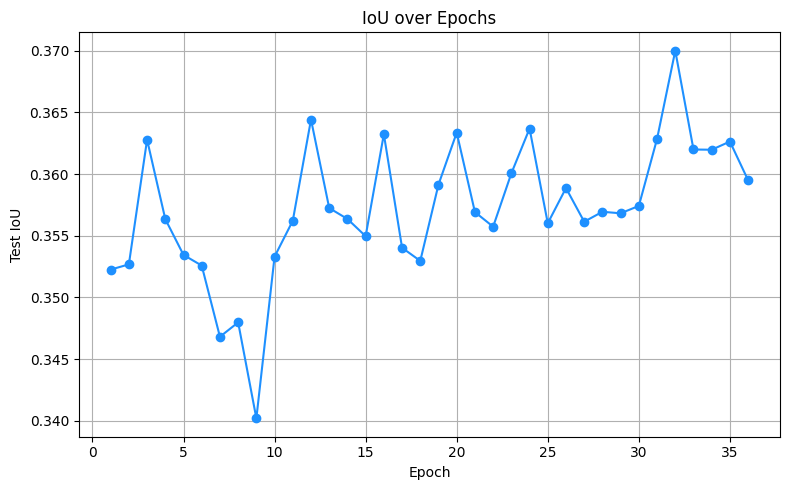

[10/183] Loss: 1.8532 Train Acc: 0.4688
[20/183] Loss: 1.7714 Train Acc: 0.4341
[30/183] Loss: 1.7809 Train Acc: 0.4539
[40/183] Loss: 2.0108 Train Acc: 0.4498
[50/183] Loss: 1.8332 Train Acc: 0.4119
[60/183] Loss: 1.6918 Train Acc: 0.4457
[70/183] Loss: 1.6841 Train Acc: 0.4933
[80/183] Loss: 1.7973 Train Acc: 0.3867
[90/183] Loss: 2.3416 Train Acc: 0.3072
[100/183] Loss: 1.7303 Train Acc: 0.4680
[110/183] Loss: 1.7040 Train Acc: 0.4245
[120/183] Loss: 1.8380 Train Acc: 0.4458
[130/183] Loss: 1.8483 Train Acc: 0.4082
[140/183] Loss: 1.9525 Train Acc: 0.3794
[150/183] Loss: 1.9142 Train Acc: 0.4332
[160/183] Loss: 1.8211 Train Acc: 0.4111
[170/183] Loss: 1.7295 Train Acc: 0.4101
[180/183] Loss: 1.5519 Train Acc: 0.4781
Epoch: 37, Test IoU: 0.3609


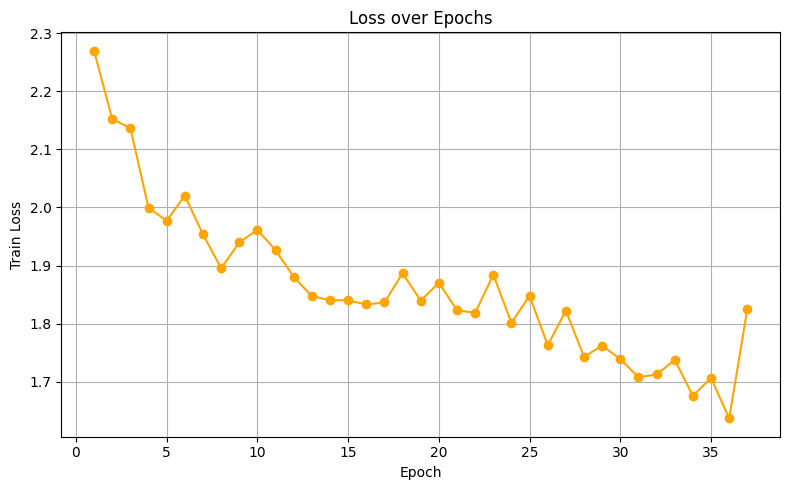

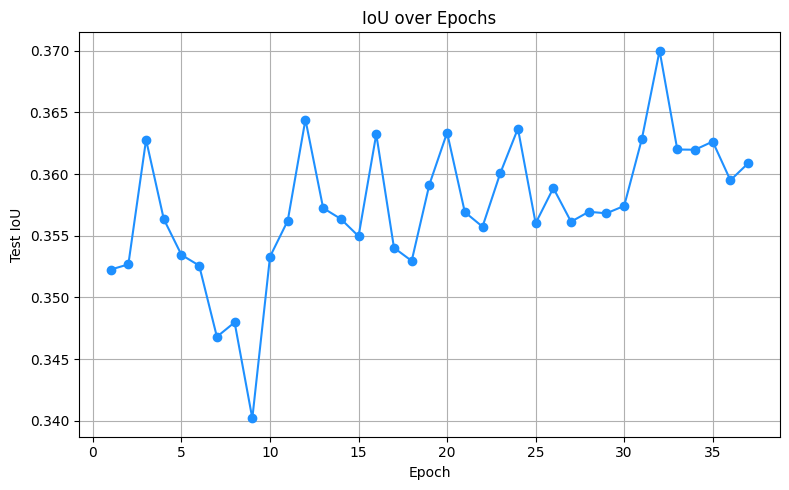

[10/183] Loss: 1.9593 Train Acc: 0.4181
[20/183] Loss: 1.7802 Train Acc: 0.4308
[30/183] Loss: 1.8434 Train Acc: 0.4137
[40/183] Loss: 1.7329 Train Acc: 0.4200
[50/183] Loss: 1.6304 Train Acc: 0.4344
[60/183] Loss: 1.8625 Train Acc: 0.3812
[70/183] Loss: 1.6502 Train Acc: 0.4857
[80/183] Loss: 1.6176 Train Acc: 0.4301
[90/183] Loss: 1.7675 Train Acc: 0.3853
[100/183] Loss: 1.7833 Train Acc: 0.4294
[110/183] Loss: 1.6025 Train Acc: 0.4519
[120/183] Loss: 1.4894 Train Acc: 0.4730
[130/183] Loss: 1.5308 Train Acc: 0.5040
[140/183] Loss: 1.7438 Train Acc: 0.4405
[150/183] Loss: 1.7545 Train Acc: 0.4158
[160/183] Loss: 1.8753 Train Acc: 0.3846
[170/183] Loss: 1.5685 Train Acc: 0.4639
[180/183] Loss: 1.5096 Train Acc: 0.4919
Epoch: 38, Test IoU: 0.3637


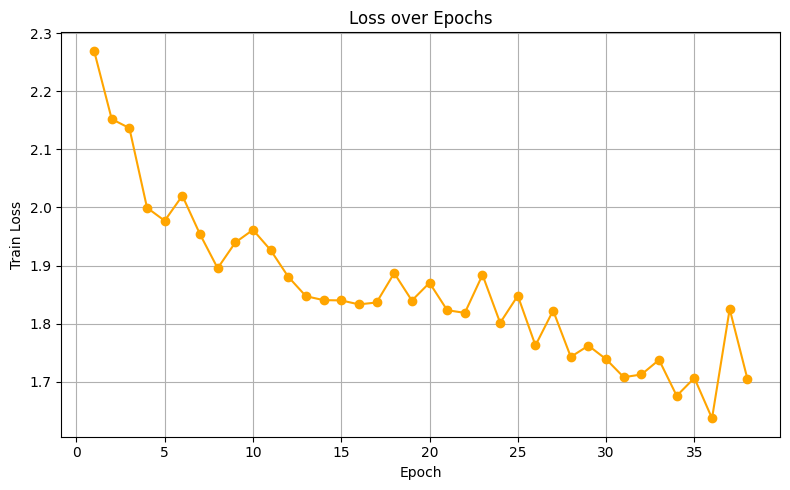

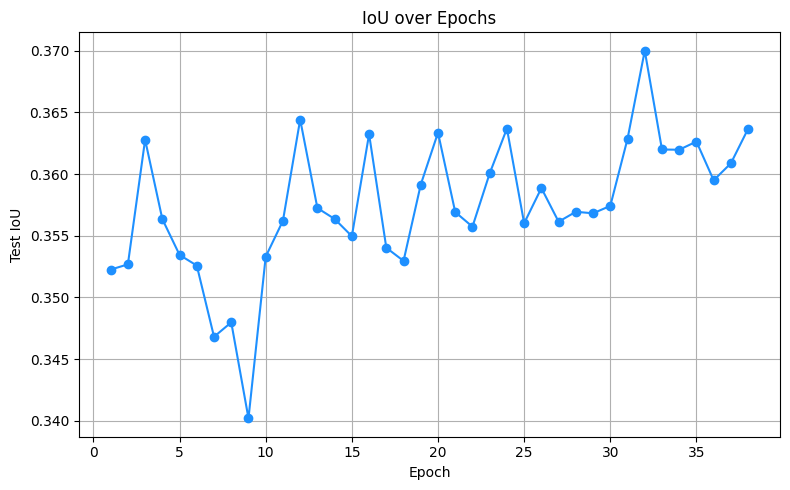

[10/183] Loss: 1.5501 Train Acc: 0.4401
[20/183] Loss: 1.6626 Train Acc: 0.4496
[30/183] Loss: 1.6626 Train Acc: 0.4483
[40/183] Loss: 1.6988 Train Acc: 0.4697
[50/183] Loss: 1.7527 Train Acc: 0.3945
[60/183] Loss: 1.6654 Train Acc: 0.4519
[70/183] Loss: 1.5028 Train Acc: 0.4859
[80/183] Loss: 1.3545 Train Acc: 0.5204
[90/183] Loss: 1.9317 Train Acc: 0.4354
[100/183] Loss: 1.8465 Train Acc: 0.4064
[110/183] Loss: 1.7614 Train Acc: 0.3949
[120/183] Loss: 2.0640 Train Acc: 0.4397
[130/183] Loss: 1.6239 Train Acc: 0.4882
[140/183] Loss: 1.6037 Train Acc: 0.4871
[150/183] Loss: 1.6976 Train Acc: 0.4537
[160/183] Loss: 1.6776 Train Acc: 0.4230
[170/183] Loss: 1.4978 Train Acc: 0.4878
[180/183] Loss: 1.6691 Train Acc: 0.4558
Epoch: 39, Test IoU: 0.3644


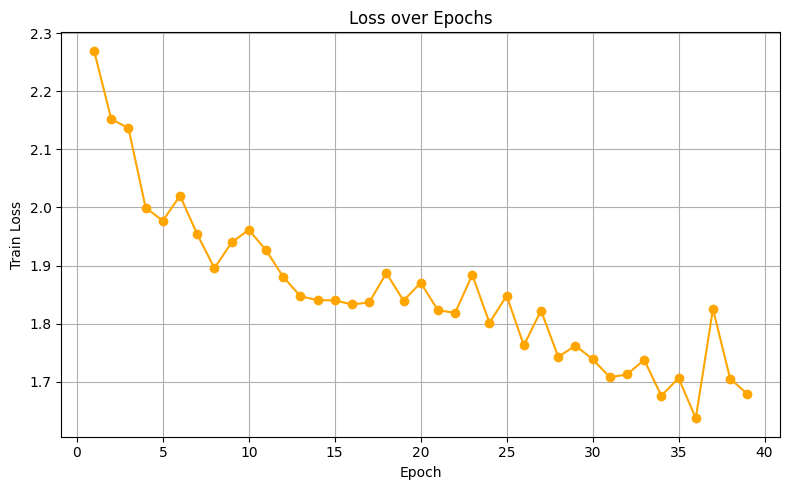

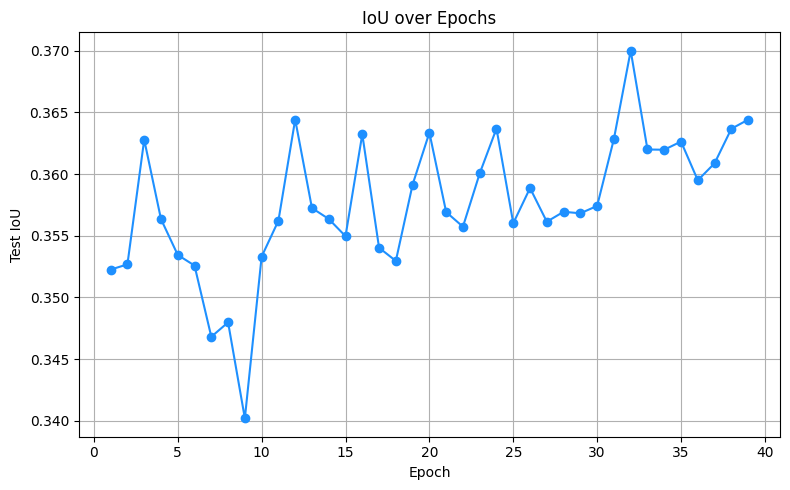

[10/183] Loss: 1.5540 Train Acc: 0.4737
[20/183] Loss: 1.5964 Train Acc: 0.4817
[30/183] Loss: 1.6317 Train Acc: 0.5049
[40/183] Loss: 1.6977 Train Acc: 0.4511
[50/183] Loss: 1.8409 Train Acc: 0.4136
[60/183] Loss: 1.6865 Train Acc: 0.4490
[70/183] Loss: 1.8291 Train Acc: 0.4077
[80/183] Loss: 1.4584 Train Acc: 0.5204
[90/183] Loss: 1.5214 Train Acc: 0.4916
[100/183] Loss: 1.7467 Train Acc: 0.4398
[110/183] Loss: 1.7372 Train Acc: 0.4118
[120/183] Loss: 1.4940 Train Acc: 0.4669
[130/183] Loss: 1.6798 Train Acc: 0.4563
[140/183] Loss: 1.6149 Train Acc: 0.4485
[150/183] Loss: 1.9162 Train Acc: 0.3777
[160/183] Loss: 1.5773 Train Acc: 0.4773
[170/183] Loss: 1.7825 Train Acc: 0.4561
[180/183] Loss: 1.7581 Train Acc: 0.4479
Epoch: 40, Test IoU: 0.3629


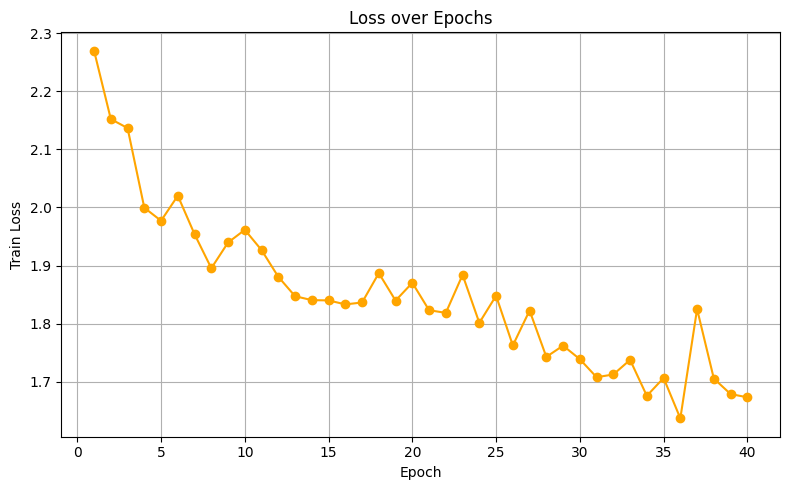

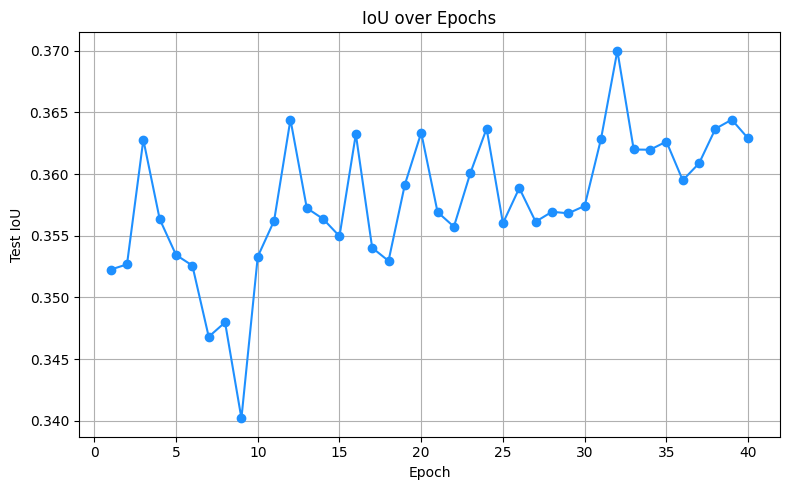

[10/183] Loss: 1.6277 Train Acc: 0.4543
[20/183] Loss: 1.8121 Train Acc: 0.4189
[30/183] Loss: 1.8196 Train Acc: 0.4115
[40/183] Loss: 1.6941 Train Acc: 0.4501
[50/183] Loss: 1.5661 Train Acc: 0.4698
[60/183] Loss: 1.8241 Train Acc: 0.3877
[70/183] Loss: 1.5284 Train Acc: 0.4820
[80/183] Loss: 1.6478 Train Acc: 0.4119
[90/183] Loss: 1.6610 Train Acc: 0.4417
[100/183] Loss: 1.6079 Train Acc: 0.4215
[110/183] Loss: 1.6033 Train Acc: 0.4657
[120/183] Loss: 1.3497 Train Acc: 0.5382
[130/183] Loss: 1.6645 Train Acc: 0.4864
[140/183] Loss: 1.5917 Train Acc: 0.4647
[150/183] Loss: 1.4827 Train Acc: 0.4942
[160/183] Loss: 1.5032 Train Acc: 0.4746
[170/183] Loss: 1.7308 Train Acc: 0.4486
[180/183] Loss: 1.6919 Train Acc: 0.4324
Epoch: 41, Test IoU: 0.3619


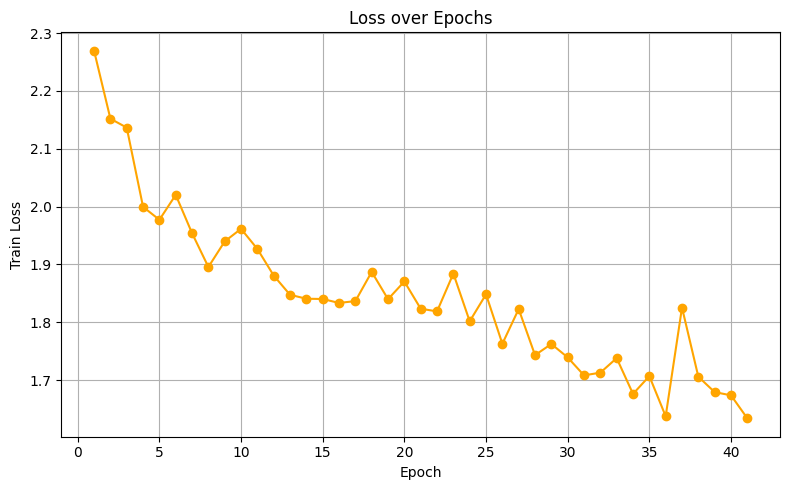

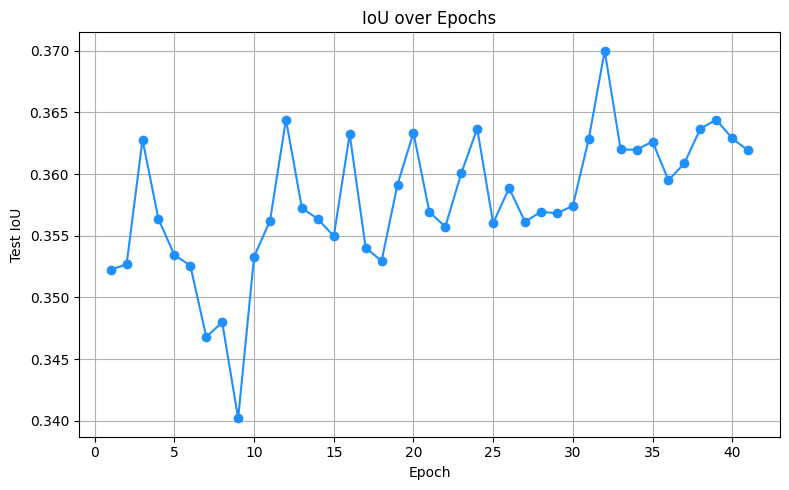

[10/183] Loss: 1.8311 Train Acc: 0.4149
[20/183] Loss: 1.8154 Train Acc: 0.4197
[30/183] Loss: 1.5799 Train Acc: 0.5227
[40/183] Loss: 1.6409 Train Acc: 0.4267
[50/183] Loss: 1.9075 Train Acc: 0.3599
[60/183] Loss: 1.6544 Train Acc: 0.4374
[70/183] Loss: 2.2695 Train Acc: 0.3911
[80/183] Loss: 1.6905 Train Acc: 0.4536
[90/183] Loss: 1.6673 Train Acc: 0.4520
[100/183] Loss: 1.6966 Train Acc: 0.4448
[110/183] Loss: 1.7322 Train Acc: 0.4705
[120/183] Loss: 1.4869 Train Acc: 0.4945
[130/183] Loss: 1.5911 Train Acc: 0.4787
[140/183] Loss: 1.6665 Train Acc: 0.4330
[150/183] Loss: 1.5818 Train Acc: 0.4493
[160/183] Loss: 1.5550 Train Acc: 0.4817
[170/183] Loss: 1.4108 Train Acc: 0.5090
[180/183] Loss: 1.7303 Train Acc: 0.4443
Epoch: 42, Test IoU: 0.3641


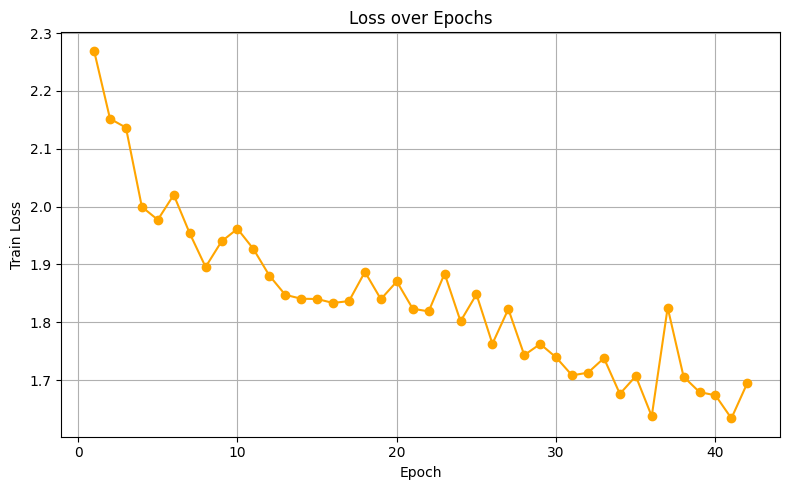

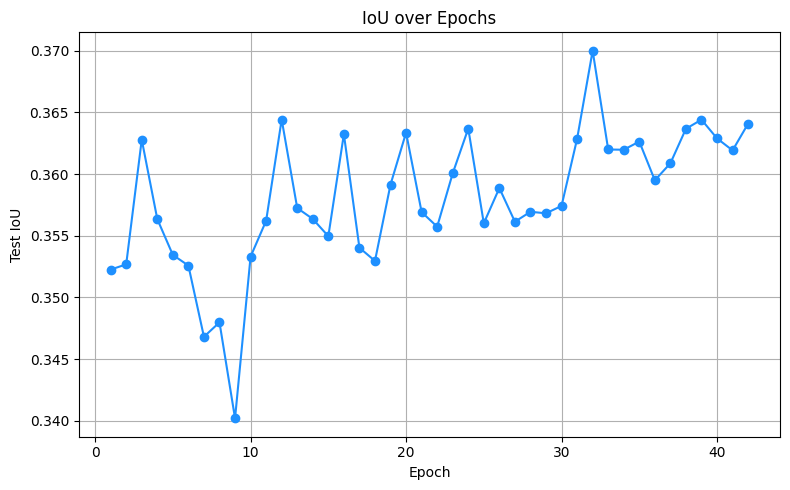

[10/183] Loss: 1.5175 Train Acc: 0.4726
[20/183] Loss: 1.4017 Train Acc: 0.5038
[30/183] Loss: 1.8444 Train Acc: 0.4434
[40/183] Loss: 1.8635 Train Acc: 0.4131
[50/183] Loss: 1.5028 Train Acc: 0.4884
[60/183] Loss: 1.5369 Train Acc: 0.4685
[70/183] Loss: 1.5264 Train Acc: 0.4982
[80/183] Loss: 1.6050 Train Acc: 0.4700
[90/183] Loss: 1.5590 Train Acc: 0.4571
[100/183] Loss: 1.6205 Train Acc: 0.4706
[110/183] Loss: 1.5346 Train Acc: 0.5168
[120/183] Loss: 1.7122 Train Acc: 0.4437
[130/183] Loss: 1.6875 Train Acc: 0.4346
[140/183] Loss: 1.6593 Train Acc: 0.4440
[150/183] Loss: 1.5323 Train Acc: 0.5001
[160/183] Loss: 1.7406 Train Acc: 0.4107
[170/183] Loss: 1.9140 Train Acc: 0.3880
[180/183] Loss: 1.6470 Train Acc: 0.4187
Epoch: 43, Test IoU: 0.3653


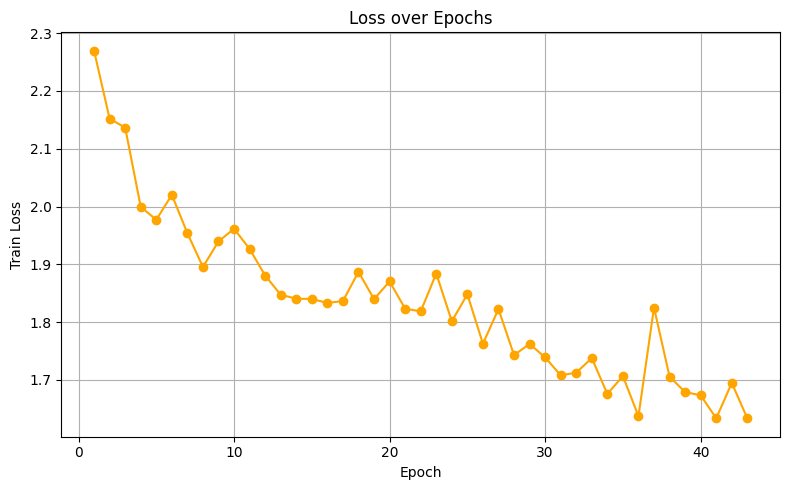

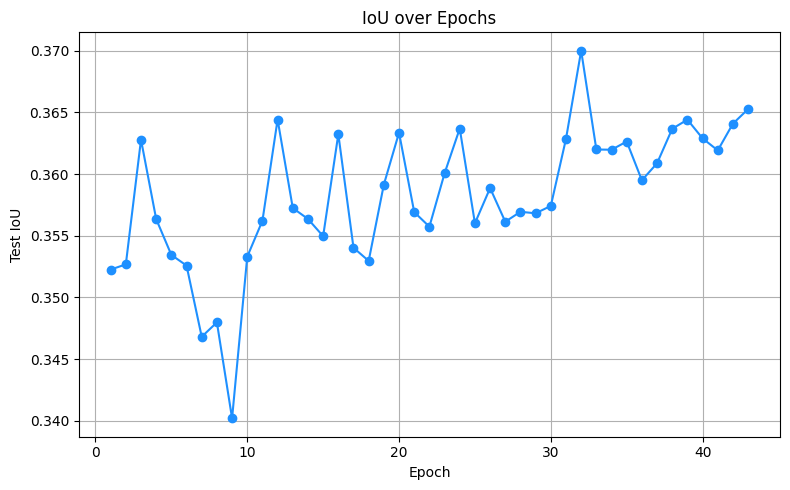

[10/183] Loss: 1.5158 Train Acc: 0.4870
[20/183] Loss: 1.3908 Train Acc: 0.5393
[30/183] Loss: 1.6529 Train Acc: 0.4233
[40/183] Loss: 1.7269 Train Acc: 0.4188
[50/183] Loss: 1.7212 Train Acc: 0.4114
[60/183] Loss: 1.6085 Train Acc: 0.4425
[70/183] Loss: 1.3728 Train Acc: 0.5206
[80/183] Loss: 1.5471 Train Acc: 0.4848
[90/183] Loss: 1.6701 Train Acc: 0.4484
[100/183] Loss: 1.6379 Train Acc: 0.4474
[110/183] Loss: 1.8124 Train Acc: 0.4112
[120/183] Loss: 1.7452 Train Acc: 0.4079
[130/183] Loss: 1.8460 Train Acc: 0.3969
[140/183] Loss: 1.9067 Train Acc: 0.4022
[150/183] Loss: 1.8493 Train Acc: 0.4133
[160/183] Loss: 1.6589 Train Acc: 0.4260
[170/183] Loss: 1.6715 Train Acc: 0.4208
[180/183] Loss: 2.0151 Train Acc: 0.4007
Epoch: 44, Test IoU: 0.3624


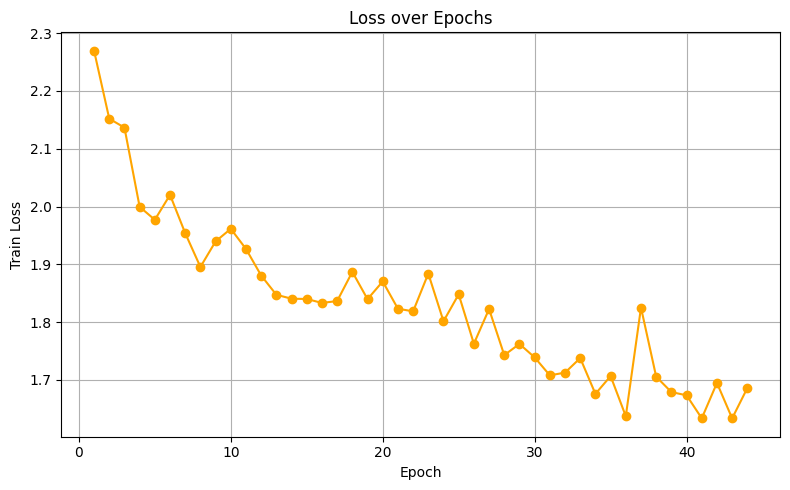

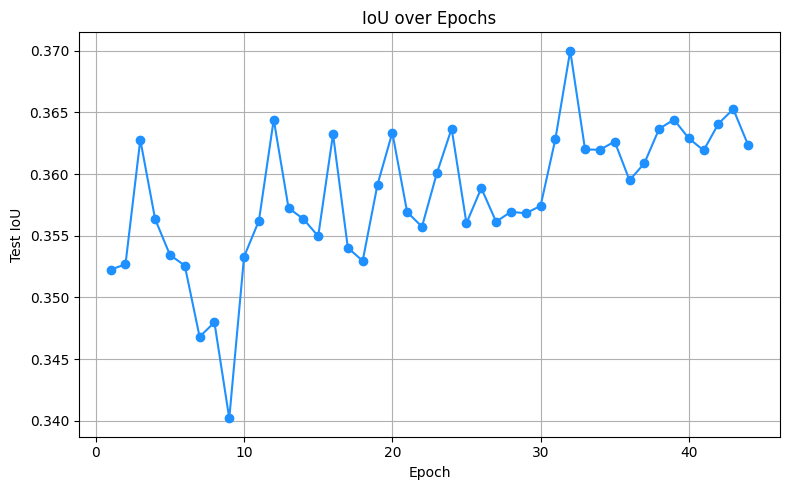

[10/183] Loss: 1.7705 Train Acc: 0.4325
[20/183] Loss: 1.6848 Train Acc: 0.4726
[30/183] Loss: 1.6832 Train Acc: 0.4135
[40/183] Loss: 1.7836 Train Acc: 0.4278
[50/183] Loss: 1.6328 Train Acc: 0.4366
[60/183] Loss: 1.6679 Train Acc: 0.4877
[70/183] Loss: 1.9182 Train Acc: 0.3838
[80/183] Loss: 1.5208 Train Acc: 0.4845
[90/183] Loss: 1.8945 Train Acc: 0.3607
[100/183] Loss: 1.7229 Train Acc: 0.4544
[110/183] Loss: 1.6235 Train Acc: 0.4512
[120/183] Loss: 1.7225 Train Acc: 0.4050
[130/183] Loss: 1.7571 Train Acc: 0.4354
[140/183] Loss: 1.5254 Train Acc: 0.4960
[150/183] Loss: 1.5171 Train Acc: 0.4734
[160/183] Loss: 1.6226 Train Acc: 0.4840
[170/183] Loss: 1.6868 Train Acc: 0.4335
[180/183] Loss: 1.8129 Train Acc: 0.4547
Epoch: 45, Test IoU: 0.3643


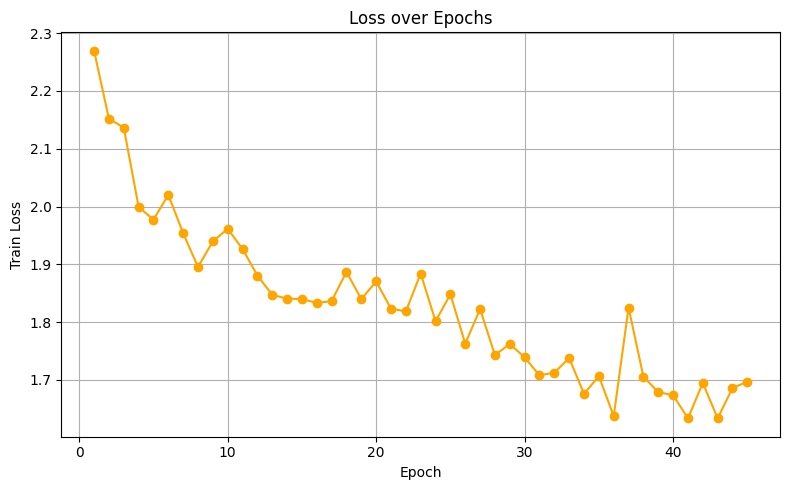

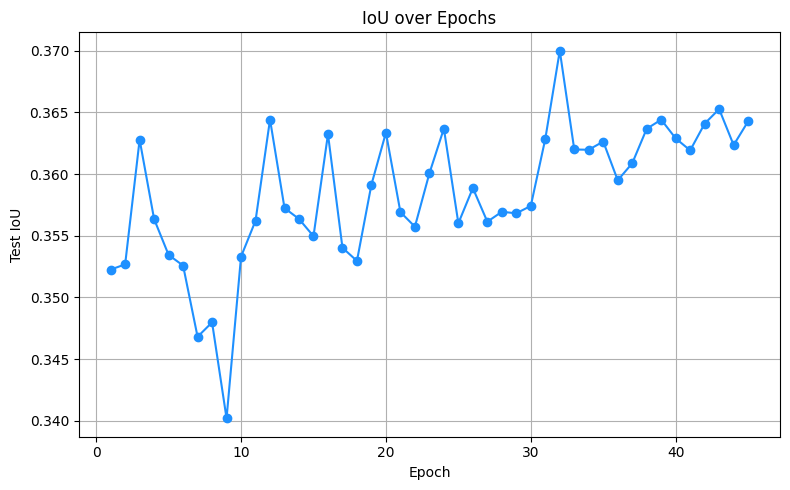

[10/183] Loss: 1.5495 Train Acc: 0.5046
[20/183] Loss: 1.6055 Train Acc: 0.4736
[30/183] Loss: 1.6170 Train Acc: 0.4296
[40/183] Loss: 1.4714 Train Acc: 0.4754
[50/183] Loss: 1.5807 Train Acc: 0.4854
[60/183] Loss: 1.6565 Train Acc: 0.4560
[70/183] Loss: 1.4801 Train Acc: 0.4616
[80/183] Loss: 1.8024 Train Acc: 0.4708
[90/183] Loss: 1.7104 Train Acc: 0.4339
[100/183] Loss: 1.6362 Train Acc: 0.4409
[110/183] Loss: 1.5910 Train Acc: 0.4656
[120/183] Loss: 1.7500 Train Acc: 0.4094
[130/183] Loss: 1.6256 Train Acc: 0.4545
[140/183] Loss: 1.6506 Train Acc: 0.4113
[150/183] Loss: 1.5715 Train Acc: 0.4684
[160/183] Loss: 1.6178 Train Acc: 0.4349
[170/183] Loss: 1.4690 Train Acc: 0.4716
[180/183] Loss: 1.6343 Train Acc: 0.4251
Epoch: 46, Test IoU: 0.3666


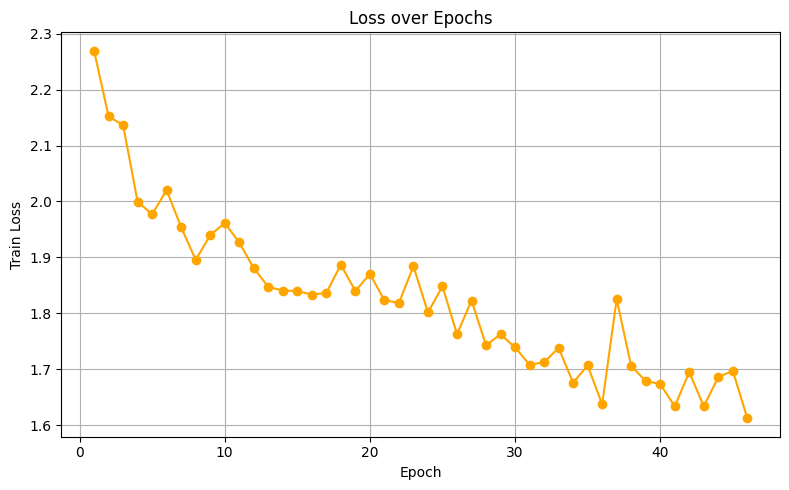

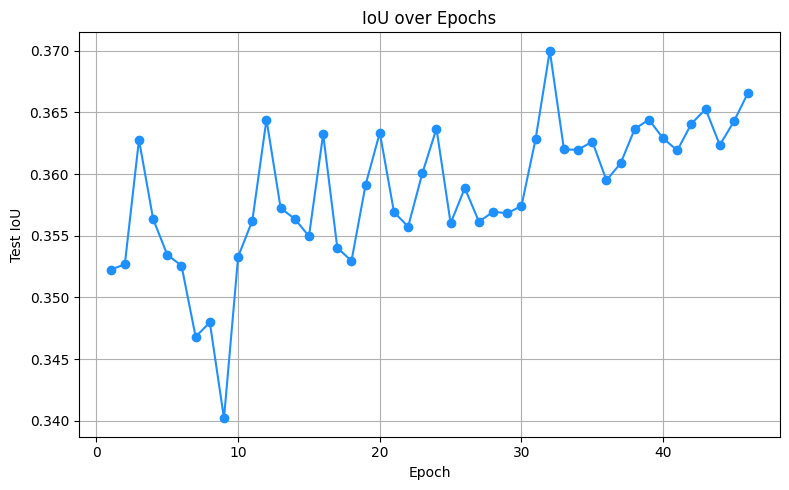

[10/183] Loss: 1.9137 Train Acc: 0.3911
[20/183] Loss: 2.0072 Train Acc: 0.3917
[30/183] Loss: 1.8771 Train Acc: 0.4020
[40/183] Loss: 1.9420 Train Acc: 0.3596
[50/183] Loss: 1.9242 Train Acc: 0.3408
[60/183] Loss: 1.7851 Train Acc: 0.4197
[70/183] Loss: 1.7890 Train Acc: 0.4100
[80/183] Loss: 1.7759 Train Acc: 0.4345
[90/183] Loss: 1.9710 Train Acc: 0.3640
[100/183] Loss: 1.6890 Train Acc: 0.4710
[110/183] Loss: 1.7357 Train Acc: 0.4473
[120/183] Loss: 1.8344 Train Acc: 0.4230
[130/183] Loss: 1.8400 Train Acc: 0.4116
[140/183] Loss: 1.7300 Train Acc: 0.4377
[150/183] Loss: 1.7475 Train Acc: 0.4630
[160/183] Loss: 2.0013 Train Acc: 0.3624
[170/183] Loss: 1.7616 Train Acc: 0.4315
[180/183] Loss: 1.6387 Train Acc: 0.4435
Epoch: 47, Test IoU: 0.3563


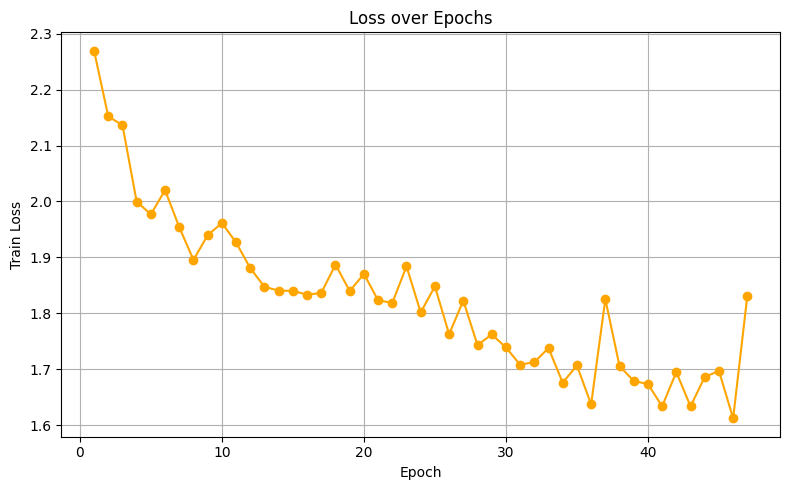

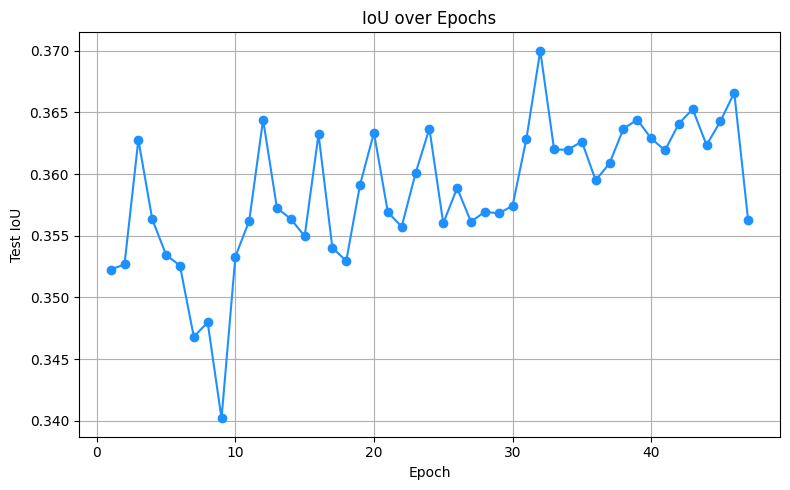

[10/183] Loss: 1.7144 Train Acc: 0.4227
[20/183] Loss: 1.7980 Train Acc: 0.4051
[30/183] Loss: 1.5627 Train Acc: 0.4653
[40/183] Loss: 1.8269 Train Acc: 0.4241
[50/183] Loss: 1.6954 Train Acc: 0.4456
[60/183] Loss: 1.6511 Train Acc: 0.4227
[70/183] Loss: 1.6521 Train Acc: 0.4403
[80/183] Loss: 1.3858 Train Acc: 0.5455
[90/183] Loss: 1.5379 Train Acc: 0.4499
[100/183] Loss: 1.9456 Train Acc: 0.3659
[110/183] Loss: 1.6385 Train Acc: 0.4619
[120/183] Loss: 1.6495 Train Acc: 0.4256
[130/183] Loss: 1.6674 Train Acc: 0.4815
[140/183] Loss: 1.4659 Train Acc: 0.5141
[150/183] Loss: 1.5319 Train Acc: 0.4729
[160/183] Loss: 1.4778 Train Acc: 0.4650
[170/183] Loss: 1.5651 Train Acc: 0.4505
[180/183] Loss: 1.5845 Train Acc: 0.4634
Epoch: 48, Test IoU: 0.3642


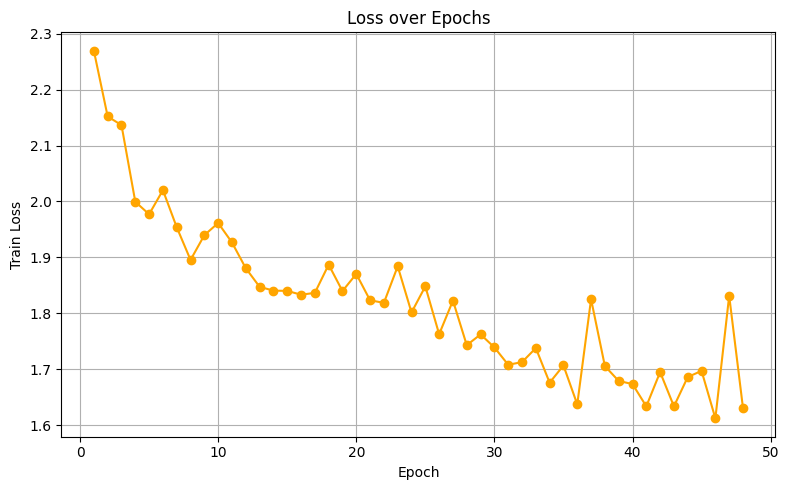

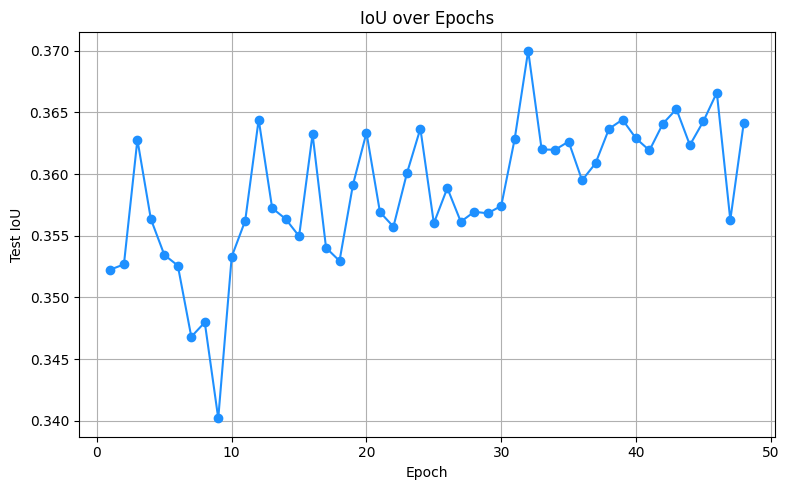

[10/183] Loss: 1.7508 Train Acc: 0.4165
[20/183] Loss: 1.9609 Train Acc: 0.3763
[30/183] Loss: 1.5583 Train Acc: 0.4679
[40/183] Loss: 1.7888 Train Acc: 0.4481
[50/183] Loss: 1.4575 Train Acc: 0.4767
[60/183] Loss: 1.5752 Train Acc: 0.4753
[70/183] Loss: 1.7706 Train Acc: 0.4627
[80/183] Loss: 1.7345 Train Acc: 0.4496
[90/183] Loss: 1.5665 Train Acc: 0.4862
[100/183] Loss: 1.5973 Train Acc: 0.4945
[110/183] Loss: 1.5580 Train Acc: 0.4796
[120/183] Loss: 1.7278 Train Acc: 0.4256
[130/183] Loss: 1.6507 Train Acc: 0.4529
[140/183] Loss: 1.5099 Train Acc: 0.4865
[150/183] Loss: 1.7591 Train Acc: 0.4151
[160/183] Loss: 1.5612 Train Acc: 0.4667
[170/183] Loss: 1.5325 Train Acc: 0.4922
[180/183] Loss: 1.5091 Train Acc: 0.4611
Epoch: 49, Test IoU: 0.3644


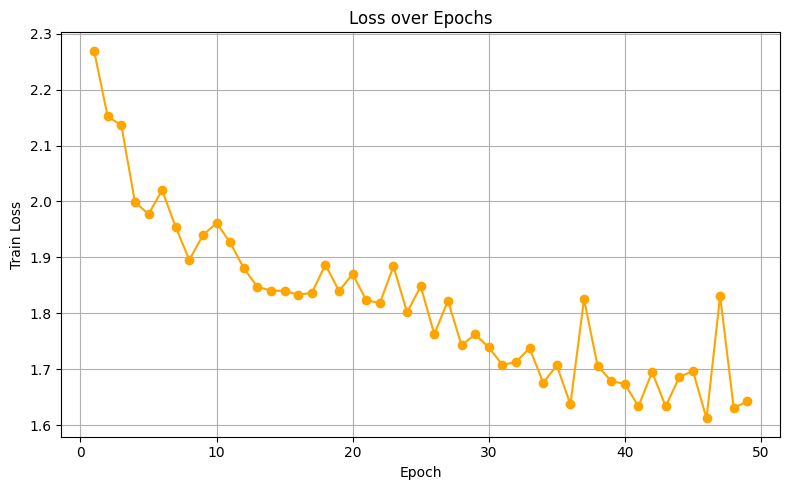

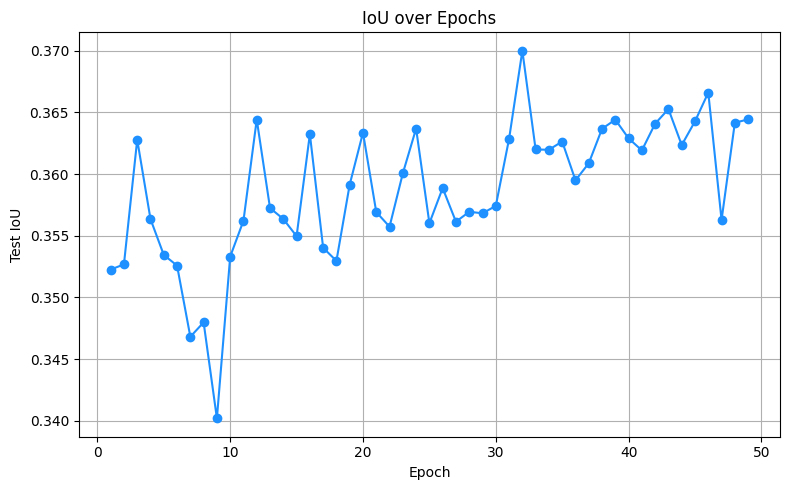

[10/183] Loss: 1.6240 Train Acc: 0.4507
[20/183] Loss: 1.5909 Train Acc: 0.4505
[30/183] Loss: 1.6214 Train Acc: 0.4724
[40/183] Loss: 1.4934 Train Acc: 0.4932
[50/183] Loss: 1.6482 Train Acc: 0.4734
[60/183] Loss: 1.6308 Train Acc: 0.4554
[70/183] Loss: 1.5652 Train Acc: 0.4511
[80/183] Loss: 1.3633 Train Acc: 0.5125
[90/183] Loss: 1.4277 Train Acc: 0.4935
[100/183] Loss: 1.5825 Train Acc: 0.4487
[110/183] Loss: 1.4883 Train Acc: 0.5000
[120/183] Loss: 1.6551 Train Acc: 0.4876
[130/183] Loss: 1.7402 Train Acc: 0.5071
[140/183] Loss: 1.6894 Train Acc: 0.4664
[150/183] Loss: 1.7643 Train Acc: 0.4628
[160/183] Loss: 1.6635 Train Acc: 0.4651
[170/183] Loss: 1.4934 Train Acc: 0.4442
[180/183] Loss: 1.5589 Train Acc: 0.4675
Epoch: 50, Test IoU: 0.3673


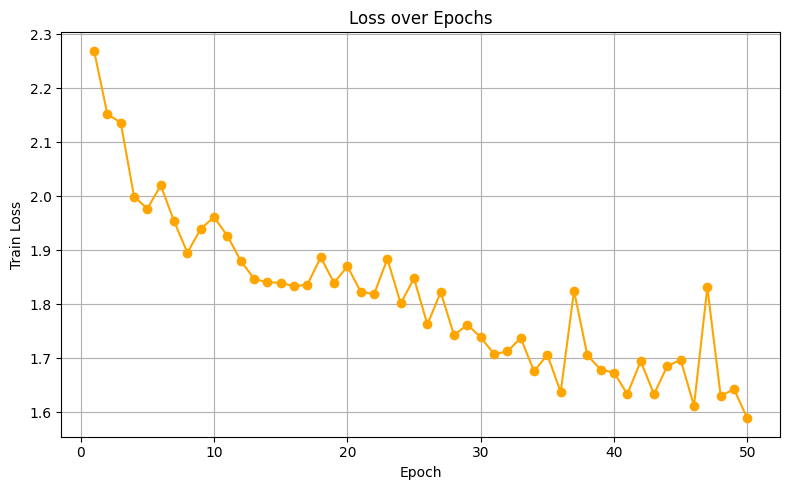

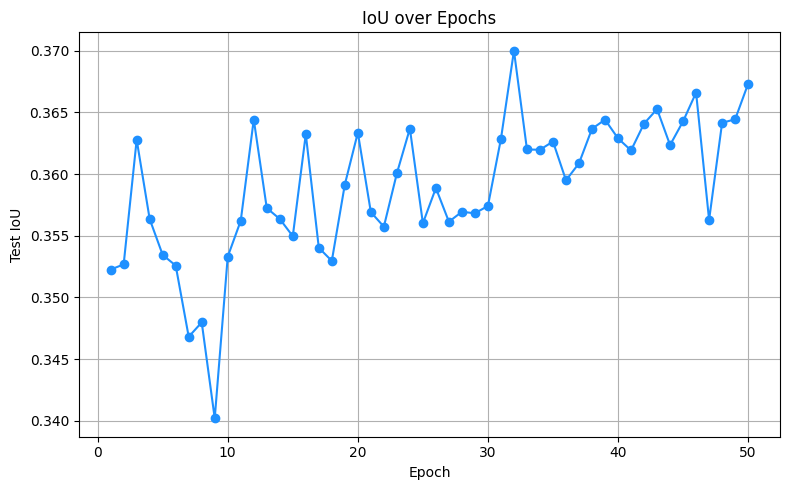

CPU times: user 14min 24s, sys: 29.1 s, total: 14min 53s
Wall time: 15min 58s


In [16]:
%%time

import matplotlib.pyplot as plt

def train():
    model.train()
    loss_list = []
    acc_list = []
    total_loss = correct_nodes = total_nodes = 0
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct_nodes += out.argmax(dim=1).eq(data.y).sum().item()
        total_nodes += data.num_nodes

        if (i + 1) % 10 == 0:
            tloss = total_loss / 10
            tacc = correct_nodes / total_nodes
            print(f'[{i+1}/{len(train_loader)}] Loss: {tloss:.4f} '
                  f'Train Acc: {tacc:.4f}')
            total_loss = correct_nodes = total_nodes = 0
            loss_list.append(tloss)
            acc_list.append(tacc)

    return np.mean(loss_list), np.mean(acc_list)

@torch.no_grad()
def test(loader):
    model.eval()

    ious, categories = [], []
    y_map = torch.empty(loader.dataset.num_classes, device=device).long()
    for data in loader:
        data = data.to(device)
        outs = model(data)

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        for out, y, category in zip(outs.split(sizes), data.y.split(sizes),
                                    data.category.tolist()):
            category = list(BreakBad.seg_classes.keys())[category]
            part = BreakBad.seg_classes[category]
            part = torch.tensor(part, device=device)

            y_map[part] = torch.arange(part.size(0), device=device)


            iou = jaccard_index(out[:, part].argmax(dim=-1), y_map[y],
                                num_classes=part.size(0), absent_score=1.0)
            ious.append(iou)
        categories.append(data.category)

    iou = torch.tensor(ious, device=device)
    category = torch.cat(categories, dim=0)

    mean_iou = scatter(iou, category, reduce='mean')  # Per-category IoU.
    return float(mean_iou.mean())  # Global IoU.

def plot_iou_over_epochs(iou_list):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(iou_list) + 1), iou_list, marker='o', color='dodgerblue')
    plt.title('IoU over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Test IoU')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_loss_over_epochs(iou_list):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(iou_list) + 1), iou_list, marker='o', color='orange')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

iou_list = []
loss_list = []

best_iou = 0.0  # or float('-inf') if you're maximizing
best_model_path = "pointnet.pth"

for epoch in range(1, 51):
    loss, acc = train()
    loss_list.append(loss)
    iou = test(test_loader)
    iou_list.append(iou)
    print(f'Epoch: {epoch:02d}, Test IoU: {iou:.4f}')
    plot_loss_over_epochs(loss_list)
    plot_iou_over_epochs(iou_list)
    if iou > best_iou:
        best_iou = iou
        torch.save(model.state_dict(), best_model_path)
        print(f"  >> Best model saved at epoch {epoch} with IoU: {best_iou:.4f}")





In [17]:
print(max(iou_list))


0.3700007200241089


#Test


In [18]:
model.load_state_dict(torch.load("/content/pointnet.pth"))

<All keys matched successfully>

In [24]:
import os
import numpy as np
from pathlib import Path

@torch.no_grad()
def predict_and_save_per_sample(loader, output_dir="break_results"):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)

    y_map = torch.empty(loader.dataset.num_classes, device=device).long()
    idx = 0  # sample index

    for data in loader:
        data = data.to(device)
        outs = model(data)

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        xs = data.pos.split(sizes)  # assume input is point positions

        ys = data.y.split(sizes)
        categories = data.category.tolist()

        for x, out, y, category in zip(xs, outs.split(sizes), ys, categories):
            category_str = list(BreakBad.seg_classes.keys())[category]
            part = BreakBad.seg_classes[category_str]
            part = torch.tensor(part, device=device)

            y_map[part] = torch.arange(part.size(0), device=device)

            y_pred = out[:, part].argmax(dim=-1)
            y_true = y_map[y]

            # Save as npz
            file_path = Path(output_dir) / f"sample_{idx:04d}.npz"
            np.savez_compressed(
                file_path,
                x=x.cpu().numpy(),             # 3D points
                y_true=y_true.cpu().numpy(),   # ground truth labels
                y_pred=y_pred.cpu().numpy()    # predicted labels
            )
            idx += 1

    print(f"Saved {idx} samples to: {output_dir}")
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


gt_cmap = np.array([
    [0.121, 0.466, 0.705],  # Blue for class 0
    [1.000, 0.498, 0.054],  # Orange for class 1
])
pred_cmap = np.array([
    [0.054, 0.705, 0.054],  # Blue
    [1.000, 0.498, 0.054],  # Orange
])

def visualize_sample_npz(file_path):
    data = np.load(file_path)
    x = data['x']           # shape: (N, 3)
    y_true = data['y_true'] # shape: (N,)
    print(np.unique(y_true))
    y_pred = data['y_pred'] # shape: (N,)
    print(np.unique(y_pred))

    gt_colors = gt_cmap[y_true]
    pred_colors = pred_cmap[y_pred]

    fig = plt.figure(figsize=(12, 6))

    # --- Ground Truth ---
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.scatter(x[:, 0], x[:, 1], x[:, 2], c=gt_colors, s=5)
    ax1.set_title("Ground Truth Labels")
    ax1.axis('off')

    # --- Prediction ---
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.scatter(x[:, 0], x[:, 1], x[:, 2], c=pred_colors, s=5)
    ax2.set_title("Predicted Labels")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()




In [20]:

@torch.no_grad()
def eval_value(loader):
    model.eval()

    ious, categories = [], []
    correct, total = 0, 0  # For accuracy
    y_map = torch.empty(loader.dataset.num_classes, device=device).long()

    for data in loader:
        data = data.to(device)
        outs = model(data)

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        for out, y, category in zip(outs.split(sizes), data.y.split(sizes),
                                    data.category.tolist()):
            category = list(BreakBad.seg_classes.keys())[category]
            part = BreakBad.seg_classes[category]
            part = torch.tensor(part, device=device)

            y_map[part] = torch.arange(part.size(0), device=device)

            pred = out[:, part].argmax(dim=-1)
            target = y_map[y]

            correct += (pred == target).sum().item()
            total += target.numel()

            iou = jaccard_index(pred, target,
                                num_classes=part.size(0), absent_score=1.0)
            ious.append(iou)

        categories.append(data.category)

    iou = torch.tensor(ious, device=device)
    category = torch.cat(categories, dim=0)

    mean_iou = scatter(iou, category, reduce='mean')  # Per-category IoU.
    accuracy = correct / total

    return accuracy, float(mean_iou.mean())  # Return both Accuracy and Mean IoU

In [21]:
acc, miou = eval_value(test_loader)
print(f"Accuracy: {acc:.4f}, Mean IoU: {miou:.4f}")

Accuracy: 0.7529, Mean IoU: 0.3694


In [26]:
predict_and_save_per_sample(test_loader)

Saved 549 samples to: break_results


Sample_0181.npz
[0 1]
[0]


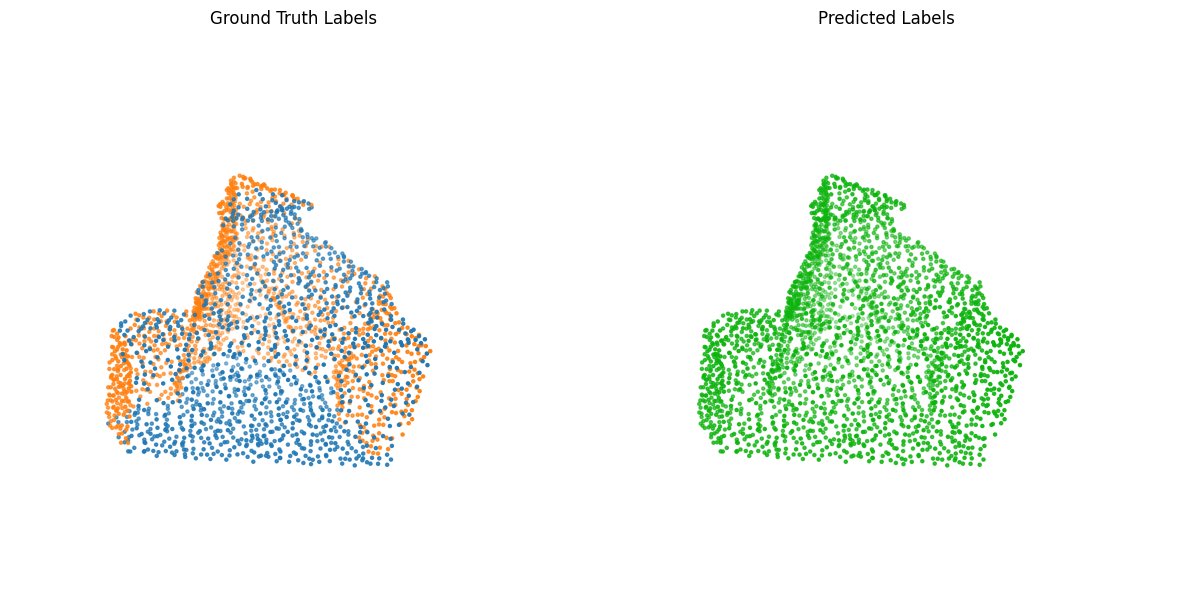

In [35]:
idx = random.randint(0, 549)
print(f"Sample_{idx:04d}.npz")
visualize_sample_npz(f"/content/break_results/sample_{idx:04d}.npz")

#fanta


In [ ]:
!rm -r /content/data2

In [36]:
!unzip /content/processed_fanta_v4.zip -d /content/temp_extract
!mkdir /content/data2
!mkdir /content/data2/raw
!mv /content/temp_extract/processed_fanta_v4/* /content/data2/raw
!rm -r /content/temp_extract

Archive:  /content/processed_fanta_v4.zip
   creating: /content/temp_extract/processed_fanta_v4/
   creating: /content/temp_extract/processed_fanta_v4/abc/
  inflating: /content/temp_extract/processed_fanta_v4/abc/00002.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00003.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00005.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00006.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00008.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00011.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00012.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00013.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00014.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00015.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00016.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00017.txt  
  in

In [37]:

class FantaBrk(InMemoryDataset):
    r"""The ShapeNet part level segmentation dataset from the `"A Scalable
    Active Framework for Region Annotation in 3D Shape Collections"
    <http://web.stanford.edu/~ericyi/papers/part_annotation_16_small.pdf>`_
    paper, containing about 17,000 3D shape point clouds from 16 shape
    categories.
    Each category is annotated with 2 to 6 parts.

    Args:
        root (str): Root directory where the dataset should be saved.
        categories (str or [str], optional): The category of the CAD models
            (one or a combination of :obj:`"Airplane"`, :obj:`"Bag"`,
            :obj:`"Cap"`, :obj:`"Car"`, :obj:`"Chair"`, :obj:`"Earphone"`,
            :obj:`"Guitar"`, :obj:`"Knife"`, :obj:`"Lamp"`, :obj:`"Laptop"`,
            :obj:`"Motorbike"`, :obj:`"Mug"`, :obj:`"Pistol"`, :obj:`"Rocket"`,
            :obj:`"Skateboard"`, :obj:`"Table"`).
            Can be explicitly set to :obj:`None` to load all categories.
            (default: :obj:`None`)
        include_normals (bool, optional): If set to :obj:`False`, will not
            include normal vectors as input features to :obj:`data.x`.
            As a result, :obj:`data.x` will be :obj:`None`.
            (default: :obj:`True`)
        split (str, optional): If :obj:`"train"`, loads the training dataset.
            If :obj:`"val"`, loads the validation dataset.
            If :obj:`"trainval"`, loads the training and validation dataset.
            If :obj:`"test"`, loads the test dataset.
            (default: :obj:`"trainval"`)
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
        pre_filter (callable, optional): A function that takes in an
            :obj:`torch_geometric.data.Data` object and returns a boolean
            value, indicating whether the data object should be included in the
            final dataset. (default: :obj:`None`)
        force_reload (bool, optional): Whether to re-process the dataset.
            (default: :obj:`False`)

    **STATS:**

    .. list-table::
        :widths: 10 10 10 10 10
        :header-rows: 1

        * - #graphs
          - #nodes
          - #edges
          - #features
          - #classes
        * - 16,881
          - ~2,616.2
          - 0
          - 3
          - 50
    """

    url = ('https://shapenet.cs.stanford.edu/media/'
           'shapenetcore_partanno_segmentation_benchmark_v0_normal.zip')

    # In case `shapenet.cs.stanford.edu` is offline, try to download the data
    # from Kaggle instead (requires login):
    # https://www.kaggle.com/datasets/mitkir/shapenet/download?datasetVersionNumber=1

    category_ids = {'All_Statue': 'abc'}



    seg_classes = {'All_Statue': [0, 1]}

    def __init__(
        self,
        root: str,
        categories: Optional[Union[str, List[str]]] = None,
        include_normals: bool = True,
        split: str = 'trainval',
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        pre_filter: Optional[Callable] = None,
        force_reload: bool = False,
    ) -> None:
        if categories is None:
            categories = list(self.category_ids.keys())
        if isinstance(categories, str):
            categories = [categories]
        print(categories)
        assert all(category in self.category_ids for category in categories)
        self.categories = categories
        super().__init__(root, transform, pre_transform, pre_filter,
                         force_reload=force_reload)

        if split == 'train':
            path = self.processed_paths[0]
        elif split == 'val':
            path = self.processed_paths[1]
        elif split == 'test':
            path = self.processed_paths[2]
        elif split == 'trainval':
            path = self.processed_paths[3]
        else:
            raise ValueError(f'Split {split} found, but expected either '
                             'train, val, trainval or test')

        self.load(path)

        assert isinstance(self._data, Data)
        self._data.x = self._data.x if include_normals else None

        self.y_mask = torch.zeros((len(self.seg_classes.keys()),len(self.seg_classes.keys())*2),
                                  dtype=torch.bool)
        for i, labels in enumerate(self.seg_classes.values()):
            self.y_mask[i, labels] = 1

    @property
    def num_classes(self) -> int:
        return self.y_mask.size(-1)

    @property
    def raw_file_names(self) -> List[str]:
        return list(self.category_ids.values()) + ['train_test_split']

    @property
    def processed_file_names(self) -> List[str]:
        cats = '_'.join([cat[:3].lower() for cat in self.categories])
        return [
            osp.join(f'{cats}_{split}.pt')
            for split in ['train', 'val', 'test', 'trainval']
        ]

    def download(self) -> None:
        pass

    def process_filenames(self, filenames: List[str]) -> List[Data]:
        rank_ids = {'abc': 0}
        data_list = []
        categories_ids = [self.category_ids[cat] for cat in self.categories]
        cat_idx = {categories_ids[i]: i for i in range(len(categories_ids))}

        for name in filenames:
            cat = name.split(osp.sep)[0]
            if cat not in categories_ids:
                continue
            my_custom_idx = rank_ids[cat]
            tensor = read_txt_array(osp.join(self.raw_dir, name))
            pos = tensor[:, :3]
            x = tensor[:, 3:6]
            y = tensor[:, -1].type(torch.long)+2*my_custom_idx
            data = Data(pos=pos, x=x, y=y, category=cat_idx[cat])
            if self.pre_filter is not None and not self.pre_filter(data):
                continue
            if self.pre_transform is not None:
                data = self.pre_transform(data)
            data_list.append(data)

        return data_list

    def process(self) -> None:
        trainval = []
        for i, split in enumerate(['train', 'val', 'test']):
            path = osp.join(self.raw_dir, 'train_test_split',
                            f'shuffled_{split}_file_list.json')
            with open(path) as f:
                filenames = [
                    osp.sep.join(name.split('/')[1:]) + '.txt'
                    for name in json.load(f)
                ]  # Removing first directory.
            data_list = self.process_filenames(filenames)
            if split == 'train' or split == 'val':
                trainval += data_list
            self.save(data_list, self.processed_paths[i])
        self.save(trainval, self.processed_paths[3])

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({len(self)}, '
                f'categories={self.categories})')


In [38]:
category = None  # Pass in `None` to train on all categories.
path = "/content/data2"
transform = T.Compose([
    T.RandomJitter(0.01),
    T.RandomRotate(15, axis=0),
    T.RandomRotate(15, axis=1),
    T.RandomRotate(15, axis=2)
])
pre_transform = T.NormalizeScale()
train_dataset2 = FantaBrk(path, category, split='trainval', transform=transform,
                         pre_transform=pre_transform)
test_dataset2 = FantaBrk(path, category, split='test',
                        pre_transform=pre_transform)
train_loader2 = DataLoader(train_dataset2, batch_size=12, shuffle=True,
                          num_workers=2)
test_loader2 = DataLoader(test_dataset2, batch_size=12, shuffle=False,
                         num_workers=2)

['All_Statue']


Processing...


['All_Statue']


Done!


Unique classes [0 1]


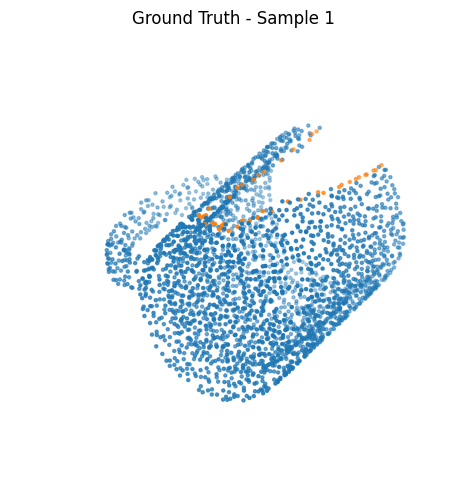

Unique classes [0 1]


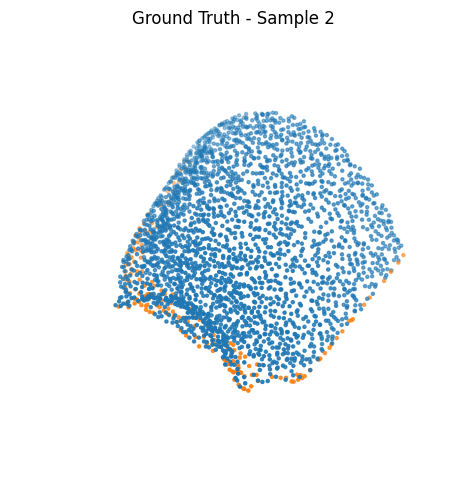

Unique classes [0 1]


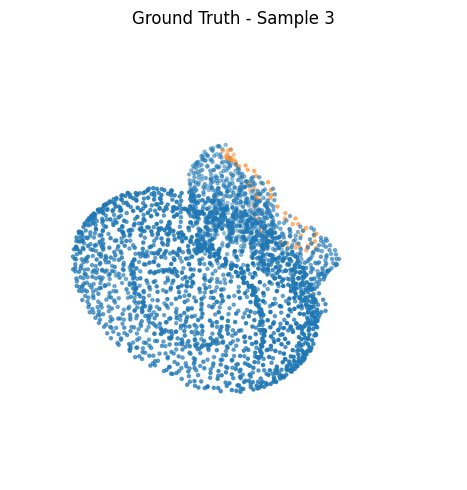

Unique classes [0 1]


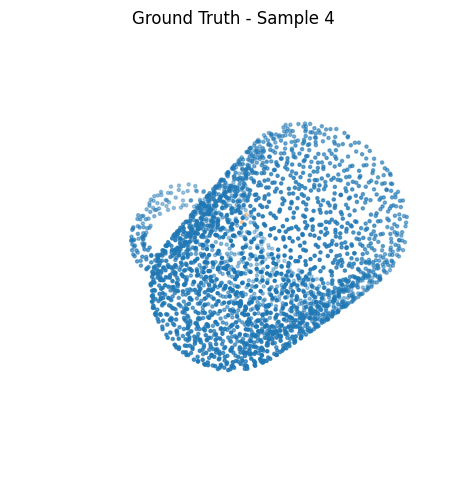

In [39]:
visualize_ground_truth_3d(test_loader2, num_samples=4)

In [40]:
acc, miou = eval_value(train_loader2)
print(f"Accuracy: {acc:.4f}, Mean IoU: {miou:.4f}")

Accuracy: 0.4892, Mean IoU: 0.2453


In [41]:
length = predict_and_save_per_sample(train_loader2,output_dir = "fanta_result")

Saved 120 samples to: fanta_result


Sample_0053.npz
[0 1]
[1]


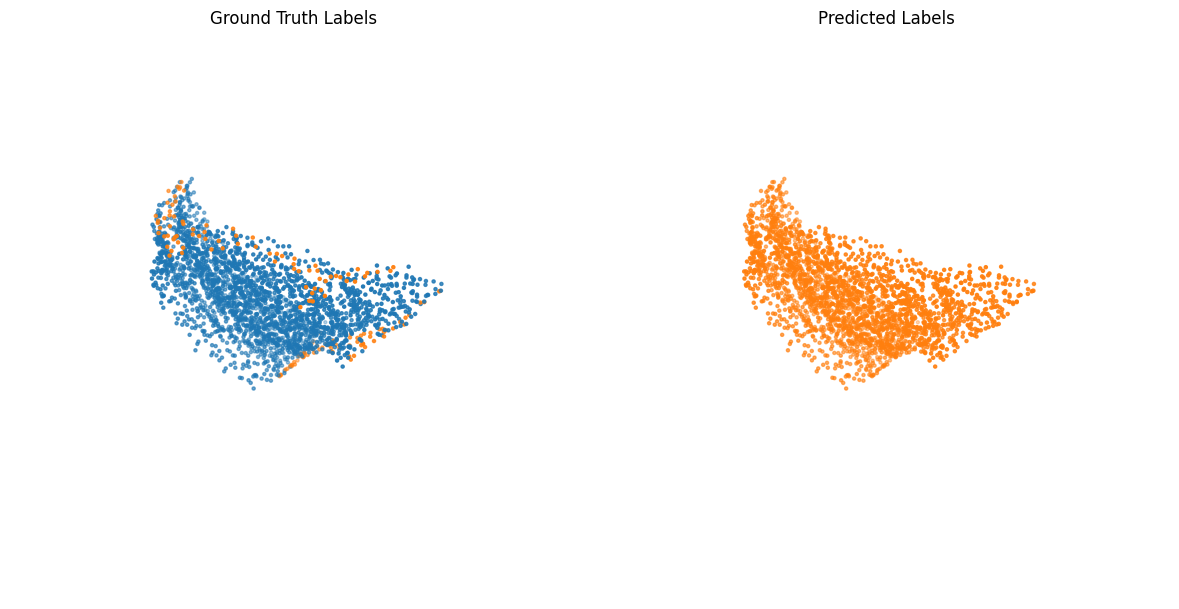

Sample_0057.npz
[0 1]
[0]


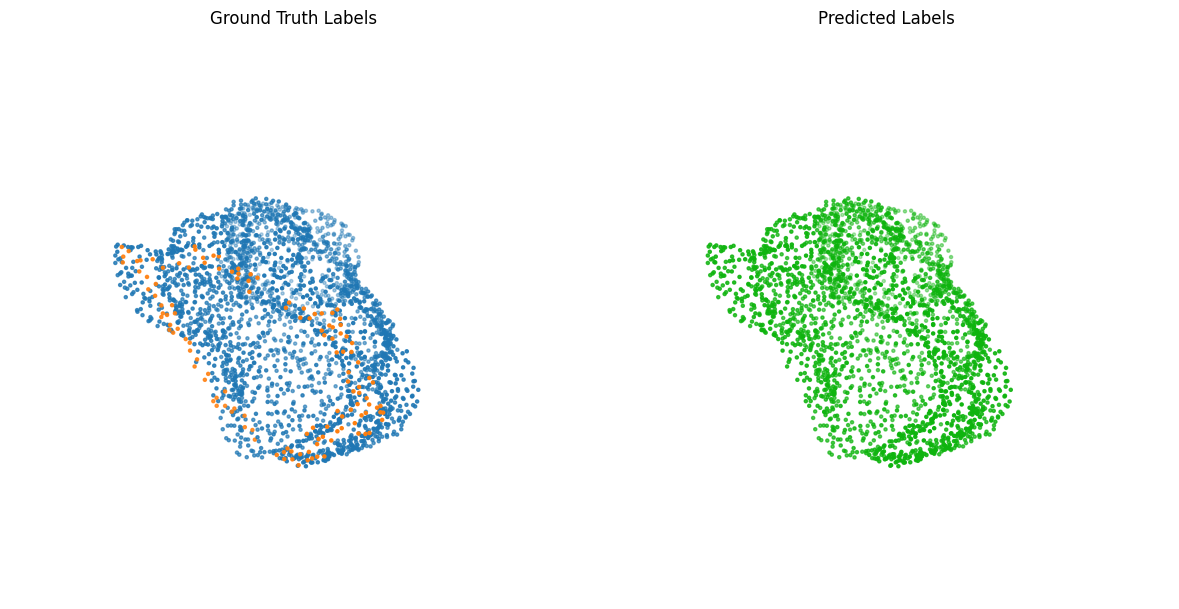

Sample_0074.npz
[0 1]
[0]


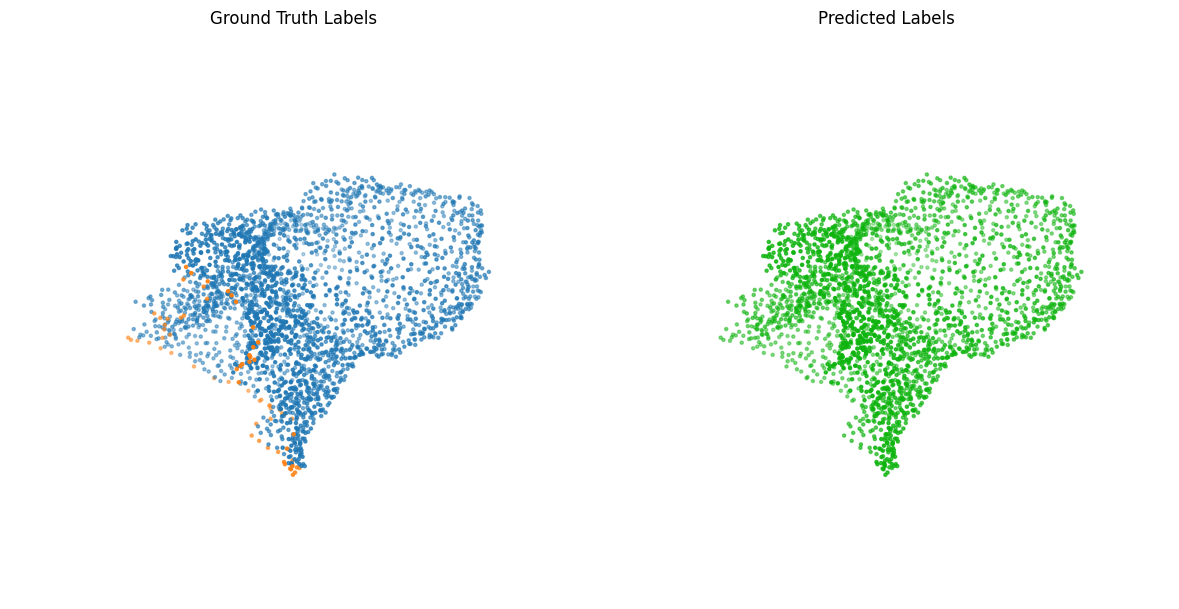

Sample_0092.npz
[0 1]
[1]


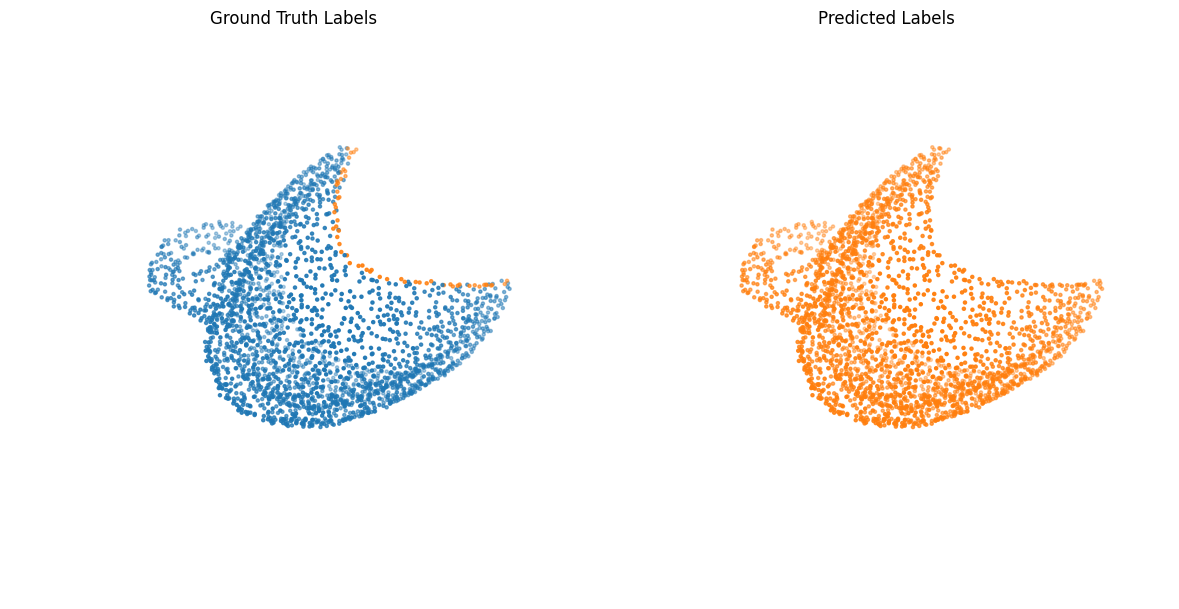

Sample_0096.npz
[0 1]
[0]


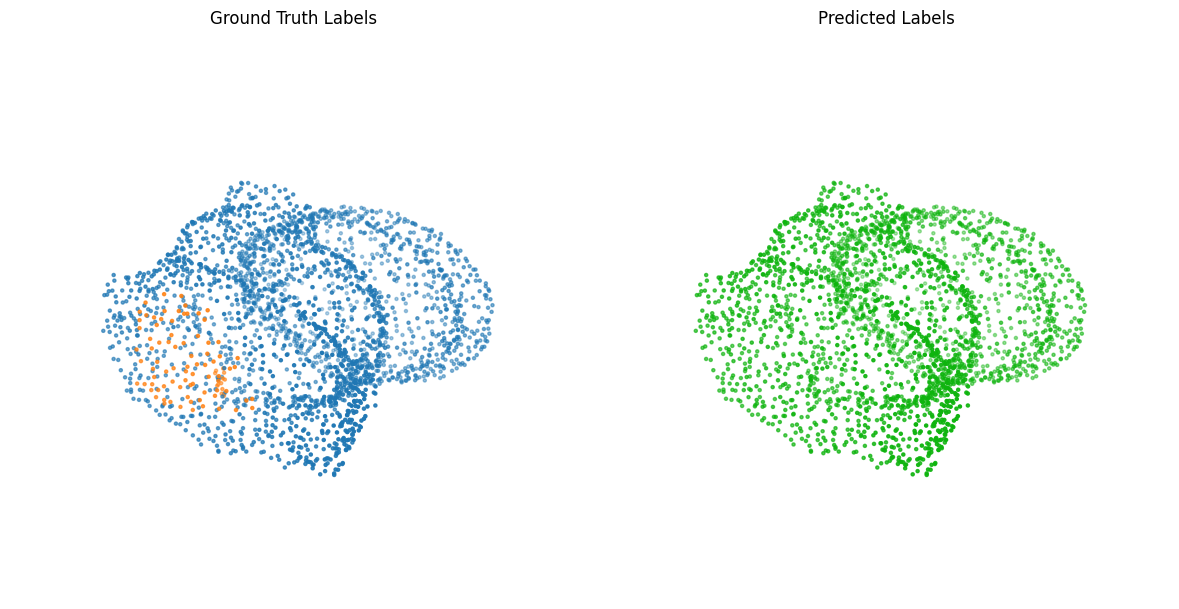

In [43]:
def wow2():
  idx = random.randint(0, 120)
  print(f"Sample_{idx:04d}.npz")
  visualize_sample_npz(f"/content/fanta_result/sample_{idx:04d}.npz")

wow2()

wow2()

wow2()
wow2()

wow2()

In [45]:
!mkdir -p output
!cp -r /content/break_result output/
!cp -r /content/fanta_result output/
!cp /content/pointnet.pth output/
!zip -r pointnet.zip output

from google.colab import files
files.download("pointnet.zip")

  adding: output/ (stored 0%)
  adding: output/pointnet.pth (deflated 7%)
  adding: output/break_result/ (stored 0%)
  adding: output/break_result/sample_0450.npz (deflated 0%)
  adding: output/break_result/sample_0248.npz (deflated 0%)
  adding: output/break_result/sample_0140.npz (deflated 0%)
  adding: output/break_result/sample_0051.npz (deflated 0%)
  adding: output/break_result/sample_0009.npz (deflated 0%)
  adding: output/break_result/sample_0203.npz (deflated 1%)
  adding: output/break_result/sample_0436.npz (deflated 0%)
  adding: output/break_result/sample_0006.npz (deflated 0%)
  adding: output/break_result/sample_0286.npz (deflated 0%)
  adding: output/break_result/sample_0184.npz (deflated 0%)
  adding: output/break_result/sample_0110.npz (deflated 0%)
  adding: output/break_result/sample_0127.npz (deflated 0%)
  adding: output/break_result/sample_0517.npz (deflated 0%)
  adding: output/break_result/sample_0314.npz (deflated 0%)
  adding: output/break_result/sample_0291.n

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>